# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


## Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [6]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")
model = scvi.model.AmortizedLDA(adata, n_topics=n_topics)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



```{note}
By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.
```

In [7]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000:   0%|          | 1/1000 [00:00<06:02,  2.76it/s]

Epoch 1/1000:   0%|          | 1/1000 [00:00<06:02,  2.76it/s, v_num=1]

Epoch 2/1000:   0%|          | 1/1000 [00:00<06:02,  2.76it/s, v_num=1]

Epoch 2/1000:   0%|          | 2/1000 [00:00<06:03,  2.74it/s, v_num=1]

Epoch 2/1000:   0%|          | 2/1000 [00:00<06:03,  2.74it/s, v_num=1, elbo_train=2.88e+7]

Epoch 3/1000:   0%|          | 2/1000 [00:00<06:03,  2.74it/s, v_num=1, elbo_train=2.88e+7]

Epoch 3/1000:   0%|          | 3/1000 [00:01<06:01,  2.76it/s, v_num=1, elbo_train=2.88e+7]

Epoch 3/1000:   0%|          | 3/1000 [00:01<06:01,  2.76it/s, v_num=1, elbo_train=2.84e+7]

Epoch 4/1000:   0%|          | 3/1000 [00:01<06:01,  2.76it/s, v_num=1, elbo_train=2.84e+7]

Epoch 4/1000:   0%|          | 4/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.84e+7]

Epoch 4/1000:   0%|          | 4/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.8e+7] 

Epoch 5/1000:   0%|          | 4/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.8e+7]

Epoch 5/1000:   0%|          | 5/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.8e+7]

Epoch 5/1000:   0%|          | 5/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.78e+7]

Epoch 6/1000:   0%|          | 5/1000 [00:01<05:59,  2.77it/s, v_num=1, elbo_train=2.78e+7]

Epoch 6/1000:   1%|          | 6/1000 [00:02<05:58,  2.77it/s, v_num=1, elbo_train=2.78e+7]

Epoch 6/1000:   1%|          | 6/1000 [00:02<05:58,  2.77it/s, v_num=1, elbo_train=2.75e+7]

Epoch 7/1000:   1%|          | 6/1000 [00:02<05:58,  2.77it/s, v_num=1, elbo_train=2.75e+7]

Epoch 7/1000:   1%|          | 7/1000 [00:02<05:57,  2.78it/s, v_num=1, elbo_train=2.75e+7]

Epoch 7/1000:   1%|          | 7/1000 [00:02<05:57,  2.78it/s, v_num=1, elbo_train=2.76e+7]

Epoch 8/1000:   1%|          | 7/1000 [00:02<05:57,  2.78it/s, v_num=1, elbo_train=2.76e+7]

Epoch 8/1000:   1%|          | 8/1000 [00:02<05:56,  2.78it/s, v_num=1, elbo_train=2.76e+7]

Epoch 8/1000:   1%|          | 8/1000 [00:02<05:56,  2.78it/s, v_num=1, elbo_train=2.74e+7]

Epoch 9/1000:   1%|          | 8/1000 [00:02<05:56,  2.78it/s, v_num=1, elbo_train=2.74e+7]

Epoch 9/1000:   1%|          | 9/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.74e+7]

Epoch 9/1000:   1%|          | 9/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.69e+7]

Epoch 10/1000:   1%|          | 9/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.69e+7]

Epoch 10/1000:   1%|          | 10/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.69e+7]

Epoch 10/1000:   1%|          | 10/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 11/1000:   1%|          | 10/1000 [00:03<05:56,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 11/1000:   1%|          | 11/1000 [00:03<05:55,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 11/1000:   1%|          | 11/1000 [00:03<05:55,  2.78it/s, v_num=1, elbo_train=2.7e+7] 

Epoch 12/1000:   1%|          | 11/1000 [00:03<05:55,  2.78it/s, v_num=1, elbo_train=2.7e+7]

Epoch 12/1000:   1%|          | 12/1000 [00:04<05:55,  2.78it/s, v_num=1, elbo_train=2.7e+7]

Epoch 12/1000:   1%|          | 12/1000 [00:04<05:55,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 13/1000:   1%|          | 12/1000 [00:04<05:55,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 13/1000:   1%|▏         | 13/1000 [00:04<05:54,  2.78it/s, v_num=1, elbo_train=2.68e+7]

Epoch 13/1000:   1%|▏         | 13/1000 [00:04<05:54,  2.78it/s, v_num=1, elbo_train=2.65e+7]

Epoch 14/1000:   1%|▏         | 13/1000 [00:04<05:54,  2.78it/s, v_num=1, elbo_train=2.65e+7]

Epoch 14/1000:   1%|▏         | 14/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.65e+7]

Epoch 14/1000:   1%|▏         | 14/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.62e+7]

Epoch 15/1000:   1%|▏         | 14/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.62e+7]

Epoch 15/1000:   2%|▏         | 15/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.62e+7]

Epoch 15/1000:   2%|▏         | 15/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.63e+7]

Epoch 16/1000:   2%|▏         | 15/1000 [00:05<05:54,  2.78it/s, v_num=1, elbo_train=2.63e+7]

Epoch 16/1000:   2%|▏         | 16/1000 [00:05<05:53,  2.78it/s, v_num=1, elbo_train=2.63e+7]

Epoch 16/1000:   2%|▏         | 16/1000 [00:05<05:53,  2.78it/s, v_num=1, elbo_train=2.6e+7] 

Epoch 17/1000:   2%|▏         | 16/1000 [00:05<05:53,  2.78it/s, v_num=1, elbo_train=2.6e+7]

Epoch 17/1000:   2%|▏         | 17/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.6e+7]

Epoch 17/1000:   2%|▏         | 17/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.58e+7]

Epoch 18/1000:   2%|▏         | 17/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.58e+7]

Epoch 18/1000:   2%|▏         | 18/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.58e+7]

Epoch 18/1000:   2%|▏         | 18/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.56e+7]

Epoch 19/1000:   2%|▏         | 18/1000 [00:06<05:53,  2.78it/s, v_num=1, elbo_train=2.56e+7]

Epoch 19/1000:   2%|▏         | 19/1000 [00:06<05:54,  2.77it/s, v_num=1, elbo_train=2.56e+7]

Epoch 19/1000:   2%|▏         | 19/1000 [00:06<05:54,  2.77it/s, v_num=1, elbo_train=2.55e+7]

Epoch 20/1000:   2%|▏         | 19/1000 [00:06<05:54,  2.77it/s, v_num=1, elbo_train=2.55e+7]

Epoch 20/1000:   2%|▏         | 20/1000 [00:07<06:14,  2.62it/s, v_num=1, elbo_train=2.55e+7]

Epoch 20/1000:   2%|▏         | 20/1000 [00:07<06:14,  2.62it/s, v_num=1, elbo_train=2.55e+7]

Epoch 21/1000:   2%|▏         | 20/1000 [00:07<06:14,  2.62it/s, v_num=1, elbo_train=2.55e+7]

Epoch 21/1000:   2%|▏         | 21/1000 [00:07<06:15,  2.61it/s, v_num=1, elbo_train=2.55e+7]

Epoch 21/1000:   2%|▏         | 21/1000 [00:07<06:15,  2.61it/s, v_num=1, elbo_train=2.54e+7]

Epoch 22/1000:   2%|▏         | 21/1000 [00:07<06:15,  2.61it/s, v_num=1, elbo_train=2.54e+7]

Epoch 22/1000:   2%|▏         | 22/1000 [00:08<06:12,  2.63it/s, v_num=1, elbo_train=2.54e+7]

Epoch 22/1000:   2%|▏         | 22/1000 [00:08<06:12,  2.63it/s, v_num=1, elbo_train=2.49e+7]

Epoch 23/1000:   2%|▏         | 22/1000 [00:08<06:12,  2.63it/s, v_num=1, elbo_train=2.49e+7]

Epoch 23/1000:   2%|▏         | 23/1000 [00:08<06:03,  2.69it/s, v_num=1, elbo_train=2.49e+7]

Epoch 23/1000:   2%|▏         | 23/1000 [00:08<06:03,  2.69it/s, v_num=1, elbo_train=2.5e+7] 

Epoch 24/1000:   2%|▏         | 23/1000 [00:08<06:03,  2.69it/s, v_num=1, elbo_train=2.5e+7]

Epoch 24/1000:   2%|▏         | 24/1000 [00:08<05:57,  2.73it/s, v_num=1, elbo_train=2.5e+7]

Epoch 24/1000:   2%|▏         | 24/1000 [00:08<05:57,  2.73it/s, v_num=1, elbo_train=2.5e+7]

Epoch 25/1000:   2%|▏         | 24/1000 [00:08<05:57,  2.73it/s, v_num=1, elbo_train=2.5e+7]

Epoch 25/1000:   2%|▎         | 25/1000 [00:09<05:53,  2.76it/s, v_num=1, elbo_train=2.5e+7]

Epoch 25/1000:   2%|▎         | 25/1000 [00:09<05:53,  2.76it/s, v_num=1, elbo_train=2.49e+7]

Epoch 26/1000:   2%|▎         | 25/1000 [00:09<05:53,  2.76it/s, v_num=1, elbo_train=2.49e+7]

Epoch 26/1000:   3%|▎         | 26/1000 [00:09<05:50,  2.78it/s, v_num=1, elbo_train=2.49e+7]

Epoch 26/1000:   3%|▎         | 26/1000 [00:09<05:50,  2.78it/s, v_num=1, elbo_train=2.45e+7]

Epoch 27/1000:   3%|▎         | 26/1000 [00:09<05:50,  2.78it/s, v_num=1, elbo_train=2.45e+7]

Epoch 27/1000:   3%|▎         | 27/1000 [00:09<05:47,  2.80it/s, v_num=1, elbo_train=2.45e+7]

Epoch 27/1000:   3%|▎         | 27/1000 [00:09<05:47,  2.80it/s, v_num=1, elbo_train=2.45e+7]

Epoch 28/1000:   3%|▎         | 27/1000 [00:09<05:47,  2.80it/s, v_num=1, elbo_train=2.45e+7]

Epoch 28/1000:   3%|▎         | 28/1000 [00:10<05:46,  2.81it/s, v_num=1, elbo_train=2.45e+7]

Epoch 28/1000:   3%|▎         | 28/1000 [00:10<05:46,  2.81it/s, v_num=1, elbo_train=2.43e+7]

Epoch 29/1000:   3%|▎         | 28/1000 [00:10<05:46,  2.81it/s, v_num=1, elbo_train=2.43e+7]

Epoch 29/1000:   3%|▎         | 29/1000 [00:10<05:44,  2.82it/s, v_num=1, elbo_train=2.43e+7]

Epoch 29/1000:   3%|▎         | 29/1000 [00:10<05:44,  2.82it/s, v_num=1, elbo_train=2.41e+7]

Epoch 30/1000:   3%|▎         | 29/1000 [00:10<05:44,  2.82it/s, v_num=1, elbo_train=2.41e+7]

Epoch 30/1000:   3%|▎         | 30/1000 [00:10<05:43,  2.82it/s, v_num=1, elbo_train=2.41e+7]

Epoch 30/1000:   3%|▎         | 30/1000 [00:10<05:43,  2.82it/s, v_num=1, elbo_train=2.43e+7]

Epoch 31/1000:   3%|▎         | 30/1000 [00:10<05:43,  2.82it/s, v_num=1, elbo_train=2.43e+7]

Epoch 31/1000:   3%|▎         | 31/1000 [00:11<05:42,  2.83it/s, v_num=1, elbo_train=2.43e+7]

Epoch 31/1000:   3%|▎         | 31/1000 [00:11<05:42,  2.83it/s, v_num=1, elbo_train=2.41e+7]

Epoch 32/1000:   3%|▎         | 31/1000 [00:11<05:42,  2.83it/s, v_num=1, elbo_train=2.41e+7]

Epoch 32/1000:   3%|▎         | 32/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.41e+7]

Epoch 32/1000:   3%|▎         | 32/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.39e+7]

Epoch 33/1000:   3%|▎         | 32/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.39e+7]

Epoch 33/1000:   3%|▎         | 33/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.39e+7]

Epoch 33/1000:   3%|▎         | 33/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.37e+7]

Epoch 34/1000:   3%|▎         | 33/1000 [00:11<05:41,  2.83it/s, v_num=1, elbo_train=2.37e+7]

Epoch 34/1000:   3%|▎         | 34/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.37e+7]

Epoch 34/1000:   3%|▎         | 34/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.36e+7]

Epoch 35/1000:   3%|▎         | 34/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.36e+7]

Epoch 35/1000:   4%|▎         | 35/1000 [00:12<05:41,  2.83it/s, v_num=1, elbo_train=2.36e+7]

Epoch 35/1000:   4%|▎         | 35/1000 [00:12<05:41,  2.83it/s, v_num=1, elbo_train=2.38e+7]

Epoch 36/1000:   4%|▎         | 35/1000 [00:12<05:41,  2.83it/s, v_num=1, elbo_train=2.38e+7]

Epoch 36/1000:   4%|▎         | 36/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.38e+7]

Epoch 36/1000:   4%|▎         | 36/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.35e+7]

Epoch 37/1000:   4%|▎         | 36/1000 [00:12<05:40,  2.83it/s, v_num=1, elbo_train=2.35e+7]

Epoch 37/1000:   4%|▎         | 37/1000 [00:13<05:42,  2.81it/s, v_num=1, elbo_train=2.35e+7]

Epoch 37/1000:   4%|▎         | 37/1000 [00:13<05:42,  2.81it/s, v_num=1, elbo_train=2.37e+7]

Epoch 38/1000:   4%|▎         | 37/1000 [00:13<05:42,  2.81it/s, v_num=1, elbo_train=2.37e+7]

Epoch 38/1000:   4%|▍         | 38/1000 [00:13<05:48,  2.76it/s, v_num=1, elbo_train=2.37e+7]

Epoch 38/1000:   4%|▍         | 38/1000 [00:13<05:48,  2.76it/s, v_num=1, elbo_train=2.34e+7]

Epoch 39/1000:   4%|▍         | 38/1000 [00:13<05:48,  2.76it/s, v_num=1, elbo_train=2.34e+7]

Epoch 39/1000:   4%|▍         | 39/1000 [00:14<05:53,  2.72it/s, v_num=1, elbo_train=2.34e+7]

Epoch 39/1000:   4%|▍         | 39/1000 [00:14<05:53,  2.72it/s, v_num=1, elbo_train=2.32e+7]

Epoch 40/1000:   4%|▍         | 39/1000 [00:14<05:53,  2.72it/s, v_num=1, elbo_train=2.32e+7]

Epoch 40/1000:   4%|▍         | 40/1000 [00:14<05:51,  2.73it/s, v_num=1, elbo_train=2.32e+7]

Epoch 40/1000:   4%|▍         | 40/1000 [00:14<05:51,  2.73it/s, v_num=1, elbo_train=2.34e+7]

Epoch 41/1000:   4%|▍         | 40/1000 [00:14<05:51,  2.73it/s, v_num=1, elbo_train=2.34e+7]

Epoch 41/1000:   4%|▍         | 41/1000 [00:14<05:47,  2.76it/s, v_num=1, elbo_train=2.34e+7]

Epoch 41/1000:   4%|▍         | 41/1000 [00:14<05:47,  2.76it/s, v_num=1, elbo_train=2.31e+7]

Epoch 42/1000:   4%|▍         | 41/1000 [00:14<05:47,  2.76it/s, v_num=1, elbo_train=2.31e+7]

Epoch 42/1000:   4%|▍         | 42/1000 [00:15<05:44,  2.78it/s, v_num=1, elbo_train=2.31e+7]

Epoch 42/1000:   4%|▍         | 42/1000 [00:15<05:44,  2.78it/s, v_num=1, elbo_train=2.3e+7] 

Epoch 43/1000:   4%|▍         | 42/1000 [00:15<05:44,  2.78it/s, v_num=1, elbo_train=2.3e+7]

Epoch 43/1000:   4%|▍         | 43/1000 [00:15<05:42,  2.80it/s, v_num=1, elbo_train=2.3e+7]

Epoch 43/1000:   4%|▍         | 43/1000 [00:15<05:42,  2.80it/s, v_num=1, elbo_train=2.31e+7]

Epoch 44/1000:   4%|▍         | 43/1000 [00:15<05:42,  2.80it/s, v_num=1, elbo_train=2.31e+7]

Epoch 44/1000:   4%|▍         | 44/1000 [00:15<05:40,  2.80it/s, v_num=1, elbo_train=2.31e+7]

Epoch 44/1000:   4%|▍         | 44/1000 [00:15<05:40,  2.80it/s, v_num=1, elbo_train=2.28e+7]

Epoch 45/1000:   4%|▍         | 44/1000 [00:15<05:40,  2.80it/s, v_num=1, elbo_train=2.28e+7]

Epoch 45/1000:   4%|▍         | 45/1000 [00:16<05:39,  2.81it/s, v_num=1, elbo_train=2.28e+7]

Epoch 45/1000:   4%|▍         | 45/1000 [00:16<05:39,  2.81it/s, v_num=1, elbo_train=2.29e+7]

Epoch 46/1000:   4%|▍         | 45/1000 [00:16<05:39,  2.81it/s, v_num=1, elbo_train=2.29e+7]

Epoch 46/1000:   5%|▍         | 46/1000 [00:16<05:38,  2.82it/s, v_num=1, elbo_train=2.29e+7]

Epoch 46/1000:   5%|▍         | 46/1000 [00:16<05:38,  2.82it/s, v_num=1, elbo_train=2.27e+7]

Epoch 47/1000:   5%|▍         | 46/1000 [00:16<05:38,  2.82it/s, v_num=1, elbo_train=2.27e+7]

Epoch 47/1000:   5%|▍         | 47/1000 [00:16<05:37,  2.82it/s, v_num=1, elbo_train=2.27e+7]

Epoch 47/1000:   5%|▍         | 47/1000 [00:16<05:37,  2.82it/s, v_num=1, elbo_train=2.27e+7]

Epoch 48/1000:   5%|▍         | 47/1000 [00:16<05:37,  2.82it/s, v_num=1, elbo_train=2.27e+7]

Epoch 48/1000:   5%|▍         | 48/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.27e+7]

Epoch 48/1000:   5%|▍         | 48/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.3e+7] 

Epoch 49/1000:   5%|▍         | 48/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.3e+7]

Epoch 49/1000:   5%|▍         | 49/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.3e+7]

Epoch 49/1000:   5%|▍         | 49/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 50/1000:   5%|▍         | 49/1000 [00:17<05:36,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 50/1000:   5%|▌         | 50/1000 [00:17<05:35,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 50/1000:   5%|▌         | 50/1000 [00:17<05:35,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 51/1000:   5%|▌         | 50/1000 [00:17<05:35,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 51/1000:   5%|▌         | 51/1000 [00:18<05:35,  2.83it/s, v_num=1, elbo_train=2.26e+7]

Epoch 51/1000:   5%|▌         | 51/1000 [00:18<05:35,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 52/1000:   5%|▌         | 51/1000 [00:18<05:35,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 52/1000:   5%|▌         | 52/1000 [00:18<05:34,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 52/1000:   5%|▌         | 52/1000 [00:18<05:34,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 53/1000:   5%|▌         | 52/1000 [00:18<05:34,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 53/1000:   5%|▌         | 53/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.24e+7]

Epoch 53/1000:   5%|▌         | 53/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.25e+7]

Epoch 54/1000:   5%|▌         | 53/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.25e+7]

Epoch 54/1000:   5%|▌         | 54/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.25e+7]

Epoch 54/1000:   5%|▌         | 54/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 55/1000:   5%|▌         | 54/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 55/1000:   6%|▌         | 55/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 55/1000:   6%|▌         | 55/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 56/1000:   6%|▌         | 55/1000 [00:19<05:34,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 56/1000:   6%|▌         | 56/1000 [00:20<05:34,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 56/1000:   6%|▌         | 56/1000 [00:20<05:34,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 57/1000:   6%|▌         | 56/1000 [00:20<05:34,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 57/1000:   6%|▌         | 57/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 57/1000:   6%|▌         | 57/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 58/1000:   6%|▌         | 57/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 58/1000:   6%|▌         | 58/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.23e+7]

Epoch 58/1000:   6%|▌         | 58/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 59/1000:   6%|▌         | 58/1000 [00:20<05:33,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 59/1000:   6%|▌         | 59/1000 [00:21<05:33,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 59/1000:   6%|▌         | 59/1000 [00:21<05:33,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 60/1000:   6%|▌         | 59/1000 [00:21<05:33,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 60/1000:   6%|▌         | 60/1000 [00:21<05:32,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 60/1000:   6%|▌         | 60/1000 [00:21<05:32,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 61/1000:   6%|▌         | 60/1000 [00:21<05:32,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 61/1000:   6%|▌         | 61/1000 [00:21<05:31,  2.83it/s, v_num=1, elbo_train=2.22e+7]

Epoch 61/1000:   6%|▌         | 61/1000 [00:21<05:31,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 62/1000:   6%|▌         | 61/1000 [00:21<05:31,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 62/1000:   6%|▌         | 62/1000 [00:22<05:30,  2.83it/s, v_num=1, elbo_train=2.21e+7]

Epoch 62/1000:   6%|▌         | 62/1000 [00:22<05:30,  2.83it/s, v_num=1, elbo_train=2.2e+7] 

Epoch 63/1000:   6%|▌         | 62/1000 [00:22<05:30,  2.83it/s, v_num=1, elbo_train=2.2e+7]

Epoch 63/1000:   6%|▋         | 63/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.2e+7]

Epoch 63/1000:   6%|▋         | 63/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 64/1000:   6%|▋         | 63/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 64/1000:   6%|▋         | 64/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 64/1000:   6%|▋         | 64/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.2e+7] 

Epoch 65/1000:   6%|▋         | 64/1000 [00:22<05:30,  2.84it/s, v_num=1, elbo_train=2.2e+7]

Epoch 65/1000:   6%|▋         | 65/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.2e+7]

Epoch 65/1000:   6%|▋         | 65/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 66/1000:   6%|▋         | 65/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 66/1000:   7%|▋         | 66/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.21e+7]

Epoch 66/1000:   7%|▋         | 66/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.19e+7]

Epoch 67/1000:   7%|▋         | 66/1000 [00:23<05:29,  2.84it/s, v_num=1, elbo_train=2.19e+7]

Epoch 67/1000:   7%|▋         | 67/1000 [00:23<05:29,  2.83it/s, v_num=1, elbo_train=2.19e+7]

Epoch 67/1000:   7%|▋         | 67/1000 [00:23<05:29,  2.83it/s, v_num=1, elbo_train=2.2e+7] 

Epoch 68/1000:   7%|▋         | 67/1000 [00:23<05:29,  2.83it/s, v_num=1, elbo_train=2.2e+7]

Epoch 68/1000:   7%|▋         | 68/1000 [00:24<05:28,  2.83it/s, v_num=1, elbo_train=2.2e+7]

Epoch 68/1000:   7%|▋         | 68/1000 [00:24<05:28,  2.83it/s, v_num=1, elbo_train=2.2e+7]

Epoch 69/1000:   7%|▋         | 68/1000 [00:24<05:28,  2.83it/s, v_num=1, elbo_train=2.2e+7]

Epoch 69/1000:   7%|▋         | 69/1000 [00:24<05:28,  2.84it/s, v_num=1, elbo_train=2.2e+7]

Epoch 69/1000:   7%|▋         | 69/1000 [00:24<05:28,  2.84it/s, v_num=1, elbo_train=2.19e+7]

Epoch 70/1000:   7%|▋         | 69/1000 [00:24<05:28,  2.84it/s, v_num=1, elbo_train=2.19e+7]

Epoch 70/1000:   7%|▋         | 70/1000 [00:25<05:28,  2.83it/s, v_num=1, elbo_train=2.19e+7]

Epoch 70/1000:   7%|▋         | 70/1000 [00:25<05:28,  2.83it/s, v_num=1, elbo_train=2.19e+7]

Epoch 71/1000:   7%|▋         | 70/1000 [00:25<05:28,  2.83it/s, v_num=1, elbo_train=2.19e+7]

Epoch 71/1000:   7%|▋         | 71/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.19e+7]

Epoch 71/1000:   7%|▋         | 71/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 72/1000:   7%|▋         | 71/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 72/1000:   7%|▋         | 72/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 72/1000:   7%|▋         | 72/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 73/1000:   7%|▋         | 72/1000 [00:25<05:27,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 73/1000:   7%|▋         | 73/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 73/1000:   7%|▋         | 73/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 74/1000:   7%|▋         | 73/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 74/1000:   7%|▋         | 74/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 74/1000:   7%|▋         | 74/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 75/1000:   7%|▋         | 74/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 75/1000:   8%|▊         | 75/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 75/1000:   8%|▊         | 75/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 76/1000:   8%|▊         | 75/1000 [00:26<05:26,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 76/1000:   8%|▊         | 76/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 76/1000:   8%|▊         | 76/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 77/1000:   8%|▊         | 76/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 77/1000:   8%|▊         | 77/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.18e+7]

Epoch 77/1000:   8%|▊         | 77/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 78/1000:   8%|▊         | 77/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 78/1000:   8%|▊         | 78/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 78/1000:   8%|▊         | 78/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 79/1000:   8%|▊         | 78/1000 [00:27<05:25,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 79/1000:   8%|▊         | 79/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 79/1000:   8%|▊         | 79/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 80/1000:   8%|▊         | 79/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 80/1000:   8%|▊         | 80/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 80/1000:   8%|▊         | 80/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 81/1000:   8%|▊         | 80/1000 [00:28<05:24,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 81/1000:   8%|▊         | 81/1000 [00:28<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 81/1000:   8%|▊         | 81/1000 [00:28<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 82/1000:   8%|▊         | 81/1000 [00:28<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 82/1000:   8%|▊         | 82/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 82/1000:   8%|▊         | 82/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 83/1000:   8%|▊         | 82/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 83/1000:   8%|▊         | 83/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.17e+7]

Epoch 83/1000:   8%|▊         | 83/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 84/1000:   8%|▊         | 83/1000 [00:29<05:23,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 84/1000:   8%|▊         | 84/1000 [00:29<05:22,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 84/1000:   8%|▊         | 84/1000 [00:29<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 85/1000:   8%|▊         | 84/1000 [00:29<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 85/1000:   8%|▊         | 85/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 85/1000:   8%|▊         | 85/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 86/1000:   8%|▊         | 85/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 86/1000:   9%|▊         | 86/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 86/1000:   9%|▊         | 86/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 87/1000:   9%|▊         | 86/1000 [00:30<05:22,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 87/1000:   9%|▊         | 87/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.16e+7]

Epoch 87/1000:   9%|▊         | 87/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 88/1000:   9%|▊         | 87/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 88/1000:   9%|▉         | 88/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 88/1000:   9%|▉         | 88/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 89/1000:   9%|▉         | 88/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 89/1000:   9%|▉         | 89/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.15e+7]

Epoch 89/1000:   9%|▉         | 89/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 90/1000:   9%|▉         | 89/1000 [00:31<05:21,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 90/1000:   9%|▉         | 90/1000 [00:32<05:20,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 90/1000:   9%|▉         | 90/1000 [00:32<05:20,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 91/1000:   9%|▉         | 90/1000 [00:32<05:20,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 91/1000:   9%|▉         | 91/1000 [00:32<05:21,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 91/1000:   9%|▉         | 91/1000 [00:32<05:21,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 92/1000:   9%|▉         | 91/1000 [00:32<05:21,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 92/1000:   9%|▉         | 92/1000 [00:32<05:20,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 92/1000:   9%|▉         | 92/1000 [00:32<05:20,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 93/1000:   9%|▉         | 92/1000 [00:32<05:20,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 93/1000:   9%|▉         | 93/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.14e+7]

Epoch 93/1000:   9%|▉         | 93/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.15e+7]

Epoch 94/1000:   9%|▉         | 93/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.15e+7]

Epoch 94/1000:   9%|▉         | 94/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.15e+7]

Epoch 94/1000:   9%|▉         | 94/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.13e+7]

Epoch 95/1000:   9%|▉         | 94/1000 [00:33<05:21,  2.82it/s, v_num=1, elbo_train=2.13e+7]

Epoch 95/1000:  10%|▉         | 95/1000 [00:33<05:20,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 95/1000:  10%|▉         | 95/1000 [00:33<05:20,  2.83it/s, v_num=1, elbo_train=2.15e+7]

Epoch 96/1000:  10%|▉         | 95/1000 [00:33<05:20,  2.83it/s, v_num=1, elbo_train=2.15e+7]

Epoch 96/1000:  10%|▉         | 96/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.15e+7]

Epoch 96/1000:  10%|▉         | 96/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 97/1000:  10%|▉         | 96/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 97/1000:  10%|▉         | 97/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 97/1000:  10%|▉         | 97/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 98/1000:  10%|▉         | 97/1000 [00:34<05:19,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 98/1000:  10%|▉         | 98/1000 [00:34<05:18,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 98/1000:  10%|▉         | 98/1000 [00:34<05:18,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 99/1000:  10%|▉         | 98/1000 [00:34<05:18,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 99/1000:  10%|▉         | 99/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 99/1000:  10%|▉         | 99/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 100/1000:  10%|▉         | 99/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 100/1000:  10%|█         | 100/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.13e+7]

Epoch 100/1000:  10%|█         | 100/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 101/1000:  10%|█         | 100/1000 [00:35<05:17,  2.83it/s, v_num=1, elbo_train=2.14e+7]

Epoch 101/1000:  10%|█         | 101/1000 [00:35<05:17,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 101/1000:  10%|█         | 101/1000 [00:35<05:17,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 102/1000:  10%|█         | 101/1000 [00:35<05:17,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 102/1000:  10%|█         | 102/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.14e+7]

Epoch 102/1000:  10%|█         | 102/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 103/1000:  10%|█         | 102/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 103/1000:  10%|█         | 103/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 103/1000:  10%|█         | 103/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 104/1000:  10%|█         | 103/1000 [00:36<05:16,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 104/1000:  10%|█         | 104/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 104/1000:  10%|█         | 104/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 105/1000:  10%|█         | 104/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 105/1000:  10%|█         | 105/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 105/1000:  10%|█         | 105/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 106/1000:  10%|█         | 105/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 106/1000:  11%|█         | 106/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 106/1000:  11%|█         | 106/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 107/1000:  11%|█         | 106/1000 [00:37<05:15,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 107/1000:  11%|█         | 107/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.13e+7]

Epoch 107/1000:  11%|█         | 107/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 108/1000:  11%|█         | 107/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 108/1000:  11%|█         | 108/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 108/1000:  11%|█         | 108/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 109/1000:  11%|█         | 108/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 109/1000:  11%|█         | 109/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 109/1000:  11%|█         | 109/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 110/1000:  11%|█         | 109/1000 [00:38<05:14,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 110/1000:  11%|█         | 110/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 110/1000:  11%|█         | 110/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 111/1000:  11%|█         | 110/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 111/1000:  11%|█         | 111/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 111/1000:  11%|█         | 111/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 112/1000:  11%|█         | 111/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 112/1000:  11%|█         | 112/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 112/1000:  11%|█         | 112/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.1e+7] 

Epoch 113/1000:  11%|█         | 112/1000 [00:39<05:13,  2.84it/s, v_num=1, elbo_train=2.1e+7]

Epoch 113/1000:  11%|█▏        | 113/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.1e+7]

Epoch 113/1000:  11%|█▏        | 113/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 114/1000:  11%|█▏        | 113/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 114/1000:  11%|█▏        | 114/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 114/1000:  11%|█▏        | 114/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 115/1000:  11%|█▏        | 114/1000 [00:40<05:12,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 115/1000:  12%|█▏        | 115/1000 [00:40<05:11,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 115/1000:  12%|█▏        | 115/1000 [00:40<05:11,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 116/1000:  12%|█▏        | 115/1000 [00:40<05:11,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 116/1000:  12%|█▏        | 116/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.12e+7]

Epoch 116/1000:  12%|█▏        | 116/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 117/1000:  12%|█▏        | 116/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 117/1000:  12%|█▏        | 117/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.11e+7]

Epoch 117/1000:  12%|█▏        | 117/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.1e+7] 

Epoch 118/1000:  12%|█▏        | 117/1000 [00:41<05:11,  2.84it/s, v_num=1, elbo_train=2.1e+7]

Epoch 118/1000:  12%|█▏        | 118/1000 [00:41<05:11,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 118/1000:  12%|█▏        | 118/1000 [00:41<05:11,  2.83it/s, v_num=1, elbo_train=2.12e+7]

Epoch 119/1000:  12%|█▏        | 118/1000 [00:41<05:11,  2.83it/s, v_num=1, elbo_train=2.12e+7]

Epoch 119/1000:  12%|█▏        | 119/1000 [00:42<05:11,  2.83it/s, v_num=1, elbo_train=2.12e+7]

Epoch 119/1000:  12%|█▏        | 119/1000 [00:42<05:11,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 120/1000:  12%|█▏        | 119/1000 [00:42<05:11,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 120/1000:  12%|█▏        | 120/1000 [00:42<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 120/1000:  12%|█▏        | 120/1000 [00:42<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 121/1000:  12%|█▏        | 120/1000 [00:42<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 121/1000:  12%|█▏        | 121/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 121/1000:  12%|█▏        | 121/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 122/1000:  12%|█▏        | 121/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 122/1000:  12%|█▏        | 122/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 122/1000:  12%|█▏        | 122/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.1e+7] 

Epoch 123/1000:  12%|█▏        | 122/1000 [00:43<05:10,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 123/1000:  12%|█▏        | 123/1000 [00:43<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 123/1000:  12%|█▏        | 123/1000 [00:43<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 124/1000:  12%|█▏        | 123/1000 [00:43<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 124/1000:  12%|█▏        | 124/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 124/1000:  12%|█▏        | 124/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 125/1000:  12%|█▏        | 124/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 125/1000:  12%|█▎        | 125/1000 [00:44<05:10,  2.82it/s, v_num=1, elbo_train=2.1e+7]

Epoch 125/1000:  12%|█▎        | 125/1000 [00:44<05:10,  2.82it/s, v_num=1, elbo_train=2.11e+7]

Epoch 126/1000:  12%|█▎        | 125/1000 [00:44<05:10,  2.82it/s, v_num=1, elbo_train=2.11e+7]

Epoch 126/1000:  13%|█▎        | 126/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 126/1000:  13%|█▎        | 126/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 127/1000:  13%|█▎        | 126/1000 [00:44<05:09,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 127/1000:  13%|█▎        | 127/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 127/1000:  13%|█▎        | 127/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 128/1000:  13%|█▎        | 127/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 128/1000:  13%|█▎        | 128/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.11e+7]

Epoch 128/1000:  13%|█▎        | 128/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 129/1000:  13%|█▎        | 128/1000 [00:45<05:08,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 129/1000:  13%|█▎        | 129/1000 [00:45<05:07,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 129/1000:  13%|█▎        | 129/1000 [00:45<05:07,  2.83it/s, v_num=1, elbo_train=2.1e+7] 

Epoch 130/1000:  13%|█▎        | 129/1000 [00:45<05:07,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 130/1000:  13%|█▎        | 130/1000 [00:46<05:07,  2.83it/s, v_num=1, elbo_train=2.1e+7]

Epoch 130/1000:  13%|█▎        | 130/1000 [00:46<05:07,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 131/1000:  13%|█▎        | 130/1000 [00:46<05:07,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 131/1000:  13%|█▎        | 131/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 131/1000:  13%|█▎        | 131/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 132/1000:  13%|█▎        | 131/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 132/1000:  13%|█▎        | 132/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 132/1000:  13%|█▎        | 132/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 133/1000:  13%|█▎        | 132/1000 [00:46<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 133/1000:  13%|█▎        | 133/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 133/1000:  13%|█▎        | 133/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 134/1000:  13%|█▎        | 133/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 134/1000:  13%|█▎        | 134/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 134/1000:  13%|█▎        | 134/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 135/1000:  13%|█▎        | 134/1000 [00:47<05:06,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 135/1000:  14%|█▎        | 135/1000 [00:47<05:05,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 135/1000:  14%|█▎        | 135/1000 [00:47<05:05,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 136/1000:  14%|█▎        | 135/1000 [00:47<05:05,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 136/1000:  14%|█▎        | 136/1000 [00:48<05:05,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 136/1000:  14%|█▎        | 136/1000 [00:48<05:05,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 137/1000:  14%|█▎        | 136/1000 [00:48<05:05,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 137/1000:  14%|█▎        | 137/1000 [00:48<05:04,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 137/1000:  14%|█▎        | 137/1000 [00:48<05:04,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 138/1000:  14%|█▎        | 137/1000 [00:48<05:04,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 138/1000:  14%|█▍        | 138/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 138/1000:  14%|█▍        | 138/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 139/1000:  14%|█▍        | 138/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 139/1000:  14%|█▍        | 139/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 139/1000:  14%|█▍        | 139/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 140/1000:  14%|█▍        | 139/1000 [00:49<05:04,  2.83it/s, v_num=1, elbo_train=2.09e+7]

Epoch 140/1000:  14%|█▍        | 140/1000 [00:49<05:04,  2.82it/s, v_num=1, elbo_train=2.09e+7]

Epoch 140/1000:  14%|█▍        | 140/1000 [00:49<05:04,  2.82it/s, v_num=1, elbo_train=2.08e+7]

Epoch 141/1000:  14%|█▍        | 140/1000 [00:49<05:04,  2.82it/s, v_num=1, elbo_train=2.08e+7]

Epoch 141/1000:  14%|█▍        | 141/1000 [00:50<05:04,  2.82it/s, v_num=1, elbo_train=2.08e+7]

Epoch 141/1000:  14%|█▍        | 141/1000 [00:50<05:04,  2.82it/s, v_num=1, elbo_train=2.07e+7]

Epoch 142/1000:  14%|█▍        | 141/1000 [00:50<05:04,  2.82it/s, v_num=1, elbo_train=2.07e+7]

Epoch 142/1000:  14%|█▍        | 142/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 142/1000:  14%|█▍        | 142/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 143/1000:  14%|█▍        | 142/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 143/1000:  14%|█▍        | 143/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 143/1000:  14%|█▍        | 143/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 144/1000:  14%|█▍        | 143/1000 [00:50<05:03,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 144/1000:  14%|█▍        | 144/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.08e+7]

Epoch 144/1000:  14%|█▍        | 144/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 145/1000:  14%|█▍        | 144/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 145/1000:  14%|█▍        | 145/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.07e+7]

Epoch 145/1000:  14%|█▍        | 145/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.06e+7]

Epoch 146/1000:  14%|█▍        | 145/1000 [00:51<05:02,  2.83it/s, v_num=1, elbo_train=2.06e+7]

Epoch 146/1000:  15%|█▍        | 146/1000 [00:51<05:03,  2.82it/s, v_num=1, elbo_train=2.06e+7]

Epoch 146/1000:  15%|█▍        | 146/1000 [00:51<05:03,  2.82it/s, v_num=1, elbo_train=2.08e+7]

Epoch 147/1000:  15%|█▍        | 146/1000 [00:51<05:03,  2.82it/s, v_num=1, elbo_train=2.08e+7]

Epoch 147/1000:  15%|█▍        | 147/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.08e+7]

Epoch 147/1000:  15%|█▍        | 147/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.07e+7]

Epoch 148/1000:  15%|█▍        | 147/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.07e+7]

Epoch 148/1000:  15%|█▍        | 148/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.07e+7]

Epoch 148/1000:  15%|█▍        | 148/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.07e+7]

Epoch 149/1000:  15%|█▍        | 148/1000 [00:52<05:04,  2.80it/s, v_num=1, elbo_train=2.07e+7]

Epoch 149/1000:  15%|█▍        | 149/1000 [00:52<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 149/1000:  15%|█▍        | 149/1000 [00:52<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 150/1000:  15%|█▍        | 149/1000 [00:52<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 150/1000:  15%|█▌        | 150/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 150/1000:  15%|█▌        | 150/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.08e+7]

Epoch 151/1000:  15%|█▌        | 150/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.08e+7]

Epoch 151/1000:  15%|█▌        | 151/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.08e+7]

Epoch 151/1000:  15%|█▌        | 151/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 152/1000:  15%|█▌        | 151/1000 [00:53<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 152/1000:  15%|█▌        | 152/1000 [00:54<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 152/1000:  15%|█▌        | 152/1000 [00:54<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 153/1000:  15%|█▌        | 152/1000 [00:54<05:04,  2.79it/s, v_num=1, elbo_train=2.07e+7]

Epoch 153/1000:  15%|█▌        | 153/1000 [00:54<05:04,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 153/1000:  15%|█▌        | 153/1000 [00:54<05:04,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 154/1000:  15%|█▌        | 153/1000 [00:54<05:04,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 154/1000:  15%|█▌        | 154/1000 [00:54<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 154/1000:  15%|█▌        | 154/1000 [00:54<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 155/1000:  15%|█▌        | 154/1000 [00:54<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 155/1000:  16%|█▌        | 155/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 155/1000:  16%|█▌        | 155/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 156/1000:  16%|█▌        | 155/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 156/1000:  16%|█▌        | 156/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 156/1000:  16%|█▌        | 156/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 157/1000:  16%|█▌        | 156/1000 [00:55<05:03,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 157/1000:  16%|█▌        | 157/1000 [00:55<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 157/1000:  16%|█▌        | 157/1000 [00:55<05:02,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 158/1000:  16%|█▌        | 157/1000 [00:55<05:02,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 158/1000:  16%|█▌        | 158/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 158/1000:  16%|█▌        | 158/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 159/1000:  16%|█▌        | 158/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 159/1000:  16%|█▌        | 159/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 159/1000:  16%|█▌        | 159/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 160/1000:  16%|█▌        | 159/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 160/1000:  16%|█▌        | 160/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 160/1000:  16%|█▌        | 160/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 161/1000:  16%|█▌        | 160/1000 [00:56<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 161/1000:  16%|█▌        | 161/1000 [00:57<05:02,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 161/1000:  16%|█▌        | 161/1000 [00:57<05:02,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 162/1000:  16%|█▌        | 161/1000 [00:57<05:02,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 162/1000:  16%|█▌        | 162/1000 [00:57<05:01,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 162/1000:  16%|█▌        | 162/1000 [00:57<05:01,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 163/1000:  16%|█▌        | 162/1000 [00:57<05:01,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 163/1000:  16%|█▋        | 163/1000 [00:58<05:01,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 163/1000:  16%|█▋        | 163/1000 [00:58<05:01,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 164/1000:  16%|█▋        | 163/1000 [00:58<05:01,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 164/1000:  16%|█▋        | 164/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 164/1000:  16%|█▋        | 164/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 165/1000:  16%|█▋        | 164/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 165/1000:  16%|█▋        | 165/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.07e+7]

Epoch 165/1000:  16%|█▋        | 165/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 166/1000:  16%|█▋        | 165/1000 [00:58<05:00,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 166/1000:  17%|█▋        | 166/1000 [00:59<05:00,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 166/1000:  17%|█▋        | 166/1000 [00:59<05:00,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 167/1000:  17%|█▋        | 166/1000 [00:59<05:00,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 167/1000:  17%|█▋        | 167/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 167/1000:  17%|█▋        | 167/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 168/1000:  17%|█▋        | 167/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 168/1000:  17%|█▋        | 168/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 168/1000:  17%|█▋        | 168/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 169/1000:  17%|█▋        | 168/1000 [00:59<04:59,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 169/1000:  17%|█▋        | 169/1000 [01:00<04:59,  2.77it/s, v_num=1, elbo_train=2.06e+7]

Epoch 169/1000:  17%|█▋        | 169/1000 [01:00<04:59,  2.77it/s, v_num=1, elbo_train=2.05e+7]

Epoch 170/1000:  17%|█▋        | 169/1000 [01:00<04:59,  2.77it/s, v_num=1, elbo_train=2.05e+7]

Epoch 170/1000:  17%|█▋        | 170/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 170/1000:  17%|█▋        | 170/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 171/1000:  17%|█▋        | 170/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 171/1000:  17%|█▋        | 171/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 171/1000:  17%|█▋        | 171/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 172/1000:  17%|█▋        | 171/1000 [01:00<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 172/1000:  17%|█▋        | 172/1000 [01:01<04:58,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 172/1000:  17%|█▋        | 172/1000 [01:01<04:58,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 173/1000:  17%|█▋        | 172/1000 [01:01<04:58,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 173/1000:  17%|█▋        | 173/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 173/1000:  17%|█▋        | 173/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 174/1000:  17%|█▋        | 173/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 174/1000:  17%|█▋        | 174/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 174/1000:  17%|█▋        | 174/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 175/1000:  17%|█▋        | 174/1000 [01:01<04:57,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 175/1000:  18%|█▊        | 175/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.06e+7]

Epoch 175/1000:  18%|█▊        | 175/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 176/1000:  18%|█▊        | 175/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 176/1000:  18%|█▊        | 176/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 176/1000:  18%|█▊        | 176/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 177/1000:  18%|█▊        | 176/1000 [01:02<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 177/1000:  18%|█▊        | 177/1000 [01:03<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 177/1000:  18%|█▊        | 177/1000 [01:03<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 178/1000:  18%|█▊        | 177/1000 [01:03<04:56,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 178/1000:  18%|█▊        | 178/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 178/1000:  18%|█▊        | 178/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 179/1000:  18%|█▊        | 178/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 179/1000:  18%|█▊        | 179/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 179/1000:  18%|█▊        | 179/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 180/1000:  18%|█▊        | 179/1000 [01:03<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 180/1000:  18%|█▊        | 180/1000 [01:04<04:55,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 180/1000:  18%|█▊        | 180/1000 [01:04<04:55,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 181/1000:  18%|█▊        | 180/1000 [01:04<04:55,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 181/1000:  18%|█▊        | 181/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 181/1000:  18%|█▊        | 181/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 182/1000:  18%|█▊        | 181/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 182/1000:  18%|█▊        | 182/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 182/1000:  18%|█▊        | 182/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 183/1000:  18%|█▊        | 182/1000 [01:04<04:54,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 183/1000:  18%|█▊        | 183/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 183/1000:  18%|█▊        | 183/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 184/1000:  18%|█▊        | 183/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 184/1000:  18%|█▊        | 184/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 184/1000:  18%|█▊        | 184/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 185/1000:  18%|█▊        | 184/1000 [01:05<04:53,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 185/1000:  18%|█▊        | 185/1000 [01:05<04:52,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 185/1000:  18%|█▊        | 185/1000 [01:05<04:52,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 186/1000:  18%|█▊        | 185/1000 [01:05<04:52,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 186/1000:  19%|█▊        | 186/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 186/1000:  19%|█▊        | 186/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 187/1000:  19%|█▊        | 186/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 187/1000:  19%|█▊        | 187/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 187/1000:  19%|█▊        | 187/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 188/1000:  19%|█▊        | 187/1000 [01:06<04:52,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 188/1000:  19%|█▉        | 188/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 188/1000:  19%|█▉        | 188/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 189/1000:  19%|█▉        | 188/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 189/1000:  19%|█▉        | 189/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 189/1000:  19%|█▉        | 189/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 190/1000:  19%|█▉        | 189/1000 [01:07<04:51,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 190/1000:  19%|█▉        | 190/1000 [01:07<04:50,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 190/1000:  19%|█▉        | 190/1000 [01:07<04:50,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 191/1000:  19%|█▉        | 190/1000 [01:07<04:50,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 191/1000:  19%|█▉        | 191/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.05e+7]

Epoch 191/1000:  19%|█▉        | 191/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 192/1000:  19%|█▉        | 191/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 192/1000:  19%|█▉        | 192/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.04e+7]

Epoch 192/1000:  19%|█▉        | 192/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 193/1000:  19%|█▉        | 192/1000 [01:08<04:50,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 193/1000:  19%|█▉        | 193/1000 [01:08<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 193/1000:  19%|█▉        | 193/1000 [01:08<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 194/1000:  19%|█▉        | 193/1000 [01:08<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 194/1000:  19%|█▉        | 194/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 194/1000:  19%|█▉        | 194/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 195/1000:  19%|█▉        | 194/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 195/1000:  20%|█▉        | 195/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 195/1000:  20%|█▉        | 195/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 196/1000:  20%|█▉        | 195/1000 [01:09<04:49,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 196/1000:  20%|█▉        | 196/1000 [01:09<04:48,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 196/1000:  20%|█▉        | 196/1000 [01:09<04:48,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 197/1000:  20%|█▉        | 196/1000 [01:09<04:48,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 197/1000:  20%|█▉        | 197/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 197/1000:  20%|█▉        | 197/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 198/1000:  20%|█▉        | 197/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 198/1000:  20%|█▉        | 198/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 198/1000:  20%|█▉        | 198/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 199/1000:  20%|█▉        | 198/1000 [01:10<04:48,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 199/1000:  20%|█▉        | 199/1000 [01:10<04:47,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 199/1000:  20%|█▉        | 199/1000 [01:10<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 200/1000:  20%|█▉        | 199/1000 [01:10<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 200/1000:  20%|██        | 200/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 200/1000:  20%|██        | 200/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 201/1000:  20%|██        | 200/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 201/1000:  20%|██        | 201/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 201/1000:  20%|██        | 201/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 202/1000:  20%|██        | 201/1000 [01:11<04:47,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 202/1000:  20%|██        | 202/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 202/1000:  20%|██        | 202/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 203/1000:  20%|██        | 202/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 203/1000:  20%|██        | 203/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 203/1000:  20%|██        | 203/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 204/1000:  20%|██        | 203/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 204/1000:  20%|██        | 204/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 204/1000:  20%|██        | 204/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 205/1000:  20%|██        | 204/1000 [01:12<04:46,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 205/1000:  20%|██        | 205/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 205/1000:  20%|██        | 205/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 206/1000:  20%|██        | 205/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 206/1000:  21%|██        | 206/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 206/1000:  21%|██        | 206/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2e+7]   

Epoch 207/1000:  21%|██        | 206/1000 [01:13<04:45,  2.78it/s, v_num=1, elbo_train=2e+7]

Epoch 207/1000:  21%|██        | 207/1000 [01:13<04:44,  2.78it/s, v_num=1, elbo_train=2e+7]

Epoch 207/1000:  21%|██        | 207/1000 [01:13<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 208/1000:  21%|██        | 207/1000 [01:13<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 208/1000:  21%|██        | 208/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 208/1000:  21%|██        | 208/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 209/1000:  21%|██        | 208/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 209/1000:  21%|██        | 209/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 209/1000:  21%|██        | 209/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 210/1000:  21%|██        | 209/1000 [01:14<04:44,  2.78it/s, v_num=1, elbo_train=2.03e+7]

Epoch 210/1000:  21%|██        | 210/1000 [01:14<04:44,  2.77it/s, v_num=1, elbo_train=2.03e+7]

Epoch 210/1000:  21%|██        | 210/1000 [01:14<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 211/1000:  21%|██        | 210/1000 [01:14<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 211/1000:  21%|██        | 211/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 211/1000:  21%|██        | 211/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 212/1000:  21%|██        | 211/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 212/1000:  21%|██        | 212/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2.01e+7]

Epoch 212/1000:  21%|██        | 212/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2e+7]   

Epoch 213/1000:  21%|██        | 212/1000 [01:15<04:44,  2.77it/s, v_num=1, elbo_train=2e+7]

Epoch 213/1000:  21%|██▏       | 213/1000 [01:15<04:43,  2.78it/s, v_num=1, elbo_train=2e+7]

Epoch 213/1000:  21%|██▏       | 213/1000 [01:15<04:43,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 214/1000:  21%|██▏       | 213/1000 [01:15<04:43,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 214/1000:  21%|██▏       | 214/1000 [01:16<04:43,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 214/1000:  21%|██▏       | 214/1000 [01:16<04:43,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 215/1000:  21%|██▏       | 214/1000 [01:16<04:43,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 215/1000:  22%|██▏       | 215/1000 [01:16<04:42,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 215/1000:  22%|██▏       | 215/1000 [01:16<04:42,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 216/1000:  22%|██▏       | 215/1000 [01:16<04:42,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 216/1000:  22%|██▏       | 216/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2.02e+7]

Epoch 216/1000:  22%|██▏       | 216/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2e+7]   

Epoch 217/1000:  22%|██▏       | 216/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2e+7]

Epoch 217/1000:  22%|██▏       | 217/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2e+7]

Epoch 217/1000:  22%|██▏       | 217/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 218/1000:  22%|██▏       | 217/1000 [01:17<04:41,  2.78it/s, v_num=1, elbo_train=2.01e+7]

Epoch 218/1000:  22%|██▏       | 218/1000 [01:17<04:45,  2.74it/s, v_num=1, elbo_train=2.01e+7]

Epoch 218/1000:  22%|██▏       | 218/1000 [01:17<04:45,  2.74it/s, v_num=1, elbo_train=1.99e+7]

Epoch 219/1000:  22%|██▏       | 218/1000 [01:17<04:45,  2.74it/s, v_num=1, elbo_train=1.99e+7]

Epoch 219/1000:  22%|██▏       | 219/1000 [01:18<04:46,  2.73it/s, v_num=1, elbo_train=1.99e+7]

Epoch 219/1000:  22%|██▏       | 219/1000 [01:18<04:46,  2.73it/s, v_num=1, elbo_train=2e+7]   

Epoch 220/1000:  22%|██▏       | 219/1000 [01:18<04:46,  2.73it/s, v_num=1, elbo_train=2e+7]

Epoch 220/1000:  22%|██▏       | 220/1000 [01:18<04:44,  2.74it/s, v_num=1, elbo_train=2e+7]

Epoch 220/1000:  22%|██▏       | 220/1000 [01:18<04:44,  2.74it/s, v_num=1, elbo_train=2e+7]

Epoch 221/1000:  22%|██▏       | 220/1000 [01:18<04:44,  2.74it/s, v_num=1, elbo_train=2e+7]

Epoch 221/1000:  22%|██▏       | 221/1000 [01:18<04:43,  2.75it/s, v_num=1, elbo_train=2e+7]

Epoch 221/1000:  22%|██▏       | 221/1000 [01:18<04:43,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 222/1000:  22%|██▏       | 221/1000 [01:18<04:43,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 222/1000:  22%|██▏       | 222/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 222/1000:  22%|██▏       | 222/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 223/1000:  22%|██▏       | 222/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 223/1000:  22%|██▏       | 223/1000 [01:19<04:40,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 223/1000:  22%|██▏       | 223/1000 [01:19<04:40,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 224/1000:  22%|██▏       | 223/1000 [01:19<04:40,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 224/1000:  22%|██▏       | 224/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 224/1000:  22%|██▏       | 224/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 225/1000:  22%|██▏       | 224/1000 [01:19<04:41,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 225/1000:  22%|██▎       | 225/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 225/1000:  22%|██▎       | 225/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 226/1000:  22%|██▎       | 225/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 226/1000:  23%|██▎       | 226/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 226/1000:  23%|██▎       | 226/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 227/1000:  23%|██▎       | 226/1000 [01:20<04:40,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 227/1000:  23%|██▎       | 227/1000 [01:21<04:41,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 227/1000:  23%|██▎       | 227/1000 [01:21<04:41,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 228/1000:  23%|██▎       | 227/1000 [01:21<04:41,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 228/1000:  23%|██▎       | 228/1000 [01:21<04:39,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 228/1000:  23%|██▎       | 228/1000 [01:21<04:39,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 229/1000:  23%|██▎       | 228/1000 [01:21<04:39,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 229/1000:  23%|██▎       | 229/1000 [01:21<04:38,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 229/1000:  23%|██▎       | 229/1000 [01:21<04:38,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 230/1000:  23%|██▎       | 229/1000 [01:21<04:38,  2.76it/s, v_num=1, elbo_train=1.99e+7]

Epoch 230/1000:  23%|██▎       | 230/1000 [01:22<04:38,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 230/1000:  23%|██▎       | 230/1000 [01:22<04:38,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 231/1000:  23%|██▎       | 230/1000 [01:22<04:38,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 231/1000:  23%|██▎       | 231/1000 [01:22<04:37,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 231/1000:  23%|██▎       | 231/1000 [01:22<04:37,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 232/1000:  23%|██▎       | 231/1000 [01:22<04:37,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 232/1000:  23%|██▎       | 232/1000 [01:22<04:39,  2.75it/s, v_num=1, elbo_train=1.99e+7]

Epoch 232/1000:  23%|██▎       | 232/1000 [01:22<04:39,  2.75it/s, v_num=1, elbo_train=1.98e+7]

Epoch 233/1000:  23%|██▎       | 232/1000 [01:22<04:39,  2.75it/s, v_num=1, elbo_train=1.98e+7]

Epoch 233/1000:  23%|██▎       | 233/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=1.98e+7]

Epoch 233/1000:  23%|██▎       | 233/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=2e+7]   

Epoch 234/1000:  23%|██▎       | 233/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=2e+7]

Epoch 234/1000:  23%|██▎       | 234/1000 [01:23<04:40,  2.73it/s, v_num=1, elbo_train=2e+7]

Epoch 234/1000:  23%|██▎       | 234/1000 [01:23<04:40,  2.73it/s, v_num=1, elbo_train=1.98e+7]

Epoch 235/1000:  23%|██▎       | 234/1000 [01:23<04:40,  2.73it/s, v_num=1, elbo_train=1.98e+7]

Epoch 235/1000:  24%|██▎       | 235/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=1.98e+7]

Epoch 235/1000:  24%|██▎       | 235/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=1.99e+7]

Epoch 236/1000:  24%|██▎       | 235/1000 [01:23<04:39,  2.74it/s, v_num=1, elbo_train=1.99e+7]

Epoch 236/1000:  24%|██▎       | 236/1000 [01:24<04:39,  2.74it/s, v_num=1, elbo_train=1.99e+7]

Epoch 236/1000:  24%|██▎       | 236/1000 [01:24<04:39,  2.74it/s, v_num=1, elbo_train=1.97e+7]

Epoch 237/1000:  24%|██▎       | 236/1000 [01:24<04:39,  2.74it/s, v_num=1, elbo_train=1.97e+7]

Epoch 237/1000:  24%|██▎       | 237/1000 [01:24<04:37,  2.75it/s, v_num=1, elbo_train=1.97e+7]

Epoch 237/1000:  24%|██▎       | 237/1000 [01:24<04:37,  2.75it/s, v_num=1, elbo_train=1.98e+7]

Epoch 238/1000:  24%|██▎       | 237/1000 [01:24<04:37,  2.75it/s, v_num=1, elbo_train=1.98e+7]

Epoch 238/1000:  24%|██▍       | 238/1000 [01:25<04:36,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 238/1000:  24%|██▍       | 238/1000 [01:25<04:36,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 239/1000:  24%|██▍       | 238/1000 [01:25<04:36,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 239/1000:  24%|██▍       | 239/1000 [01:25<04:35,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 239/1000:  24%|██▍       | 239/1000 [01:25<04:35,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 240/1000:  24%|██▍       | 239/1000 [01:25<04:35,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 240/1000:  24%|██▍       | 240/1000 [01:25<04:34,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 240/1000:  24%|██▍       | 240/1000 [01:25<04:34,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 241/1000:  24%|██▍       | 240/1000 [01:25<04:34,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 241/1000:  24%|██▍       | 241/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 241/1000:  24%|██▍       | 241/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 242/1000:  24%|██▍       | 241/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 242/1000:  24%|██▍       | 242/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.99e+7]

Epoch 242/1000:  24%|██▍       | 242/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 243/1000:  24%|██▍       | 242/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 243/1000:  24%|██▍       | 243/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 243/1000:  24%|██▍       | 243/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 244/1000:  24%|██▍       | 243/1000 [01:26<04:33,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 244/1000:  24%|██▍       | 244/1000 [01:27<04:32,  2.77it/s, v_num=1, elbo_train=1.97e+7]

Epoch 244/1000:  24%|██▍       | 244/1000 [01:27<04:32,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 245/1000:  24%|██▍       | 244/1000 [01:27<04:32,  2.77it/s, v_num=1, elbo_train=1.98e+7]

Epoch 245/1000:  24%|██▍       | 245/1000 [01:27<04:33,  2.76it/s, v_num=1, elbo_train=1.98e+7]

Epoch 245/1000:  24%|██▍       | 245/1000 [01:27<04:33,  2.76it/s, v_num=1, elbo_train=1.95e+7]

Epoch 246/1000:  24%|██▍       | 245/1000 [01:27<04:33,  2.76it/s, v_num=1, elbo_train=1.95e+7]

Epoch 246/1000:  25%|██▍       | 246/1000 [01:27<04:35,  2.74it/s, v_num=1, elbo_train=1.95e+7]

Epoch 246/1000:  25%|██▍       | 246/1000 [01:27<04:35,  2.74it/s, v_num=1, elbo_train=1.96e+7]

Epoch 247/1000:  25%|██▍       | 246/1000 [01:27<04:35,  2.74it/s, v_num=1, elbo_train=1.96e+7]

Epoch 247/1000:  25%|██▍       | 247/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.96e+7]

Epoch 247/1000:  25%|██▍       | 247/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 248/1000:  25%|██▍       | 247/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 248/1000:  25%|██▍       | 248/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 248/1000:  25%|██▍       | 248/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.99e+7]

Epoch 249/1000:  25%|██▍       | 248/1000 [01:28<04:36,  2.72it/s, v_num=1, elbo_train=1.99e+7]

Epoch 249/1000:  25%|██▍       | 249/1000 [01:29<04:36,  2.72it/s, v_num=1, elbo_train=1.99e+7]

Epoch 249/1000:  25%|██▍       | 249/1000 [01:29<04:36,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 250/1000:  25%|██▍       | 249/1000 [01:29<04:36,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 250/1000:  25%|██▌       | 250/1000 [01:29<04:35,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 250/1000:  25%|██▌       | 250/1000 [01:29<04:35,  2.72it/s, v_num=1, elbo_train=1.96e+7]

Epoch 251/1000:  25%|██▌       | 250/1000 [01:29<04:35,  2.72it/s, v_num=1, elbo_train=1.96e+7]

Epoch 251/1000:  25%|██▌       | 251/1000 [01:29<04:36,  2.71it/s, v_num=1, elbo_train=1.96e+7]

Epoch 251/1000:  25%|██▌       | 251/1000 [01:29<04:36,  2.71it/s, v_num=1, elbo_train=1.96e+7]

Epoch 252/1000:  25%|██▌       | 251/1000 [01:29<04:36,  2.71it/s, v_num=1, elbo_train=1.96e+7]

Epoch 252/1000:  25%|██▌       | 252/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.96e+7]

Epoch 252/1000:  25%|██▌       | 252/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 253/1000:  25%|██▌       | 252/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 253/1000:  25%|██▌       | 253/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 253/1000:  25%|██▌       | 253/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 254/1000:  25%|██▌       | 253/1000 [01:30<04:35,  2.72it/s, v_num=1, elbo_train=1.95e+7]

Epoch 254/1000:  25%|██▌       | 254/1000 [01:30<04:36,  2.70it/s, v_num=1, elbo_train=1.95e+7]

Epoch 254/1000:  25%|██▌       | 254/1000 [01:30<04:36,  2.70it/s, v_num=1, elbo_train=1.96e+7]

Epoch 255/1000:  25%|██▌       | 254/1000 [01:30<04:36,  2.70it/s, v_num=1, elbo_train=1.96e+7]

Epoch 255/1000:  26%|██▌       | 255/1000 [01:31<04:35,  2.70it/s, v_num=1, elbo_train=1.96e+7]

Epoch 255/1000:  26%|██▌       | 255/1000 [01:31<04:35,  2.70it/s, v_num=1, elbo_train=1.97e+7]

Epoch 256/1000:  26%|██▌       | 255/1000 [01:31<04:35,  2.70it/s, v_num=1, elbo_train=1.97e+7]

Epoch 256/1000:  26%|██▌       | 256/1000 [01:31<04:33,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 256/1000:  26%|██▌       | 256/1000 [01:31<04:33,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 257/1000:  26%|██▌       | 256/1000 [01:31<04:33,  2.72it/s, v_num=1, elbo_train=1.97e+7]

Epoch 257/1000:  26%|██▌       | 257/1000 [01:32<04:29,  2.75it/s, v_num=1, elbo_train=1.97e+7]

Epoch 257/1000:  26%|██▌       | 257/1000 [01:32<04:29,  2.75it/s, v_num=1, elbo_train=1.96e+7]

Epoch 258/1000:  26%|██▌       | 257/1000 [01:32<04:29,  2.75it/s, v_num=1, elbo_train=1.96e+7]

Epoch 258/1000:  26%|██▌       | 258/1000 [01:32<04:27,  2.78it/s, v_num=1, elbo_train=1.96e+7]

Epoch 258/1000:  26%|██▌       | 258/1000 [01:32<04:27,  2.78it/s, v_num=1, elbo_train=1.95e+7]

Epoch 259/1000:  26%|██▌       | 258/1000 [01:32<04:27,  2.78it/s, v_num=1, elbo_train=1.95e+7]

Epoch 259/1000:  26%|██▌       | 259/1000 [01:32<04:25,  2.79it/s, v_num=1, elbo_train=1.95e+7]

Epoch 259/1000:  26%|██▌       | 259/1000 [01:32<04:25,  2.79it/s, v_num=1, elbo_train=1.96e+7]

Epoch 260/1000:  26%|██▌       | 259/1000 [01:32<04:25,  2.79it/s, v_num=1, elbo_train=1.96e+7]

Epoch 260/1000:  26%|██▌       | 260/1000 [01:33<04:23,  2.80it/s, v_num=1, elbo_train=1.96e+7]

Epoch 260/1000:  26%|██▌       | 260/1000 [01:33<04:23,  2.80it/s, v_num=1, elbo_train=1.96e+7]

Epoch 261/1000:  26%|██▌       | 260/1000 [01:33<04:23,  2.80it/s, v_num=1, elbo_train=1.96e+7]

Epoch 261/1000:  26%|██▌       | 261/1000 [01:33<04:22,  2.81it/s, v_num=1, elbo_train=1.96e+7]

Epoch 261/1000:  26%|██▌       | 261/1000 [01:33<04:22,  2.81it/s, v_num=1, elbo_train=1.95e+7]

Epoch 262/1000:  26%|██▌       | 261/1000 [01:33<04:22,  2.81it/s, v_num=1, elbo_train=1.95e+7]

Epoch 262/1000:  26%|██▌       | 262/1000 [01:33<04:21,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 262/1000:  26%|██▌       | 262/1000 [01:33<04:21,  2.82it/s, v_num=1, elbo_train=1.94e+7]

Epoch 263/1000:  26%|██▌       | 262/1000 [01:33<04:21,  2.82it/s, v_num=1, elbo_train=1.94e+7]

Epoch 263/1000:  26%|██▋       | 263/1000 [01:34<04:21,  2.82it/s, v_num=1, elbo_train=1.94e+7]

Epoch 263/1000:  26%|██▋       | 263/1000 [01:34<04:21,  2.82it/s, v_num=1, elbo_train=1.96e+7]

Epoch 264/1000:  26%|██▋       | 263/1000 [01:34<04:21,  2.82it/s, v_num=1, elbo_train=1.96e+7]

Epoch 264/1000:  26%|██▋       | 264/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.96e+7]

Epoch 264/1000:  26%|██▋       | 264/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 265/1000:  26%|██▋       | 264/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 265/1000:  26%|██▋       | 265/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 265/1000:  26%|██▋       | 265/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 266/1000:  26%|██▋       | 265/1000 [01:34<04:20,  2.82it/s, v_num=1, elbo_train=1.95e+7]

Epoch 266/1000:  27%|██▋       | 266/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 266/1000:  27%|██▋       | 266/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.96e+7]

Epoch 267/1000:  27%|██▋       | 266/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.96e+7]

Epoch 267/1000:  27%|██▋       | 267/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.96e+7]

Epoch 267/1000:  27%|██▋       | 267/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 268/1000:  27%|██▋       | 267/1000 [01:35<04:19,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 268/1000:  27%|██▋       | 268/1000 [01:35<04:18,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 268/1000:  27%|██▋       | 268/1000 [01:35<04:18,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 269/1000:  27%|██▋       | 268/1000 [01:35<04:18,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 269/1000:  27%|██▋       | 269/1000 [01:36<04:18,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 269/1000:  27%|██▋       | 269/1000 [01:36<04:18,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 270/1000:  27%|██▋       | 269/1000 [01:36<04:18,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 270/1000:  27%|██▋       | 270/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 270/1000:  27%|██▋       | 270/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 271/1000:  27%|██▋       | 270/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 271/1000:  27%|██▋       | 271/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 271/1000:  27%|██▋       | 271/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.97e+7]

Epoch 272/1000:  27%|██▋       | 271/1000 [01:36<04:17,  2.83it/s, v_num=1, elbo_train=1.97e+7]

Epoch 272/1000:  27%|██▋       | 272/1000 [01:37<04:17,  2.83it/s, v_num=1, elbo_train=1.97e+7]

Epoch 272/1000:  27%|██▋       | 272/1000 [01:37<04:17,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 273/1000:  27%|██▋       | 272/1000 [01:37<04:17,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 273/1000:  27%|██▋       | 273/1000 [01:37<04:16,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 273/1000:  27%|██▋       | 273/1000 [01:37<04:16,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 274/1000:  27%|██▋       | 273/1000 [01:37<04:16,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 274/1000:  27%|██▋       | 274/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 274/1000:  27%|██▋       | 274/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 275/1000:  27%|██▋       | 274/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 275/1000:  28%|██▊       | 275/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 275/1000:  28%|██▊       | 275/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 276/1000:  28%|██▊       | 275/1000 [01:38<04:16,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 276/1000:  28%|██▊       | 276/1000 [01:38<04:18,  2.80it/s, v_num=1, elbo_train=1.95e+7]

Epoch 276/1000:  28%|██▊       | 276/1000 [01:38<04:18,  2.80it/s, v_num=1, elbo_train=1.95e+7]

Epoch 277/1000:  28%|██▊       | 276/1000 [01:38<04:18,  2.80it/s, v_num=1, elbo_train=1.95e+7]

Epoch 277/1000:  28%|██▊       | 277/1000 [01:39<04:18,  2.80it/s, v_num=1, elbo_train=1.95e+7]

Epoch 277/1000:  28%|██▊       | 277/1000 [01:39<04:18,  2.80it/s, v_num=1, elbo_train=1.94e+7]

Epoch 278/1000:  28%|██▊       | 277/1000 [01:39<04:18,  2.80it/s, v_num=1, elbo_train=1.94e+7]

Epoch 278/1000:  28%|██▊       | 278/1000 [01:39<04:17,  2.81it/s, v_num=1, elbo_train=1.94e+7]

Epoch 278/1000:  28%|██▊       | 278/1000 [01:39<04:17,  2.81it/s, v_num=1, elbo_train=1.93e+7]

Epoch 279/1000:  28%|██▊       | 278/1000 [01:39<04:17,  2.81it/s, v_num=1, elbo_train=1.93e+7]

Epoch 279/1000:  28%|██▊       | 279/1000 [01:39<04:16,  2.81it/s, v_num=1, elbo_train=1.93e+7]

Epoch 279/1000:  28%|██▊       | 279/1000 [01:39<04:16,  2.81it/s, v_num=1, elbo_train=1.93e+7]

Epoch 280/1000:  28%|██▊       | 279/1000 [01:39<04:16,  2.81it/s, v_num=1, elbo_train=1.93e+7]

Epoch 280/1000:  28%|██▊       | 280/1000 [01:40<04:15,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 280/1000:  28%|██▊       | 280/1000 [01:40<04:15,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 281/1000:  28%|██▊       | 280/1000 [01:40<04:15,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 281/1000:  28%|██▊       | 281/1000 [01:40<04:14,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 281/1000:  28%|██▊       | 281/1000 [01:40<04:14,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 282/1000:  28%|██▊       | 281/1000 [01:40<04:14,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 282/1000:  28%|██▊       | 282/1000 [01:40<04:13,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 282/1000:  28%|██▊       | 282/1000 [01:40<04:13,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 283/1000:  28%|██▊       | 282/1000 [01:40<04:13,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 283/1000:  28%|██▊       | 283/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 283/1000:  28%|██▊       | 283/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 284/1000:  28%|██▊       | 283/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 284/1000:  28%|██▊       | 284/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 284/1000:  28%|██▊       | 284/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 285/1000:  28%|██▊       | 284/1000 [01:41<04:13,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 285/1000:  28%|██▊       | 285/1000 [01:41<04:12,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 285/1000:  28%|██▊       | 285/1000 [01:41<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 286/1000:  28%|██▊       | 285/1000 [01:41<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 286/1000:  29%|██▊       | 286/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 286/1000:  29%|██▊       | 286/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 287/1000:  29%|██▊       | 286/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 287/1000:  29%|██▊       | 287/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 287/1000:  29%|██▊       | 287/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 288/1000:  29%|██▊       | 287/1000 [01:42<04:12,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 288/1000:  29%|██▉       | 288/1000 [01:42<04:12,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 288/1000:  29%|██▉       | 288/1000 [01:42<04:12,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 289/1000:  29%|██▉       | 288/1000 [01:42<04:12,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 289/1000:  29%|██▉       | 289/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 289/1000:  29%|██▉       | 289/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 290/1000:  29%|██▉       | 289/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 290/1000:  29%|██▉       | 290/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 290/1000:  29%|██▉       | 290/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 291/1000:  29%|██▉       | 290/1000 [01:43<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 291/1000:  29%|██▉       | 291/1000 [01:44<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 291/1000:  29%|██▉       | 291/1000 [01:44<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 292/1000:  29%|██▉       | 291/1000 [01:44<04:11,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 292/1000:  29%|██▉       | 292/1000 [01:44<04:10,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 292/1000:  29%|██▉       | 292/1000 [01:44<04:10,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 293/1000:  29%|██▉       | 292/1000 [01:44<04:10,  2.82it/s, v_num=1, elbo_train=1.93e+7]

Epoch 293/1000:  29%|██▉       | 293/1000 [01:44<04:10,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 293/1000:  29%|██▉       | 293/1000 [01:44<04:10,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 294/1000:  29%|██▉       | 293/1000 [01:44<04:10,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 294/1000:  29%|██▉       | 294/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.95e+7]

Epoch 294/1000:  29%|██▉       | 294/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 295/1000:  29%|██▉       | 294/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 295/1000:  30%|██▉       | 295/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 295/1000:  30%|██▉       | 295/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 296/1000:  30%|██▉       | 295/1000 [01:45<04:09,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 296/1000:  30%|██▉       | 296/1000 [01:45<04:08,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 296/1000:  30%|██▉       | 296/1000 [01:45<04:08,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 297/1000:  30%|██▉       | 296/1000 [01:45<04:08,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 297/1000:  30%|██▉       | 297/1000 [01:46<04:08,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 297/1000:  30%|██▉       | 297/1000 [01:46<04:08,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 298/1000:  30%|██▉       | 297/1000 [01:46<04:08,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 298/1000:  30%|██▉       | 298/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 298/1000:  30%|██▉       | 298/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 299/1000:  30%|██▉       | 298/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 299/1000:  30%|██▉       | 299/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 299/1000:  30%|██▉       | 299/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 300/1000:  30%|██▉       | 299/1000 [01:46<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 300/1000:  30%|███       | 300/1000 [01:47<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 300/1000:  30%|███       | 300/1000 [01:47<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 301/1000:  30%|███       | 300/1000 [01:47<04:07,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 301/1000:  30%|███       | 301/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 301/1000:  30%|███       | 301/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 302/1000:  30%|███       | 301/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 302/1000:  30%|███       | 302/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 302/1000:  30%|███       | 302/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 303/1000:  30%|███       | 302/1000 [01:47<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 303/1000:  30%|███       | 303/1000 [01:48<04:06,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 303/1000:  30%|███       | 303/1000 [01:48<04:06,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 304/1000:  30%|███       | 303/1000 [01:48<04:06,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 304/1000:  30%|███       | 304/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 304/1000:  30%|███       | 304/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 305/1000:  30%|███       | 304/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 305/1000:  30%|███       | 305/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 305/1000:  30%|███       | 305/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 306/1000:  30%|███       | 305/1000 [01:48<04:05,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 306/1000:  31%|███       | 306/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 306/1000:  31%|███       | 306/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 307/1000:  31%|███       | 306/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 307/1000:  31%|███       | 307/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.94e+7]

Epoch 307/1000:  31%|███       | 307/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 308/1000:  31%|███       | 307/1000 [01:49<04:04,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 308/1000:  31%|███       | 308/1000 [01:50<04:04,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 308/1000:  31%|███       | 308/1000 [01:50<04:04,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 309/1000:  31%|███       | 308/1000 [01:50<04:04,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 309/1000:  31%|███       | 309/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 309/1000:  31%|███       | 309/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 310/1000:  31%|███       | 309/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 310/1000:  31%|███       | 310/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 310/1000:  31%|███       | 310/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 311/1000:  31%|███       | 310/1000 [01:50<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 311/1000:  31%|███       | 311/1000 [01:51<04:03,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 311/1000:  31%|███       | 311/1000 [01:51<04:03,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 312/1000:  31%|███       | 311/1000 [01:51<04:03,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 312/1000:  31%|███       | 312/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 312/1000:  31%|███       | 312/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 313/1000:  31%|███       | 312/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 313/1000:  31%|███▏      | 313/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 313/1000:  31%|███▏      | 313/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 314/1000:  31%|███▏      | 313/1000 [01:51<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 314/1000:  31%|███▏      | 314/1000 [01:52<04:02,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 314/1000:  31%|███▏      | 314/1000 [01:52<04:02,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 315/1000:  31%|███▏      | 314/1000 [01:52<04:02,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 315/1000:  32%|███▏      | 315/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 315/1000:  32%|███▏      | 315/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 316/1000:  32%|███▏      | 315/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 316/1000:  32%|███▏      | 316/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 316/1000:  32%|███▏      | 316/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 317/1000:  32%|███▏      | 316/1000 [01:52<04:01,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 317/1000:  32%|███▏      | 317/1000 [01:53<04:01,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 317/1000:  32%|███▏      | 317/1000 [01:53<04:01,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 318/1000:  32%|███▏      | 317/1000 [01:53<04:01,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 318/1000:  32%|███▏      | 318/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 318/1000:  32%|███▏      | 318/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 319/1000:  32%|███▏      | 318/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 319/1000:  32%|███▏      | 319/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 319/1000:  32%|███▏      | 319/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 320/1000:  32%|███▏      | 319/1000 [01:53<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 320/1000:  32%|███▏      | 320/1000 [01:54<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 320/1000:  32%|███▏      | 320/1000 [01:54<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 321/1000:  32%|███▏      | 320/1000 [01:54<04:00,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 321/1000:  32%|███▏      | 321/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 321/1000:  32%|███▏      | 321/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 322/1000:  32%|███▏      | 321/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 322/1000:  32%|███▏      | 322/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 322/1000:  32%|███▏      | 322/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 323/1000:  32%|███▏      | 322/1000 [01:54<03:59,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 323/1000:  32%|███▏      | 323/1000 [01:55<03:59,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 323/1000:  32%|███▏      | 323/1000 [01:55<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 324/1000:  32%|███▏      | 323/1000 [01:55<03:59,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 324/1000:  32%|███▏      | 324/1000 [01:55<03:58,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 324/1000:  32%|███▏      | 324/1000 [01:55<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 325/1000:  32%|███▏      | 324/1000 [01:55<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 325/1000:  32%|███▎      | 325/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 325/1000:  32%|███▎      | 325/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 326/1000:  32%|███▎      | 325/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 326/1000:  33%|███▎      | 326/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 326/1000:  33%|███▎      | 326/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 327/1000:  33%|███▎      | 326/1000 [01:56<03:58,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 327/1000:  33%|███▎      | 327/1000 [01:56<03:57,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 327/1000:  33%|███▎      | 327/1000 [01:56<03:57,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 328/1000:  33%|███▎      | 327/1000 [01:56<03:57,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 328/1000:  33%|███▎      | 328/1000 [01:57<03:57,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 328/1000:  33%|███▎      | 328/1000 [01:57<03:57,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 329/1000:  33%|███▎      | 328/1000 [01:57<03:57,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 329/1000:  33%|███▎      | 329/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 329/1000:  33%|███▎      | 329/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 330/1000:  33%|███▎      | 329/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 330/1000:  33%|███▎      | 330/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 330/1000:  33%|███▎      | 330/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 331/1000:  33%|███▎      | 330/1000 [01:57<03:56,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 331/1000:  33%|███▎      | 331/1000 [01:58<03:56,  2.83it/s, v_num=1, elbo_train=1.93e+7]

Epoch 331/1000:  33%|███▎      | 331/1000 [01:58<03:56,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 332/1000:  33%|███▎      | 331/1000 [01:58<03:56,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 332/1000:  33%|███▎      | 332/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 332/1000:  33%|███▎      | 332/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 333/1000:  33%|███▎      | 332/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 333/1000:  33%|███▎      | 333/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 333/1000:  33%|███▎      | 333/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 334/1000:  33%|███▎      | 333/1000 [01:58<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 334/1000:  33%|███▎      | 334/1000 [01:59<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 334/1000:  33%|███▎      | 334/1000 [01:59<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 335/1000:  33%|███▎      | 334/1000 [01:59<03:55,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 335/1000:  34%|███▎      | 335/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 335/1000:  34%|███▎      | 335/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 336/1000:  34%|███▎      | 335/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 336/1000:  34%|███▎      | 336/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 336/1000:  34%|███▎      | 336/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 337/1000:  34%|███▎      | 336/1000 [01:59<03:54,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 337/1000:  34%|███▎      | 337/1000 [02:00<03:54,  2.83it/s, v_num=1, elbo_train=1.91e+7]

Epoch 337/1000:  34%|███▎      | 337/1000 [02:00<03:54,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 338/1000:  34%|███▎      | 337/1000 [02:00<03:54,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 338/1000:  34%|███▍      | 338/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 338/1000:  34%|███▍      | 338/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 339/1000:  34%|███▍      | 338/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 339/1000:  34%|███▍      | 339/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 339/1000:  34%|███▍      | 339/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 340/1000:  34%|███▍      | 339/1000 [02:00<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 340/1000:  34%|███▍      | 340/1000 [02:01<03:53,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 340/1000:  34%|███▍      | 340/1000 [02:01<03:53,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 341/1000:  34%|███▍      | 340/1000 [02:01<03:53,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 341/1000:  34%|███▍      | 341/1000 [02:01<03:52,  2.83it/s, v_num=1, elbo_train=1.92e+7]

Epoch 341/1000:  34%|███▍      | 341/1000 [02:01<03:52,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 342/1000:  34%|███▍      | 341/1000 [02:01<03:52,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 342/1000:  34%|███▍      | 342/1000 [02:02<03:52,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 342/1000:  34%|███▍      | 342/1000 [02:02<03:52,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 343/1000:  34%|███▍      | 342/1000 [02:02<03:52,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 343/1000:  34%|███▍      | 343/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 343/1000:  34%|███▍      | 343/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 344/1000:  34%|███▍      | 343/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 344/1000:  34%|███▍      | 344/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 344/1000:  34%|███▍      | 344/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 345/1000:  34%|███▍      | 344/1000 [02:02<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 345/1000:  34%|███▍      | 345/1000 [02:03<03:51,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 345/1000:  34%|███▍      | 345/1000 [02:03<03:51,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 346/1000:  34%|███▍      | 345/1000 [02:03<03:51,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 346/1000:  35%|███▍      | 346/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 346/1000:  35%|███▍      | 346/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 347/1000:  35%|███▍      | 346/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 347/1000:  35%|███▍      | 347/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 347/1000:  35%|███▍      | 347/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 348/1000:  35%|███▍      | 347/1000 [02:03<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 348/1000:  35%|███▍      | 348/1000 [02:04<03:50,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 348/1000:  35%|███▍      | 348/1000 [02:04<03:50,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 349/1000:  35%|███▍      | 348/1000 [02:04<03:50,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 349/1000:  35%|███▍      | 349/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 349/1000:  35%|███▍      | 349/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 350/1000:  35%|███▍      | 349/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 350/1000:  35%|███▌      | 350/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 350/1000:  35%|███▌      | 350/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 351/1000:  35%|███▌      | 350/1000 [02:04<03:49,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 351/1000:  35%|███▌      | 351/1000 [02:05<03:49,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 351/1000:  35%|███▌      | 351/1000 [02:05<03:49,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 352/1000:  35%|███▌      | 351/1000 [02:05<03:49,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 352/1000:  35%|███▌      | 352/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 352/1000:  35%|███▌      | 352/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 353/1000:  35%|███▌      | 352/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 353/1000:  35%|███▌      | 353/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 353/1000:  35%|███▌      | 353/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 354/1000:  35%|███▌      | 353/1000 [02:05<03:48,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 354/1000:  35%|███▌      | 354/1000 [02:06<03:48,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 354/1000:  35%|███▌      | 354/1000 [02:06<03:48,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 355/1000:  35%|███▌      | 354/1000 [02:06<03:48,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 355/1000:  36%|███▌      | 355/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 355/1000:  36%|███▌      | 355/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 356/1000:  36%|███▌      | 355/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 356/1000:  36%|███▌      | 356/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 356/1000:  36%|███▌      | 356/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 357/1000:  36%|███▌      | 356/1000 [02:06<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 357/1000:  36%|███▌      | 357/1000 [02:07<03:47,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 357/1000:  36%|███▌      | 357/1000 [02:07<03:47,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 358/1000:  36%|███▌      | 357/1000 [02:07<03:47,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 358/1000:  36%|███▌      | 358/1000 [02:07<03:46,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 358/1000:  36%|███▌      | 358/1000 [02:07<03:46,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 359/1000:  36%|███▌      | 358/1000 [02:07<03:46,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 359/1000:  36%|███▌      | 359/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 359/1000:  36%|███▌      | 359/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 360/1000:  36%|███▌      | 359/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 360/1000:  36%|███▌      | 360/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 360/1000:  36%|███▌      | 360/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 361/1000:  36%|███▌      | 360/1000 [02:08<03:46,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 361/1000:  36%|███▌      | 361/1000 [02:08<03:45,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 361/1000:  36%|███▌      | 361/1000 [02:08<03:45,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 362/1000:  36%|███▌      | 361/1000 [02:08<03:45,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 362/1000:  36%|███▌      | 362/1000 [02:09<03:45,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 362/1000:  36%|███▌      | 362/1000 [02:09<03:45,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 363/1000:  36%|███▌      | 362/1000 [02:09<03:45,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 363/1000:  36%|███▋      | 363/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 363/1000:  36%|███▋      | 363/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 364/1000:  36%|███▋      | 363/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 364/1000:  36%|███▋      | 364/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 364/1000:  36%|███▋      | 364/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 365/1000:  36%|███▋      | 364/1000 [02:09<03:44,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 365/1000:  36%|███▋      | 365/1000 [02:10<03:44,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 365/1000:  36%|███▋      | 365/1000 [02:10<03:44,  2.83it/s, v_num=1, elbo_train=1.9e+7] 

Epoch 366/1000:  36%|███▋      | 365/1000 [02:10<03:44,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 366/1000:  37%|███▋      | 366/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.9e+7]

Epoch 366/1000:  37%|███▋      | 366/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 367/1000:  37%|███▋      | 366/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 367/1000:  37%|███▋      | 367/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 367/1000:  37%|███▋      | 367/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 368/1000:  37%|███▋      | 367/1000 [02:10<03:43,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 368/1000:  37%|███▋      | 368/1000 [02:11<03:43,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 368/1000:  37%|███▋      | 368/1000 [02:11<03:43,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 369/1000:  37%|███▋      | 368/1000 [02:11<03:43,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 369/1000:  37%|███▋      | 369/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 369/1000:  37%|███▋      | 369/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 370/1000:  37%|███▋      | 369/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 370/1000:  37%|███▋      | 370/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 370/1000:  37%|███▋      | 370/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 371/1000:  37%|███▋      | 370/1000 [02:11<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 371/1000:  37%|███▋      | 371/1000 [02:12<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 371/1000:  37%|███▋      | 371/1000 [02:12<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 372/1000:  37%|███▋      | 371/1000 [02:12<03:42,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 372/1000:  37%|███▋      | 372/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 372/1000:  37%|███▋      | 372/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 373/1000:  37%|███▋      | 372/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 373/1000:  37%|███▋      | 373/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 373/1000:  37%|███▋      | 373/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 374/1000:  37%|███▋      | 373/1000 [02:12<03:41,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 374/1000:  37%|███▋      | 374/1000 [02:13<03:41,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 374/1000:  37%|███▋      | 374/1000 [02:13<03:41,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 375/1000:  37%|███▋      | 374/1000 [02:13<03:41,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 375/1000:  38%|███▊      | 375/1000 [02:13<03:40,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 375/1000:  38%|███▊      | 375/1000 [02:13<03:40,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 376/1000:  38%|███▊      | 375/1000 [02:13<03:40,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 376/1000:  38%|███▊      | 376/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 376/1000:  38%|███▊      | 376/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 377/1000:  38%|███▊      | 376/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 377/1000:  38%|███▊      | 377/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 377/1000:  38%|███▊      | 377/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 378/1000:  38%|███▊      | 377/1000 [02:14<03:40,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 378/1000:  38%|███▊      | 378/1000 [02:14<03:39,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 378/1000:  38%|███▊      | 378/1000 [02:14<03:39,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 379/1000:  38%|███▊      | 378/1000 [02:14<03:39,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 379/1000:  38%|███▊      | 379/1000 [02:15<03:39,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 379/1000:  38%|███▊      | 379/1000 [02:15<03:39,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 380/1000:  38%|███▊      | 379/1000 [02:15<03:39,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 380/1000:  38%|███▊      | 380/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 380/1000:  38%|███▊      | 380/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 381/1000:  38%|███▊      | 380/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 381/1000:  38%|███▊      | 381/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 381/1000:  38%|███▊      | 381/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 382/1000:  38%|███▊      | 381/1000 [02:15<03:38,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 382/1000:  38%|███▊      | 382/1000 [02:16<03:38,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 382/1000:  38%|███▊      | 382/1000 [02:16<03:38,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 383/1000:  38%|███▊      | 382/1000 [02:16<03:38,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 383/1000:  38%|███▊      | 383/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 383/1000:  38%|███▊      | 383/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 384/1000:  38%|███▊      | 383/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 384/1000:  38%|███▊      | 384/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 384/1000:  38%|███▊      | 384/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 385/1000:  38%|███▊      | 384/1000 [02:16<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 385/1000:  38%|███▊      | 385/1000 [02:17<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 385/1000:  38%|███▊      | 385/1000 [02:17<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 386/1000:  38%|███▊      | 385/1000 [02:17<03:37,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 386/1000:  39%|███▊      | 386/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 386/1000:  39%|███▊      | 386/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 387/1000:  39%|███▊      | 386/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 387/1000:  39%|███▊      | 387/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 387/1000:  39%|███▊      | 387/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 388/1000:  39%|███▊      | 387/1000 [02:17<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 388/1000:  39%|███▉      | 388/1000 [02:18<03:36,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 388/1000:  39%|███▉      | 388/1000 [02:18<03:36,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 389/1000:  39%|███▉      | 388/1000 [02:18<03:36,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 389/1000:  39%|███▉      | 389/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 389/1000:  39%|███▉      | 389/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 390/1000:  39%|███▉      | 389/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 390/1000:  39%|███▉      | 390/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 390/1000:  39%|███▉      | 390/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 391/1000:  39%|███▉      | 390/1000 [02:18<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 391/1000:  39%|███▉      | 391/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 391/1000:  39%|███▉      | 391/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 392/1000:  39%|███▉      | 391/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 392/1000:  39%|███▉      | 392/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 392/1000:  39%|███▉      | 392/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 393/1000:  39%|███▉      | 392/1000 [02:19<03:35,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 393/1000:  39%|███▉      | 393/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 393/1000:  39%|███▉      | 393/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 394/1000:  39%|███▉      | 393/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 394/1000:  39%|███▉      | 394/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 394/1000:  39%|███▉      | 394/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 395/1000:  39%|███▉      | 394/1000 [02:20<03:34,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 395/1000:  40%|███▉      | 395/1000 [02:20<03:33,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 395/1000:  40%|███▉      | 395/1000 [02:20<03:33,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 396/1000:  40%|███▉      | 395/1000 [02:20<03:33,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 396/1000:  40%|███▉      | 396/1000 [02:21<03:33,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 396/1000:  40%|███▉      | 396/1000 [02:21<03:33,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 397/1000:  40%|███▉      | 396/1000 [02:21<03:33,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 397/1000:  40%|███▉      | 397/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.89e+7]

Epoch 397/1000:  40%|███▉      | 397/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 398/1000:  40%|███▉      | 397/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 398/1000:  40%|███▉      | 398/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 398/1000:  40%|███▉      | 398/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 399/1000:  40%|███▉      | 398/1000 [02:21<03:32,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 399/1000:  40%|███▉      | 399/1000 [02:22<03:32,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 399/1000:  40%|███▉      | 399/1000 [02:22<03:32,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 400/1000:  40%|███▉      | 399/1000 [02:22<03:32,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 400/1000:  40%|████      | 400/1000 [02:22<03:31,  2.83it/s, v_num=1, elbo_train=1.88e+7]

Epoch 400/1000:  40%|████      | 400/1000 [02:22<03:31,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 401/1000:  40%|████      | 400/1000 [02:22<03:31,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 401/1000:  40%|████      | 401/1000 [02:22<03:30,  2.84it/s, v_num=1, elbo_train=1.87e+7]

Epoch 401/1000:  40%|████      | 401/1000 [02:22<03:30,  2.84it/s, v_num=1, elbo_train=1.89e+7]

Epoch 402/1000:  40%|████      | 401/1000 [02:22<03:30,  2.84it/s, v_num=1, elbo_train=1.89e+7]

Epoch 402/1000:  40%|████      | 402/1000 [02:23<03:30,  2.85it/s, v_num=1, elbo_train=1.89e+7]

Epoch 402/1000:  40%|████      | 402/1000 [02:23<03:30,  2.85it/s, v_num=1, elbo_train=1.89e+7]

Epoch 403/1000:  40%|████      | 402/1000 [02:23<03:30,  2.85it/s, v_num=1, elbo_train=1.89e+7]

Epoch 403/1000:  40%|████      | 403/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.89e+7]

Epoch 403/1000:  40%|████      | 403/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 404/1000:  40%|████      | 403/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 404/1000:  40%|████      | 404/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 404/1000:  40%|████      | 404/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 405/1000:  40%|████      | 404/1000 [02:23<03:29,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 405/1000:  40%|████      | 405/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 405/1000:  40%|████      | 405/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 406/1000:  40%|████      | 405/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 406/1000:  41%|████      | 406/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 406/1000:  41%|████      | 406/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 407/1000:  41%|████      | 406/1000 [02:24<03:28,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 407/1000:  41%|████      | 407/1000 [02:24<03:27,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 407/1000:  41%|████      | 407/1000 [02:24<03:27,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 408/1000:  41%|████      | 407/1000 [02:24<03:27,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 408/1000:  41%|████      | 408/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 408/1000:  41%|████      | 408/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 409/1000:  41%|████      | 408/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 409/1000:  41%|████      | 409/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 409/1000:  41%|████      | 409/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 410/1000:  41%|████      | 409/1000 [02:25<03:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 410/1000:  41%|████      | 410/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 410/1000:  41%|████      | 410/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 411/1000:  41%|████      | 410/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 411/1000:  41%|████      | 411/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 411/1000:  41%|████      | 411/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 412/1000:  41%|████      | 411/1000 [02:26<03:26,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 412/1000:  41%|████      | 412/1000 [02:26<03:25,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 412/1000:  41%|████      | 412/1000 [02:26<03:25,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 413/1000:  41%|████      | 412/1000 [02:26<03:25,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 413/1000:  41%|████▏     | 413/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 413/1000:  41%|████▏     | 413/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 414/1000:  41%|████▏     | 413/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 414/1000:  41%|████▏     | 414/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 414/1000:  41%|████▏     | 414/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 415/1000:  41%|████▏     | 414/1000 [02:27<03:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 415/1000:  42%|████▏     | 415/1000 [02:27<03:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 415/1000:  42%|████▏     | 415/1000 [02:27<03:24,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 416/1000:  42%|████▏     | 415/1000 [02:27<03:24,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 416/1000:  42%|████▏     | 416/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 416/1000:  42%|████▏     | 416/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 417/1000:  42%|████▏     | 416/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 417/1000:  42%|████▏     | 417/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 417/1000:  42%|████▏     | 417/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 418/1000:  42%|████▏     | 417/1000 [02:28<03:24,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 418/1000:  42%|████▏     | 418/1000 [02:28<03:23,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 418/1000:  42%|████▏     | 418/1000 [02:28<03:23,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 419/1000:  42%|████▏     | 418/1000 [02:28<03:23,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 419/1000:  42%|████▏     | 419/1000 [02:29<03:23,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 419/1000:  42%|████▏     | 419/1000 [02:29<03:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 420/1000:  42%|████▏     | 419/1000 [02:29<03:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 420/1000:  42%|████▏     | 420/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 420/1000:  42%|████▏     | 420/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.89e+7]

Epoch 421/1000:  42%|████▏     | 420/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.89e+7]

Epoch 421/1000:  42%|████▏     | 421/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.89e+7]

Epoch 421/1000:  42%|████▏     | 421/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 422/1000:  42%|████▏     | 421/1000 [02:29<03:22,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 422/1000:  42%|████▏     | 422/1000 [02:30<03:22,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 422/1000:  42%|████▏     | 422/1000 [02:30<03:22,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 423/1000:  42%|████▏     | 422/1000 [02:30<03:22,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 423/1000:  42%|████▏     | 423/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 423/1000:  42%|████▏     | 423/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 424/1000:  42%|████▏     | 423/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 424/1000:  42%|████▏     | 424/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 424/1000:  42%|████▏     | 424/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 425/1000:  42%|████▏     | 424/1000 [02:30<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 425/1000:  42%|████▎     | 425/1000 [02:31<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 425/1000:  42%|████▎     | 425/1000 [02:31<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 426/1000:  42%|████▎     | 425/1000 [02:31<03:21,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 426/1000:  43%|████▎     | 426/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 426/1000:  43%|████▎     | 426/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 427/1000:  43%|████▎     | 426/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 427/1000:  43%|████▎     | 427/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 427/1000:  43%|████▎     | 427/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 428/1000:  43%|████▎     | 427/1000 [02:31<03:20,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 428/1000:  43%|████▎     | 428/1000 [02:32<03:20,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 428/1000:  43%|████▎     | 428/1000 [02:32<03:20,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 429/1000:  43%|████▎     | 428/1000 [02:32<03:20,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 429/1000:  43%|████▎     | 429/1000 [02:32<03:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 429/1000:  43%|████▎     | 429/1000 [02:32<03:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 430/1000:  43%|████▎     | 429/1000 [02:32<03:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 430/1000:  43%|████▎     | 430/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 430/1000:  43%|████▎     | 430/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 431/1000:  43%|████▎     | 430/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 431/1000:  43%|████▎     | 431/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 431/1000:  43%|████▎     | 431/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 432/1000:  43%|████▎     | 431/1000 [02:33<03:19,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 432/1000:  43%|████▎     | 432/1000 [02:33<03:18,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 432/1000:  43%|████▎     | 432/1000 [02:33<03:18,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 433/1000:  43%|████▎     | 432/1000 [02:33<03:18,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 433/1000:  43%|████▎     | 433/1000 [02:34<03:18,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 433/1000:  43%|████▎     | 433/1000 [02:34<03:18,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 434/1000:  43%|████▎     | 433/1000 [02:34<03:18,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 434/1000:  43%|████▎     | 434/1000 [02:34<03:18,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 434/1000:  43%|████▎     | 434/1000 [02:34<03:18,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 435/1000:  43%|████▎     | 434/1000 [02:34<03:18,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 435/1000:  44%|████▎     | 435/1000 [02:34<03:17,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 435/1000:  44%|████▎     | 435/1000 [02:34<03:17,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 436/1000:  44%|████▎     | 435/1000 [02:34<03:17,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 436/1000:  44%|████▎     | 436/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 436/1000:  44%|████▎     | 436/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 437/1000:  44%|████▎     | 436/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 437/1000:  44%|████▎     | 437/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 437/1000:  44%|████▎     | 437/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 438/1000:  44%|████▎     | 437/1000 [02:35<03:17,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 438/1000:  44%|████▍     | 438/1000 [02:35<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 438/1000:  44%|████▍     | 438/1000 [02:35<03:16,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 439/1000:  44%|████▍     | 438/1000 [02:35<03:16,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 439/1000:  44%|████▍     | 439/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 439/1000:  44%|████▍     | 439/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 440/1000:  44%|████▍     | 439/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 440/1000:  44%|████▍     | 440/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 440/1000:  44%|████▍     | 440/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 441/1000:  44%|████▍     | 440/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 441/1000:  44%|████▍     | 441/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 441/1000:  44%|████▍     | 441/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 442/1000:  44%|████▍     | 441/1000 [02:36<03:16,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 442/1000:  44%|████▍     | 442/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 442/1000:  44%|████▍     | 442/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 443/1000:  44%|████▍     | 442/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 443/1000:  44%|████▍     | 443/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 443/1000:  44%|████▍     | 443/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 444/1000:  44%|████▍     | 443/1000 [02:37<03:15,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 444/1000:  44%|████▍     | 444/1000 [02:37<03:14,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 444/1000:  44%|████▍     | 444/1000 [02:37<03:14,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 445/1000:  44%|████▍     | 444/1000 [02:37<03:14,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 445/1000:  44%|████▍     | 445/1000 [02:38<03:14,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 445/1000:  44%|████▍     | 445/1000 [02:38<03:14,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 446/1000:  44%|████▍     | 445/1000 [02:38<03:14,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 446/1000:  45%|████▍     | 446/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 446/1000:  45%|████▍     | 446/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 447/1000:  45%|████▍     | 446/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 447/1000:  45%|████▍     | 447/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 447/1000:  45%|████▍     | 447/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 448/1000:  45%|████▍     | 447/1000 [02:38<03:13,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 448/1000:  45%|████▍     | 448/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 448/1000:  45%|████▍     | 448/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 449/1000:  45%|████▍     | 448/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 449/1000:  45%|████▍     | 449/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 449/1000:  45%|████▍     | 449/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 450/1000:  45%|████▍     | 449/1000 [02:39<03:13,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 450/1000:  45%|████▌     | 450/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 450/1000:  45%|████▌     | 450/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 451/1000:  45%|████▌     | 450/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 451/1000:  45%|████▌     | 451/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 451/1000:  45%|████▌     | 451/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 452/1000:  45%|████▌     | 451/1000 [02:40<03:12,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 452/1000:  45%|████▌     | 452/1000 [02:40<03:11,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 452/1000:  45%|████▌     | 452/1000 [02:40<03:11,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 453/1000:  45%|████▌     | 452/1000 [02:40<03:11,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 453/1000:  45%|████▌     | 453/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 453/1000:  45%|████▌     | 453/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 454/1000:  45%|████▌     | 453/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 454/1000:  45%|████▌     | 454/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 454/1000:  45%|████▌     | 454/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 455/1000:  45%|████▌     | 454/1000 [02:41<03:11,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 455/1000:  46%|████▌     | 455/1000 [02:41<03:10,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 455/1000:  46%|████▌     | 455/1000 [02:41<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 456/1000:  46%|████▌     | 455/1000 [02:41<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 456/1000:  46%|████▌     | 456/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 456/1000:  46%|████▌     | 456/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 457/1000:  46%|████▌     | 456/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 457/1000:  46%|████▌     | 457/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 457/1000:  46%|████▌     | 457/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 458/1000:  46%|████▌     | 457/1000 [02:42<03:10,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 458/1000:  46%|████▌     | 458/1000 [02:42<03:09,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 458/1000:  46%|████▌     | 458/1000 [02:42<03:09,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 459/1000:  46%|████▌     | 458/1000 [02:42<03:09,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 459/1000:  46%|████▌     | 459/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 459/1000:  46%|████▌     | 459/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 460/1000:  46%|████▌     | 459/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 460/1000:  46%|████▌     | 460/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 460/1000:  46%|████▌     | 460/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 461/1000:  46%|████▌     | 460/1000 [02:43<03:09,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 461/1000:  46%|████▌     | 461/1000 [02:43<03:08,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 461/1000:  46%|████▌     | 461/1000 [02:43<03:08,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 462/1000:  46%|████▌     | 461/1000 [02:43<03:08,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 462/1000:  46%|████▌     | 462/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 462/1000:  46%|████▌     | 462/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 463/1000:  46%|████▌     | 462/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 463/1000:  46%|████▋     | 463/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 463/1000:  46%|████▋     | 463/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 464/1000:  46%|████▋     | 463/1000 [02:44<03:08,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 464/1000:  46%|████▋     | 464/1000 [02:44<03:07,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 464/1000:  46%|████▋     | 464/1000 [02:44<03:07,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 465/1000:  46%|████▋     | 464/1000 [02:44<03:07,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 465/1000:  46%|████▋     | 465/1000 [02:45<03:07,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 465/1000:  46%|████▋     | 465/1000 [02:45<03:07,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 466/1000:  46%|████▋     | 465/1000 [02:45<03:07,  2.85it/s, v_num=1, elbo_train=1.88e+7]

Epoch 466/1000:  47%|████▋     | 466/1000 [02:45<03:07,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 466/1000:  47%|████▋     | 466/1000 [02:45<03:07,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 467/1000:  47%|████▋     | 466/1000 [02:45<03:07,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 467/1000:  47%|████▋     | 467/1000 [02:45<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 467/1000:  47%|████▋     | 467/1000 [02:45<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 468/1000:  47%|████▋     | 467/1000 [02:45<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 468/1000:  47%|████▋     | 468/1000 [02:46<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 468/1000:  47%|████▋     | 468/1000 [02:46<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 469/1000:  47%|████▋     | 468/1000 [02:46<03:06,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 469/1000:  47%|████▋     | 469/1000 [02:46<03:05,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 469/1000:  47%|████▋     | 469/1000 [02:46<03:05,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 470/1000:  47%|████▋     | 469/1000 [02:46<03:05,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 470/1000:  47%|████▋     | 470/1000 [02:47<03:05,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 470/1000:  47%|████▋     | 470/1000 [02:47<03:05,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 471/1000:  47%|████▋     | 470/1000 [02:47<03:05,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 471/1000:  47%|████▋     | 471/1000 [02:47<03:05,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 471/1000:  47%|████▋     | 471/1000 [02:47<03:05,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 472/1000:  47%|████▋     | 471/1000 [02:47<03:05,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 472/1000:  47%|████▋     | 472/1000 [02:47<03:04,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 472/1000:  47%|████▋     | 472/1000 [02:47<03:04,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 473/1000:  47%|████▋     | 472/1000 [02:47<03:04,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 473/1000:  47%|████▋     | 473/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 473/1000:  47%|████▋     | 473/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 474/1000:  47%|████▋     | 473/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 474/1000:  47%|████▋     | 474/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 474/1000:  47%|████▋     | 474/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 475/1000:  47%|████▋     | 474/1000 [02:48<03:04,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 475/1000:  48%|████▊     | 475/1000 [02:48<03:03,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 475/1000:  48%|████▊     | 475/1000 [02:48<03:03,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 476/1000:  48%|████▊     | 475/1000 [02:48<03:03,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 476/1000:  48%|████▊     | 476/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 476/1000:  48%|████▊     | 476/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 477/1000:  48%|████▊     | 476/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 477/1000:  48%|████▊     | 477/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 477/1000:  48%|████▊     | 477/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 478/1000:  48%|████▊     | 477/1000 [02:49<03:03,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 478/1000:  48%|████▊     | 478/1000 [02:49<03:02,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 478/1000:  48%|████▊     | 478/1000 [02:49<03:02,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 479/1000:  48%|████▊     | 478/1000 [02:49<03:02,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 479/1000:  48%|████▊     | 479/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 479/1000:  48%|████▊     | 479/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 480/1000:  48%|████▊     | 479/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 480/1000:  48%|████▊     | 480/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 480/1000:  48%|████▊     | 480/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 481/1000:  48%|████▊     | 480/1000 [02:50<03:02,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 481/1000:  48%|████▊     | 481/1000 [02:50<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 481/1000:  48%|████▊     | 481/1000 [02:50<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 482/1000:  48%|████▊     | 481/1000 [02:50<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 482/1000:  48%|████▊     | 482/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 482/1000:  48%|████▊     | 482/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 483/1000:  48%|████▊     | 482/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 483/1000:  48%|████▊     | 483/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 483/1000:  48%|████▊     | 483/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 484/1000:  48%|████▊     | 483/1000 [02:51<03:01,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 484/1000:  48%|████▊     | 484/1000 [02:51<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 484/1000:  48%|████▊     | 484/1000 [02:51<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 485/1000:  48%|████▊     | 484/1000 [02:51<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 485/1000:  48%|████▊     | 485/1000 [02:52<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 485/1000:  48%|████▊     | 485/1000 [02:52<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 486/1000:  48%|████▊     | 485/1000 [02:52<03:00,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 486/1000:  49%|████▊     | 486/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 486/1000:  49%|████▊     | 486/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 487/1000:  49%|████▊     | 486/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 487/1000:  49%|████▊     | 487/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 487/1000:  49%|████▊     | 487/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 488/1000:  49%|████▊     | 487/1000 [02:52<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 488/1000:  49%|████▉     | 488/1000 [02:53<02:59,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 488/1000:  49%|████▉     | 488/1000 [02:53<02:59,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 489/1000:  49%|████▉     | 488/1000 [02:53<02:59,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 489/1000:  49%|████▉     | 489/1000 [02:53<02:58,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 489/1000:  49%|████▉     | 489/1000 [02:53<02:58,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 490/1000:  49%|████▉     | 489/1000 [02:53<02:58,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 490/1000:  49%|████▉     | 490/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 490/1000:  49%|████▉     | 490/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 491/1000:  49%|████▉     | 490/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 491/1000:  49%|████▉     | 491/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 491/1000:  49%|████▉     | 491/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 492/1000:  49%|████▉     | 491/1000 [02:54<02:58,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 492/1000:  49%|████▉     | 492/1000 [02:54<02:57,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 492/1000:  49%|████▉     | 492/1000 [02:54<02:57,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 493/1000:  49%|████▉     | 492/1000 [02:54<02:57,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 493/1000:  49%|████▉     | 493/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 493/1000:  49%|████▉     | 493/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 494/1000:  49%|████▉     | 493/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 494/1000:  49%|████▉     | 494/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 494/1000:  49%|████▉     | 494/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 495/1000:  49%|████▉     | 494/1000 [02:55<02:57,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 495/1000:  50%|████▉     | 495/1000 [02:55<02:56,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 495/1000:  50%|████▉     | 495/1000 [02:55<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 496/1000:  50%|████▉     | 495/1000 [02:55<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 496/1000:  50%|████▉     | 496/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 496/1000:  50%|████▉     | 496/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 497/1000:  50%|████▉     | 496/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 497/1000:  50%|████▉     | 497/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 497/1000:  50%|████▉     | 497/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 498/1000:  50%|████▉     | 497/1000 [02:56<02:56,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 498/1000:  50%|████▉     | 498/1000 [02:56<02:55,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 498/1000:  50%|████▉     | 498/1000 [02:56<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 499/1000:  50%|████▉     | 498/1000 [02:56<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 499/1000:  50%|████▉     | 499/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 499/1000:  50%|████▉     | 499/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 500/1000:  50%|████▉     | 499/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 500/1000:  50%|█████     | 500/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 500/1000:  50%|█████     | 500/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 501/1000:  50%|█████     | 500/1000 [02:57<02:55,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 501/1000:  50%|█████     | 501/1000 [02:57<02:54,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 501/1000:  50%|█████     | 501/1000 [02:57<02:54,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 502/1000:  50%|█████     | 501/1000 [02:57<02:54,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 502/1000:  50%|█████     | 502/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 502/1000:  50%|█████     | 502/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 503/1000:  50%|█████     | 502/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 503/1000:  50%|█████     | 503/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 503/1000:  50%|█████     | 503/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 504/1000:  50%|█████     | 503/1000 [02:58<02:54,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 504/1000:  50%|█████     | 504/1000 [02:58<02:53,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 504/1000:  50%|█████     | 504/1000 [02:58<02:53,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 505/1000:  50%|█████     | 504/1000 [02:58<02:53,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 505/1000:  50%|█████     | 505/1000 [02:59<02:53,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 505/1000:  50%|█████     | 505/1000 [02:59<02:53,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 506/1000:  50%|█████     | 505/1000 [02:59<02:53,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 506/1000:  51%|█████     | 506/1000 [02:59<02:52,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 506/1000:  51%|█████     | 506/1000 [02:59<02:52,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 507/1000:  51%|█████     | 506/1000 [02:59<02:52,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 507/1000:  51%|█████     | 507/1000 [02:59<02:52,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 507/1000:  51%|█████     | 507/1000 [02:59<02:52,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 508/1000:  51%|█████     | 507/1000 [03:00<02:52,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 508/1000:  51%|█████     | 508/1000 [03:00<02:52,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 508/1000:  51%|█████     | 508/1000 [03:00<02:52,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 509/1000:  51%|█████     | 508/1000 [03:00<02:52,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 509/1000:  51%|█████     | 509/1000 [03:00<02:51,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 509/1000:  51%|█████     | 509/1000 [03:00<02:51,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 510/1000:  51%|█████     | 509/1000 [03:00<02:51,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 510/1000:  51%|█████     | 510/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 510/1000:  51%|█████     | 510/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 511/1000:  51%|█████     | 510/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 511/1000:  51%|█████     | 511/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 511/1000:  51%|█████     | 511/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 512/1000:  51%|█████     | 511/1000 [03:01<02:51,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 512/1000:  51%|█████     | 512/1000 [03:01<02:50,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 512/1000:  51%|█████     | 512/1000 [03:01<02:50,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 513/1000:  51%|█████     | 512/1000 [03:01<02:50,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 513/1000:  51%|█████▏    | 513/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 513/1000:  51%|█████▏    | 513/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 514/1000:  51%|█████▏    | 513/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 514/1000:  51%|█████▏    | 514/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 514/1000:  51%|█████▏    | 514/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 515/1000:  51%|█████▏    | 514/1000 [03:02<02:50,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 515/1000:  52%|█████▏    | 515/1000 [03:02<02:49,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 515/1000:  52%|█████▏    | 515/1000 [03:02<02:49,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 516/1000:  52%|█████▏    | 515/1000 [03:02<02:49,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 516/1000:  52%|█████▏    | 516/1000 [03:03<02:49,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 516/1000:  52%|█████▏    | 516/1000 [03:03<02:49,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 517/1000:  52%|█████▏    | 516/1000 [03:03<02:49,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 517/1000:  52%|█████▏    | 517/1000 [03:03<02:49,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 517/1000:  52%|█████▏    | 517/1000 [03:03<02:49,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 518/1000:  52%|█████▏    | 517/1000 [03:03<02:49,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 518/1000:  52%|█████▏    | 518/1000 [03:03<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 518/1000:  52%|█████▏    | 518/1000 [03:03<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 519/1000:  52%|█████▏    | 518/1000 [03:03<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 519/1000:  52%|█████▏    | 519/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 519/1000:  52%|█████▏    | 519/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 520/1000:  52%|█████▏    | 519/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 520/1000:  52%|█████▏    | 520/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 520/1000:  52%|█████▏    | 520/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 521/1000:  52%|█████▏    | 520/1000 [03:04<02:48,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 521/1000:  52%|█████▏    | 521/1000 [03:04<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 521/1000:  52%|█████▏    | 521/1000 [03:04<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 522/1000:  52%|█████▏    | 521/1000 [03:04<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 522/1000:  52%|█████▏    | 522/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 522/1000:  52%|█████▏    | 522/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 523/1000:  52%|█████▏    | 522/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 523/1000:  52%|█████▏    | 523/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 523/1000:  52%|█████▏    | 523/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 524/1000:  52%|█████▏    | 523/1000 [03:05<02:47,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 524/1000:  52%|█████▏    | 524/1000 [03:05<02:46,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 524/1000:  52%|█████▏    | 524/1000 [03:05<02:46,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 525/1000:  52%|█████▏    | 524/1000 [03:05<02:46,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 525/1000:  52%|█████▎    | 525/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 525/1000:  52%|█████▎    | 525/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 526/1000:  52%|█████▎    | 525/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 526/1000:  53%|█████▎    | 526/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 526/1000:  53%|█████▎    | 526/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 527/1000:  53%|█████▎    | 526/1000 [03:06<02:46,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 527/1000:  53%|█████▎    | 527/1000 [03:07<02:45,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 527/1000:  53%|█████▎    | 527/1000 [03:07<02:45,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 528/1000:  53%|█████▎    | 527/1000 [03:07<02:45,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 528/1000:  53%|█████▎    | 528/1000 [03:07<02:45,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 528/1000:  53%|█████▎    | 528/1000 [03:07<02:45,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 529/1000:  53%|█████▎    | 528/1000 [03:07<02:45,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 529/1000:  53%|█████▎    | 529/1000 [03:07<02:44,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 529/1000:  53%|█████▎    | 529/1000 [03:07<02:44,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 530/1000:  53%|█████▎    | 529/1000 [03:07<02:44,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 530/1000:  53%|█████▎    | 530/1000 [03:08<02:44,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 530/1000:  53%|█████▎    | 530/1000 [03:08<02:44,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 531/1000:  53%|█████▎    | 530/1000 [03:08<02:44,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 531/1000:  53%|█████▎    | 531/1000 [03:08<02:44,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 531/1000:  53%|█████▎    | 531/1000 [03:08<02:44,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 532/1000:  53%|█████▎    | 531/1000 [03:08<02:44,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 532/1000:  53%|█████▎    | 532/1000 [03:08<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 532/1000:  53%|█████▎    | 532/1000 [03:08<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 533/1000:  53%|█████▎    | 532/1000 [03:08<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 533/1000:  53%|█████▎    | 533/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 533/1000:  53%|█████▎    | 533/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 534/1000:  53%|█████▎    | 533/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 534/1000:  53%|█████▎    | 534/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 534/1000:  53%|█████▎    | 534/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 535/1000:  53%|█████▎    | 534/1000 [03:09<02:43,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 535/1000:  54%|█████▎    | 535/1000 [03:09<02:42,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 535/1000:  54%|█████▎    | 535/1000 [03:09<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 536/1000:  54%|█████▎    | 535/1000 [03:09<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 536/1000:  54%|█████▎    | 536/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 536/1000:  54%|█████▎    | 536/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 537/1000:  54%|█████▎    | 536/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 537/1000:  54%|█████▎    | 537/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 537/1000:  54%|█████▎    | 537/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 538/1000:  54%|█████▎    | 537/1000 [03:10<02:42,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 538/1000:  54%|█████▍    | 538/1000 [03:10<02:41,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 538/1000:  54%|█████▍    | 538/1000 [03:10<02:41,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 539/1000:  54%|█████▍    | 538/1000 [03:10<02:41,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 539/1000:  54%|█████▍    | 539/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 539/1000:  54%|█████▍    | 539/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 540/1000:  54%|█████▍    | 539/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 540/1000:  54%|█████▍    | 540/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 540/1000:  54%|█████▍    | 540/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 541/1000:  54%|█████▍    | 540/1000 [03:11<02:41,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 541/1000:  54%|█████▍    | 541/1000 [03:11<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 541/1000:  54%|█████▍    | 541/1000 [03:11<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 542/1000:  54%|█████▍    | 541/1000 [03:11<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 542/1000:  54%|█████▍    | 542/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 542/1000:  54%|█████▍    | 542/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 543/1000:  54%|█████▍    | 542/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 543/1000:  54%|█████▍    | 543/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 543/1000:  54%|█████▍    | 543/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 544/1000:  54%|█████▍    | 543/1000 [03:12<02:40,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 544/1000:  54%|█████▍    | 544/1000 [03:12<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 544/1000:  54%|█████▍    | 544/1000 [03:12<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 545/1000:  54%|█████▍    | 544/1000 [03:12<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 545/1000:  55%|█████▍    | 545/1000 [03:13<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 545/1000:  55%|█████▍    | 545/1000 [03:13<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 546/1000:  55%|█████▍    | 545/1000 [03:13<02:39,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 546/1000:  55%|█████▍    | 546/1000 [03:13<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 546/1000:  55%|█████▍    | 546/1000 [03:13<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 547/1000:  55%|█████▍    | 546/1000 [03:13<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 547/1000:  55%|█████▍    | 547/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 547/1000:  55%|█████▍    | 547/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 548/1000:  55%|█████▍    | 547/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 548/1000:  55%|█████▍    | 548/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 548/1000:  55%|█████▍    | 548/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 549/1000:  55%|█████▍    | 548/1000 [03:14<02:38,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 549/1000:  55%|█████▍    | 549/1000 [03:14<02:37,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 549/1000:  55%|█████▍    | 549/1000 [03:14<02:37,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 550/1000:  55%|█████▍    | 549/1000 [03:14<02:37,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 550/1000:  55%|█████▌    | 550/1000 [03:15<02:37,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 550/1000:  55%|█████▌    | 550/1000 [03:15<02:37,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 551/1000:  55%|█████▌    | 550/1000 [03:15<02:37,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 551/1000:  55%|█████▌    | 551/1000 [03:15<02:37,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 551/1000:  55%|█████▌    | 551/1000 [03:15<02:37,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 552/1000:  55%|█████▌    | 551/1000 [03:15<02:37,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 552/1000:  55%|█████▌    | 552/1000 [03:15<02:36,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 552/1000:  55%|█████▌    | 552/1000 [03:15<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 553/1000:  55%|█████▌    | 552/1000 [03:15<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 553/1000:  55%|█████▌    | 553/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 553/1000:  55%|█████▌    | 553/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 554/1000:  55%|█████▌    | 553/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 554/1000:  55%|█████▌    | 554/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 554/1000:  55%|█████▌    | 554/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 555/1000:  55%|█████▌    | 554/1000 [03:16<02:36,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 555/1000:  56%|█████▌    | 555/1000 [03:16<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 555/1000:  56%|█████▌    | 555/1000 [03:16<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 556/1000:  56%|█████▌    | 555/1000 [03:16<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 556/1000:  56%|█████▌    | 556/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 556/1000:  56%|█████▌    | 556/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 557/1000:  56%|█████▌    | 556/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 557/1000:  56%|█████▌    | 557/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 557/1000:  56%|█████▌    | 557/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 558/1000:  56%|█████▌    | 557/1000 [03:17<02:35,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 558/1000:  56%|█████▌    | 558/1000 [03:17<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 558/1000:  56%|█████▌    | 558/1000 [03:17<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 559/1000:  56%|█████▌    | 558/1000 [03:17<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 559/1000:  56%|█████▌    | 559/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 559/1000:  56%|█████▌    | 559/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 560/1000:  56%|█████▌    | 559/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 560/1000:  56%|█████▌    | 560/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 560/1000:  56%|█████▌    | 560/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 561/1000:  56%|█████▌    | 560/1000 [03:18<02:34,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 561/1000:  56%|█████▌    | 561/1000 [03:18<02:33,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 561/1000:  56%|█████▌    | 561/1000 [03:18<02:33,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 562/1000:  56%|█████▌    | 561/1000 [03:18<02:33,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 562/1000:  56%|█████▌    | 562/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 562/1000:  56%|█████▌    | 562/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 563/1000:  56%|█████▌    | 562/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 563/1000:  56%|█████▋    | 563/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 563/1000:  56%|█████▋    | 563/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 564/1000:  56%|█████▋    | 563/1000 [03:19<02:33,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 564/1000:  56%|█████▋    | 564/1000 [03:19<02:32,  2.86it/s, v_num=1, elbo_train=1.88e+7]

Epoch 564/1000:  56%|█████▋    | 564/1000 [03:19<02:32,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 565/1000:  56%|█████▋    | 564/1000 [03:19<02:32,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 565/1000:  56%|█████▋    | 565/1000 [03:20<02:32,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 565/1000:  56%|█████▋    | 565/1000 [03:20<02:32,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 566/1000:  56%|█████▋    | 565/1000 [03:20<02:32,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 566/1000:  57%|█████▋    | 566/1000 [03:20<02:31,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 566/1000:  57%|█████▋    | 566/1000 [03:20<02:31,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 567/1000:  57%|█████▋    | 566/1000 [03:20<02:31,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 567/1000:  57%|█████▋    | 567/1000 [03:21<02:31,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 567/1000:  57%|█████▋    | 567/1000 [03:21<02:31,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 568/1000:  57%|█████▋    | 567/1000 [03:21<02:31,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 568/1000:  57%|█████▋    | 568/1000 [03:21<02:31,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 568/1000:  57%|█████▋    | 568/1000 [03:21<02:31,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 569/1000:  57%|█████▋    | 568/1000 [03:21<02:31,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 569/1000:  57%|█████▋    | 569/1000 [03:21<02:30,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 569/1000:  57%|█████▋    | 569/1000 [03:21<02:30,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 570/1000:  57%|█████▋    | 569/1000 [03:21<02:30,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 570/1000:  57%|█████▋    | 570/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 570/1000:  57%|█████▋    | 570/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 571/1000:  57%|█████▋    | 570/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 571/1000:  57%|█████▋    | 571/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 571/1000:  57%|█████▋    | 571/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 572/1000:  57%|█████▋    | 571/1000 [03:22<02:30,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 572/1000:  57%|█████▋    | 572/1000 [03:22<02:29,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 572/1000:  57%|█████▋    | 572/1000 [03:22<02:29,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 573/1000:  57%|█████▋    | 572/1000 [03:22<02:29,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 573/1000:  57%|█████▋    | 573/1000 [03:23<02:29,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 573/1000:  57%|█████▋    | 573/1000 [03:23<02:29,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 574/1000:  57%|█████▋    | 573/1000 [03:23<02:29,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 574/1000:  57%|█████▋    | 574/1000 [03:23<02:29,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 574/1000:  57%|█████▋    | 574/1000 [03:23<02:29,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 575/1000:  57%|█████▋    | 574/1000 [03:23<02:29,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 575/1000:  57%|█████▊    | 575/1000 [03:23<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 575/1000:  57%|█████▊    | 575/1000 [03:23<02:28,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 576/1000:  57%|█████▊    | 575/1000 [03:23<02:28,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 576/1000:  58%|█████▊    | 576/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 576/1000:  58%|█████▊    | 576/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 577/1000:  58%|█████▊    | 576/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 577/1000:  58%|█████▊    | 577/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 577/1000:  58%|█████▊    | 577/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 578/1000:  58%|█████▊    | 577/1000 [03:24<02:28,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 578/1000:  58%|█████▊    | 578/1000 [03:24<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 578/1000:  58%|█████▊    | 578/1000 [03:24<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 579/1000:  58%|█████▊    | 578/1000 [03:24<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 579/1000:  58%|█████▊    | 579/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 579/1000:  58%|█████▊    | 579/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 580/1000:  58%|█████▊    | 579/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 580/1000:  58%|█████▊    | 580/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 580/1000:  58%|█████▊    | 580/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 581/1000:  58%|█████▊    | 580/1000 [03:25<02:27,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 581/1000:  58%|█████▊    | 581/1000 [03:25<02:26,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 581/1000:  58%|█████▊    | 581/1000 [03:25<02:26,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 582/1000:  58%|█████▊    | 581/1000 [03:25<02:26,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 582/1000:  58%|█████▊    | 582/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 582/1000:  58%|█████▊    | 582/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 583/1000:  58%|█████▊    | 582/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 583/1000:  58%|█████▊    | 583/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.87e+7]

Epoch 583/1000:  58%|█████▊    | 583/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 584/1000:  58%|█████▊    | 583/1000 [03:26<02:26,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 584/1000:  58%|█████▊    | 584/1000 [03:26<02:25,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 584/1000:  58%|█████▊    | 584/1000 [03:26<02:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 585/1000:  58%|█████▊    | 584/1000 [03:26<02:25,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 585/1000:  58%|█████▊    | 585/1000 [03:27<02:25,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 585/1000:  58%|█████▊    | 585/1000 [03:27<02:25,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 586/1000:  58%|█████▊    | 585/1000 [03:27<02:25,  2.85it/s, v_num=1, elbo_train=1.86e+7]

Epoch 586/1000:  59%|█████▊    | 586/1000 [03:27<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 586/1000:  59%|█████▊    | 586/1000 [03:27<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 587/1000:  59%|█████▊    | 586/1000 [03:27<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 587/1000:  59%|█████▊    | 587/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 587/1000:  59%|█████▊    | 587/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 588/1000:  59%|█████▊    | 587/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 588/1000:  59%|█████▉    | 588/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 588/1000:  59%|█████▉    | 588/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 589/1000:  59%|█████▉    | 588/1000 [03:28<02:24,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 589/1000:  59%|█████▉    | 589/1000 [03:28<02:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 589/1000:  59%|█████▉    | 589/1000 [03:28<02:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 590/1000:  59%|█████▉    | 589/1000 [03:28<02:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 590/1000:  59%|█████▉    | 590/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 590/1000:  59%|█████▉    | 590/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 591/1000:  59%|█████▉    | 590/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 591/1000:  59%|█████▉    | 591/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 591/1000:  59%|█████▉    | 591/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.84e+7]

Epoch 592/1000:  59%|█████▉    | 591/1000 [03:29<02:23,  2.86it/s, v_num=1, elbo_train=1.84e+7]

Epoch 592/1000:  59%|█████▉    | 592/1000 [03:29<02:22,  2.86it/s, v_num=1, elbo_train=1.84e+7]

Epoch 592/1000:  59%|█████▉    | 592/1000 [03:29<02:22,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 593/1000:  59%|█████▉    | 592/1000 [03:29<02:22,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 593/1000:  59%|█████▉    | 593/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 593/1000:  59%|█████▉    | 593/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 594/1000:  59%|█████▉    | 593/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 594/1000:  59%|█████▉    | 594/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 594/1000:  59%|█████▉    | 594/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 595/1000:  59%|█████▉    | 594/1000 [03:30<02:22,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 595/1000:  60%|█████▉    | 595/1000 [03:30<02:21,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 595/1000:  60%|█████▉    | 595/1000 [03:30<02:21,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 596/1000:  60%|█████▉    | 595/1000 [03:30<02:21,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 596/1000:  60%|█████▉    | 596/1000 [03:31<02:21,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 596/1000:  60%|█████▉    | 596/1000 [03:31<02:21,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 597/1000:  60%|█████▉    | 596/1000 [03:31<02:21,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 597/1000:  60%|█████▉    | 597/1000 [03:31<02:21,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 597/1000:  60%|█████▉    | 597/1000 [03:31<02:21,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 598/1000:  60%|█████▉    | 597/1000 [03:31<02:21,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 598/1000:  60%|█████▉    | 598/1000 [03:31<02:20,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 598/1000:  60%|█████▉    | 598/1000 [03:31<02:20,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 599/1000:  60%|█████▉    | 598/1000 [03:31<02:20,  2.85it/s, v_num=1, elbo_train=1.85e+7]

Epoch 599/1000:  60%|█████▉    | 599/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 599/1000:  60%|█████▉    | 599/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 600/1000:  60%|█████▉    | 599/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 600/1000:  60%|██████    | 600/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.87e+7]

Epoch 600/1000:  60%|██████    | 600/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 601/1000:  60%|██████    | 600/1000 [03:32<02:20,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 601/1000:  60%|██████    | 601/1000 [03:32<02:19,  2.86it/s, v_num=1, elbo_train=1.85e+7]

Epoch 601/1000:  60%|██████    | 601/1000 [03:32<02:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 602/1000:  60%|██████    | 601/1000 [03:32<02:19,  2.86it/s, v_num=1, elbo_train=1.86e+7]

Epoch 602/1000:  60%|██████    | 602/1000 [03:33<02:20,  2.84it/s, v_num=1, elbo_train=1.86e+7]

Epoch 602/1000:  60%|██████    | 602/1000 [03:33<02:20,  2.84it/s, v_num=1, elbo_train=1.87e+7]

Epoch 603/1000:  60%|██████    | 602/1000 [03:33<02:20,  2.84it/s, v_num=1, elbo_train=1.87e+7]

Epoch 603/1000:  60%|██████    | 603/1000 [03:33<02:20,  2.83it/s, v_num=1, elbo_train=1.87e+7]

Epoch 603/1000:  60%|██████    | 603/1000 [03:33<02:20,  2.83it/s, v_num=1, elbo_train=1.86e+7]

Epoch 604/1000:  60%|██████    | 603/1000 [03:33<02:20,  2.83it/s, v_num=1, elbo_train=1.86e+7]

Epoch 604/1000:  60%|██████    | 604/1000 [03:33<02:20,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 604/1000:  60%|██████    | 604/1000 [03:33<02:20,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 605/1000:  60%|██████    | 604/1000 [03:33<02:20,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 605/1000:  60%|██████    | 605/1000 [03:34<02:20,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 605/1000:  60%|██████    | 605/1000 [03:34<02:20,  2.82it/s, v_num=1, elbo_train=1.87e+7]

Epoch 606/1000:  60%|██████    | 605/1000 [03:34<02:20,  2.82it/s, v_num=1, elbo_train=1.87e+7]

Epoch 606/1000:  61%|██████    | 606/1000 [03:34<02:20,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 606/1000:  61%|██████    | 606/1000 [03:34<02:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 607/1000:  61%|██████    | 606/1000 [03:34<02:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 607/1000:  61%|██████    | 607/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 607/1000:  61%|██████    | 607/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 608/1000:  61%|██████    | 607/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 608/1000:  61%|██████    | 608/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 608/1000:  61%|██████    | 608/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 609/1000:  61%|██████    | 608/1000 [03:35<02:19,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 609/1000:  61%|██████    | 609/1000 [03:35<02:19,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 609/1000:  61%|██████    | 609/1000 [03:35<02:19,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 610/1000:  61%|██████    | 609/1000 [03:35<02:19,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 610/1000:  61%|██████    | 610/1000 [03:36<02:19,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 610/1000:  61%|██████    | 610/1000 [03:36<02:19,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 611/1000:  61%|██████    | 610/1000 [03:36<02:19,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 611/1000:  61%|██████    | 611/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 611/1000:  61%|██████    | 611/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 612/1000:  61%|██████    | 611/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 612/1000:  61%|██████    | 612/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 612/1000:  61%|██████    | 612/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 613/1000:  61%|██████    | 612/1000 [03:36<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 613/1000:  61%|██████▏   | 613/1000 [03:37<02:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 613/1000:  61%|██████▏   | 613/1000 [03:37<02:18,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 614/1000:  61%|██████▏   | 613/1000 [03:37<02:18,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 614/1000:  61%|██████▏   | 614/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 614/1000:  61%|██████▏   | 614/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 615/1000:  61%|██████▏   | 614/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 615/1000:  62%|██████▏   | 615/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 615/1000:  62%|██████▏   | 615/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 616/1000:  62%|██████▏   | 615/1000 [03:37<02:17,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 616/1000:  62%|██████▏   | 616/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 616/1000:  62%|██████▏   | 616/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 617/1000:  62%|██████▏   | 616/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 617/1000:  62%|██████▏   | 617/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 617/1000:  62%|██████▏   | 617/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 618/1000:  62%|██████▏   | 617/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 618/1000:  62%|██████▏   | 618/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 618/1000:  62%|██████▏   | 618/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 619/1000:  62%|██████▏   | 618/1000 [03:38<02:16,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 619/1000:  62%|██████▏   | 619/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 619/1000:  62%|██████▏   | 619/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 620/1000:  62%|██████▏   | 619/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 620/1000:  62%|██████▏   | 620/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 620/1000:  62%|██████▏   | 620/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 621/1000:  62%|██████▏   | 620/1000 [03:39<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 621/1000:  62%|██████▏   | 621/1000 [03:40<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 621/1000:  62%|██████▏   | 621/1000 [03:40<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 622/1000:  62%|██████▏   | 621/1000 [03:40<02:15,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 622/1000:  62%|██████▏   | 622/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 622/1000:  62%|██████▏   | 622/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 623/1000:  62%|██████▏   | 622/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 623/1000:  62%|██████▏   | 623/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 623/1000:  62%|██████▏   | 623/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 624/1000:  62%|██████▏   | 623/1000 [03:40<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 624/1000:  62%|██████▏   | 624/1000 [03:41<02:14,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 624/1000:  62%|██████▏   | 624/1000 [03:41<02:14,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 625/1000:  62%|██████▏   | 624/1000 [03:41<02:14,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 625/1000:  62%|██████▎   | 625/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 625/1000:  62%|██████▎   | 625/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 626/1000:  62%|██████▎   | 625/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 626/1000:  63%|██████▎   | 626/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 626/1000:  63%|██████▎   | 626/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 627/1000:  63%|██████▎   | 626/1000 [03:41<02:13,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 627/1000:  63%|██████▎   | 627/1000 [03:42<02:13,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 627/1000:  63%|██████▎   | 627/1000 [03:42<02:13,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 628/1000:  63%|██████▎   | 627/1000 [03:42<02:13,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 628/1000:  63%|██████▎   | 628/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 628/1000:  63%|██████▎   | 628/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 629/1000:  63%|██████▎   | 628/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 629/1000:  63%|██████▎   | 629/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 629/1000:  63%|██████▎   | 629/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 630/1000:  63%|██████▎   | 629/1000 [03:42<02:12,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 630/1000:  63%|██████▎   | 630/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 630/1000:  63%|██████▎   | 630/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 631/1000:  63%|██████▎   | 630/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 631/1000:  63%|██████▎   | 631/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 631/1000:  63%|██████▎   | 631/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 632/1000:  63%|██████▎   | 631/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 632/1000:  63%|██████▎   | 632/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 632/1000:  63%|██████▎   | 632/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 633/1000:  63%|██████▎   | 632/1000 [03:43<02:11,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 633/1000:  63%|██████▎   | 633/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 633/1000:  63%|██████▎   | 633/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 634/1000:  63%|██████▎   | 633/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 634/1000:  63%|██████▎   | 634/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 634/1000:  63%|██████▎   | 634/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 635/1000:  63%|██████▎   | 634/1000 [03:44<02:10,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 635/1000:  64%|██████▎   | 635/1000 [03:45<02:10,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 635/1000:  64%|██████▎   | 635/1000 [03:45<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 636/1000:  64%|██████▎   | 635/1000 [03:45<02:10,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 636/1000:  64%|██████▎   | 636/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 636/1000:  64%|██████▎   | 636/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 637/1000:  64%|██████▎   | 636/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 637/1000:  64%|██████▎   | 637/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 637/1000:  64%|██████▎   | 637/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 638/1000:  64%|██████▎   | 637/1000 [03:45<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 638/1000:  64%|██████▍   | 638/1000 [03:46<02:09,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 638/1000:  64%|██████▍   | 638/1000 [03:46<02:09,  2.80it/s, v_num=1, elbo_train=1.88e+7]

Epoch 639/1000:  64%|██████▍   | 638/1000 [03:46<02:09,  2.80it/s, v_num=1, elbo_train=1.88e+7]

Epoch 639/1000:  64%|██████▍   | 639/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.88e+7]

Epoch 639/1000:  64%|██████▍   | 639/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 640/1000:  64%|██████▍   | 639/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 640/1000:  64%|██████▍   | 640/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 640/1000:  64%|██████▍   | 640/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 641/1000:  64%|██████▍   | 640/1000 [03:46<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 641/1000:  64%|██████▍   | 641/1000 [03:47<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 641/1000:  64%|██████▍   | 641/1000 [03:47<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 642/1000:  64%|██████▍   | 641/1000 [03:47<02:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 642/1000:  64%|██████▍   | 642/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 642/1000:  64%|██████▍   | 642/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 643/1000:  64%|██████▍   | 642/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 643/1000:  64%|██████▍   | 643/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 643/1000:  64%|██████▍   | 643/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 644/1000:  64%|██████▍   | 643/1000 [03:47<02:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 644/1000:  64%|██████▍   | 644/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 644/1000:  64%|██████▍   | 644/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 645/1000:  64%|██████▍   | 644/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 645/1000:  64%|██████▍   | 645/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 645/1000:  64%|██████▍   | 645/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 646/1000:  64%|██████▍   | 645/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 646/1000:  65%|██████▍   | 646/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 646/1000:  65%|██████▍   | 646/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 647/1000:  65%|██████▍   | 646/1000 [03:48<02:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 647/1000:  65%|██████▍   | 647/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 647/1000:  65%|██████▍   | 647/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 648/1000:  65%|██████▍   | 647/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 648/1000:  65%|██████▍   | 648/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 648/1000:  65%|██████▍   | 648/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 649/1000:  65%|██████▍   | 648/1000 [03:49<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 649/1000:  65%|██████▍   | 649/1000 [03:50<02:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 649/1000:  65%|██████▍   | 649/1000 [03:50<02:05,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 650/1000:  65%|██████▍   | 649/1000 [03:50<02:05,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 650/1000:  65%|██████▌   | 650/1000 [03:50<02:04,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 650/1000:  65%|██████▌   | 650/1000 [03:50<02:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 651/1000:  65%|██████▌   | 650/1000 [03:50<02:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 651/1000:  65%|██████▌   | 651/1000 [03:50<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 651/1000:  65%|██████▌   | 651/1000 [03:50<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 652/1000:  65%|██████▌   | 651/1000 [03:50<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 652/1000:  65%|██████▌   | 652/1000 [03:51<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 652/1000:  65%|██████▌   | 652/1000 [03:51<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 653/1000:  65%|██████▌   | 652/1000 [03:51<02:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 653/1000:  65%|██████▌   | 653/1000 [03:51<02:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 653/1000:  65%|██████▌   | 653/1000 [03:51<02:03,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 654/1000:  65%|██████▌   | 653/1000 [03:51<02:03,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 654/1000:  65%|██████▌   | 654/1000 [03:51<02:03,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 654/1000:  65%|██████▌   | 654/1000 [03:51<02:03,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 655/1000:  65%|██████▌   | 654/1000 [03:51<02:03,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 655/1000:  66%|██████▌   | 655/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 655/1000:  66%|██████▌   | 655/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 656/1000:  66%|██████▌   | 655/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 656/1000:  66%|██████▌   | 656/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 656/1000:  66%|██████▌   | 656/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 657/1000:  66%|██████▌   | 656/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 657/1000:  66%|██████▌   | 657/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 657/1000:  66%|██████▌   | 657/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 658/1000:  66%|██████▌   | 657/1000 [03:52<02:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 658/1000:  66%|██████▌   | 658/1000 [03:53<02:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 658/1000:  66%|██████▌   | 658/1000 [03:53<02:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 659/1000:  66%|██████▌   | 658/1000 [03:53<02:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 659/1000:  66%|██████▌   | 659/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 659/1000:  66%|██████▌   | 659/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 660/1000:  66%|██████▌   | 659/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 660/1000:  66%|██████▌   | 660/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 660/1000:  66%|██████▌   | 660/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 661/1000:  66%|██████▌   | 660/1000 [03:53<02:01,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 661/1000:  66%|██████▌   | 661/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 661/1000:  66%|██████▌   | 661/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 662/1000:  66%|██████▌   | 661/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 662/1000:  66%|██████▌   | 662/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 662/1000:  66%|██████▌   | 662/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 663/1000:  66%|██████▌   | 662/1000 [03:54<02:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 663/1000:  66%|██████▋   | 663/1000 [03:55<02:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 663/1000:  66%|██████▋   | 663/1000 [03:55<02:00,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 664/1000:  66%|██████▋   | 663/1000 [03:55<02:00,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 664/1000:  66%|██████▋   | 664/1000 [03:55<01:59,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 664/1000:  66%|██████▋   | 664/1000 [03:55<01:59,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 665/1000:  66%|██████▋   | 664/1000 [03:55<01:59,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 665/1000:  66%|██████▋   | 665/1000 [03:55<01:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 665/1000:  66%|██████▋   | 665/1000 [03:55<01:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 666/1000:  66%|██████▋   | 665/1000 [03:55<01:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 666/1000:  67%|██████▋   | 666/1000 [03:56<01:59,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 666/1000:  67%|██████▋   | 666/1000 [03:56<01:59,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 667/1000:  67%|██████▋   | 666/1000 [03:56<01:59,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 667/1000:  67%|██████▋   | 667/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 667/1000:  67%|██████▋   | 667/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 668/1000:  67%|██████▋   | 667/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 668/1000:  67%|██████▋   | 668/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 668/1000:  67%|██████▋   | 668/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 669/1000:  67%|██████▋   | 668/1000 [03:56<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 669/1000:  67%|██████▋   | 669/1000 [03:57<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 669/1000:  67%|██████▋   | 669/1000 [03:57<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 670/1000:  67%|██████▋   | 669/1000 [03:57<01:58,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 670/1000:  67%|██████▋   | 670/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 670/1000:  67%|██████▋   | 670/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 671/1000:  67%|██████▋   | 670/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 671/1000:  67%|██████▋   | 671/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 671/1000:  67%|██████▋   | 671/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 672/1000:  67%|██████▋   | 671/1000 [03:57<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 672/1000:  67%|██████▋   | 672/1000 [03:58<01:57,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 672/1000:  67%|██████▋   | 672/1000 [03:58<01:57,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 673/1000:  67%|██████▋   | 672/1000 [03:58<01:57,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 673/1000:  67%|██████▋   | 673/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 673/1000:  67%|██████▋   | 673/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 674/1000:  67%|██████▋   | 673/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 674/1000:  67%|██████▋   | 674/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 674/1000:  67%|██████▋   | 674/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 675/1000:  67%|██████▋   | 674/1000 [03:58<01:56,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 675/1000:  68%|██████▊   | 675/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 675/1000:  68%|██████▊   | 675/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 676/1000:  68%|██████▊   | 675/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 676/1000:  68%|██████▊   | 676/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 676/1000:  68%|██████▊   | 676/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 677/1000:  68%|██████▊   | 676/1000 [03:59<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 677/1000:  68%|██████▊   | 677/1000 [04:00<01:55,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 677/1000:  68%|██████▊   | 677/1000 [04:00<01:55,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 678/1000:  68%|██████▊   | 677/1000 [04:00<01:55,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 678/1000:  68%|██████▊   | 678/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 678/1000:  68%|██████▊   | 678/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 679/1000:  68%|██████▊   | 678/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 679/1000:  68%|██████▊   | 679/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 679/1000:  68%|██████▊   | 679/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 680/1000:  68%|██████▊   | 679/1000 [04:00<01:54,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 680/1000:  68%|██████▊   | 680/1000 [04:01<01:54,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 680/1000:  68%|██████▊   | 680/1000 [04:01<01:54,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 681/1000:  68%|██████▊   | 680/1000 [04:01<01:54,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 681/1000:  68%|██████▊   | 681/1000 [04:01<01:53,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 681/1000:  68%|██████▊   | 681/1000 [04:01<01:53,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 682/1000:  68%|██████▊   | 681/1000 [04:01<01:53,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 682/1000:  68%|██████▊   | 682/1000 [04:01<01:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 682/1000:  68%|██████▊   | 682/1000 [04:01<01:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 683/1000:  68%|██████▊   | 682/1000 [04:01<01:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 683/1000:  68%|██████▊   | 683/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 683/1000:  68%|██████▊   | 683/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 684/1000:  68%|██████▊   | 683/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 684/1000:  68%|██████▊   | 684/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 684/1000:  68%|██████▊   | 684/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 685/1000:  68%|██████▊   | 684/1000 [04:02<01:52,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 685/1000:  68%|██████▊   | 685/1000 [04:02<01:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 685/1000:  68%|██████▊   | 685/1000 [04:02<01:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 686/1000:  68%|██████▊   | 685/1000 [04:02<01:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 686/1000:  69%|██████▊   | 686/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 686/1000:  69%|██████▊   | 686/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 687/1000:  69%|██████▊   | 686/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 687/1000:  69%|██████▊   | 687/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 687/1000:  69%|██████▊   | 687/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 688/1000:  69%|██████▊   | 687/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 688/1000:  69%|██████▉   | 688/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 688/1000:  69%|██████▉   | 688/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 689/1000:  69%|██████▉   | 688/1000 [04:03<01:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 689/1000:  69%|██████▉   | 689/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 689/1000:  69%|██████▉   | 689/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 690/1000:  69%|██████▉   | 689/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 690/1000:  69%|██████▉   | 690/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 690/1000:  69%|██████▉   | 690/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 691/1000:  69%|██████▉   | 690/1000 [04:04<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 691/1000:  69%|██████▉   | 691/1000 [04:05<01:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 691/1000:  69%|██████▉   | 691/1000 [04:05<01:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 692/1000:  69%|██████▉   | 691/1000 [04:05<01:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 692/1000:  69%|██████▉   | 692/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 692/1000:  69%|██████▉   | 692/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 693/1000:  69%|██████▉   | 692/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 693/1000:  69%|██████▉   | 693/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 693/1000:  69%|██████▉   | 693/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 694/1000:  69%|██████▉   | 693/1000 [04:05<01:49,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 694/1000:  69%|██████▉   | 694/1000 [04:06<01:49,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 694/1000:  69%|██████▉   | 694/1000 [04:06<01:49,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 695/1000:  69%|██████▉   | 694/1000 [04:06<01:49,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 695/1000:  70%|██████▉   | 695/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 695/1000:  70%|██████▉   | 695/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 696/1000:  70%|██████▉   | 695/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 696/1000:  70%|██████▉   | 696/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 696/1000:  70%|██████▉   | 696/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 697/1000:  70%|██████▉   | 696/1000 [04:06<01:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 697/1000:  70%|██████▉   | 697/1000 [04:07<01:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 697/1000:  70%|██████▉   | 697/1000 [04:07<01:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 698/1000:  70%|██████▉   | 697/1000 [04:07<01:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 698/1000:  70%|██████▉   | 698/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 698/1000:  70%|██████▉   | 698/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 699/1000:  70%|██████▉   | 698/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 699/1000:  70%|██████▉   | 699/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 699/1000:  70%|██████▉   | 699/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 700/1000:  70%|██████▉   | 699/1000 [04:07<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 700/1000:  70%|███████   | 700/1000 [04:08<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 700/1000:  70%|███████   | 700/1000 [04:08<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 701/1000:  70%|███████   | 700/1000 [04:08<01:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 701/1000:  70%|███████   | 701/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 701/1000:  70%|███████   | 701/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 702/1000:  70%|███████   | 701/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 702/1000:  70%|███████   | 702/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 702/1000:  70%|███████   | 702/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 703/1000:  70%|███████   | 702/1000 [04:08<01:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 703/1000:  70%|███████   | 703/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 703/1000:  70%|███████   | 703/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 704/1000:  70%|███████   | 703/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 704/1000:  70%|███████   | 704/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 704/1000:  70%|███████   | 704/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 705/1000:  70%|███████   | 704/1000 [04:09<01:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 705/1000:  70%|███████   | 705/1000 [04:10<01:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 705/1000:  70%|███████   | 705/1000 [04:10<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 706/1000:  70%|███████   | 705/1000 [04:10<01:45,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 706/1000:  71%|███████   | 706/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 706/1000:  71%|███████   | 706/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 707/1000:  71%|███████   | 706/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 707/1000:  71%|███████   | 707/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 707/1000:  71%|███████   | 707/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 708/1000:  71%|███████   | 707/1000 [04:10<01:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 708/1000:  71%|███████   | 708/1000 [04:11<01:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 708/1000:  71%|███████   | 708/1000 [04:11<01:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 709/1000:  71%|███████   | 708/1000 [04:11<01:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 709/1000:  71%|███████   | 709/1000 [04:11<01:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 709/1000:  71%|███████   | 709/1000 [04:11<01:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 710/1000:  71%|███████   | 709/1000 [04:11<01:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 710/1000:  71%|███████   | 710/1000 [04:11<01:43,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 710/1000:  71%|███████   | 710/1000 [04:11<01:43,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 711/1000:  71%|███████   | 710/1000 [04:11<01:43,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 711/1000:  71%|███████   | 711/1000 [04:12<01:43,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 711/1000:  71%|███████   | 711/1000 [04:12<01:43,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 712/1000:  71%|███████   | 711/1000 [04:12<01:43,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 712/1000:  71%|███████   | 712/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 712/1000:  71%|███████   | 712/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 713/1000:  71%|███████   | 712/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 713/1000:  71%|███████▏  | 713/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 713/1000:  71%|███████▏  | 713/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 714/1000:  71%|███████▏  | 713/1000 [04:12<01:42,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 714/1000:  71%|███████▏  | 714/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 714/1000:  71%|███████▏  | 714/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 715/1000:  71%|███████▏  | 714/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 715/1000:  72%|███████▏  | 715/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 715/1000:  72%|███████▏  | 715/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 716/1000:  72%|███████▏  | 715/1000 [04:13<01:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 716/1000:  72%|███████▏  | 716/1000 [04:13<01:41,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 716/1000:  72%|███████▏  | 716/1000 [04:13<01:41,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 717/1000:  72%|███████▏  | 716/1000 [04:13<01:41,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 717/1000:  72%|███████▏  | 717/1000 [04:14<01:40,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 717/1000:  72%|███████▏  | 717/1000 [04:14<01:40,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 718/1000:  72%|███████▏  | 717/1000 [04:14<01:40,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 718/1000:  72%|███████▏  | 718/1000 [04:14<01:40,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 718/1000:  72%|███████▏  | 718/1000 [04:14<01:40,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 719/1000:  72%|███████▏  | 718/1000 [04:14<01:40,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 719/1000:  72%|███████▏  | 719/1000 [04:15<01:40,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 719/1000:  72%|███████▏  | 719/1000 [04:15<01:40,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 720/1000:  72%|███████▏  | 719/1000 [04:15<01:40,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 720/1000:  72%|███████▏  | 720/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 720/1000:  72%|███████▏  | 720/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 721/1000:  72%|███████▏  | 720/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 721/1000:  72%|███████▏  | 721/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 721/1000:  72%|███████▏  | 721/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 722/1000:  72%|███████▏  | 721/1000 [04:15<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 722/1000:  72%|███████▏  | 722/1000 [04:16<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 722/1000:  72%|███████▏  | 722/1000 [04:16<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 723/1000:  72%|███████▏  | 722/1000 [04:16<01:39,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 723/1000:  72%|███████▏  | 723/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 723/1000:  72%|███████▏  | 723/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 724/1000:  72%|███████▏  | 723/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 724/1000:  72%|███████▏  | 724/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 724/1000:  72%|███████▏  | 724/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 725/1000:  72%|███████▏  | 724/1000 [04:16<01:38,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 725/1000:  72%|███████▎  | 725/1000 [04:17<01:38,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 725/1000:  72%|███████▎  | 725/1000 [04:17<01:38,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 726/1000:  72%|███████▎  | 725/1000 [04:17<01:38,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 726/1000:  73%|███████▎  | 726/1000 [04:17<01:37,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 726/1000:  73%|███████▎  | 726/1000 [04:17<01:37,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 727/1000:  73%|███████▎  | 726/1000 [04:17<01:37,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 727/1000:  73%|███████▎  | 727/1000 [04:17<01:37,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 727/1000:  73%|███████▎  | 727/1000 [04:17<01:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 728/1000:  73%|███████▎  | 727/1000 [04:17<01:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 728/1000:  73%|███████▎  | 728/1000 [04:18<01:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 728/1000:  73%|███████▎  | 728/1000 [04:18<01:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 729/1000:  73%|███████▎  | 728/1000 [04:18<01:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 729/1000:  73%|███████▎  | 729/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 729/1000:  73%|███████▎  | 729/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 730/1000:  73%|███████▎  | 729/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 730/1000:  73%|███████▎  | 730/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 730/1000:  73%|███████▎  | 730/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 731/1000:  73%|███████▎  | 730/1000 [04:18<01:36,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 731/1000:  73%|███████▎  | 731/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 731/1000:  73%|███████▎  | 731/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 732/1000:  73%|███████▎  | 731/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 732/1000:  73%|███████▎  | 732/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 732/1000:  73%|███████▎  | 732/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 733/1000:  73%|███████▎  | 732/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 733/1000:  73%|███████▎  | 733/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 733/1000:  73%|███████▎  | 733/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 734/1000:  73%|███████▎  | 733/1000 [04:19<01:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 734/1000:  73%|███████▎  | 734/1000 [04:20<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 734/1000:  73%|███████▎  | 734/1000 [04:20<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 735/1000:  73%|███████▎  | 734/1000 [04:20<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 735/1000:  74%|███████▎  | 735/1000 [04:20<01:34,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 735/1000:  74%|███████▎  | 735/1000 [04:20<01:34,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 736/1000:  74%|███████▎  | 735/1000 [04:20<01:34,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 736/1000:  74%|███████▎  | 736/1000 [04:21<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 736/1000:  74%|███████▎  | 736/1000 [04:21<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 737/1000:  74%|███████▎  | 736/1000 [04:21<01:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 737/1000:  74%|███████▎  | 737/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 737/1000:  74%|███████▎  | 737/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 738/1000:  74%|███████▎  | 737/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 738/1000:  74%|███████▍  | 738/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 738/1000:  74%|███████▍  | 738/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 739/1000:  74%|███████▍  | 738/1000 [04:21<01:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 739/1000:  74%|███████▍  | 739/1000 [04:22<01:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 739/1000:  74%|███████▍  | 739/1000 [04:22<01:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 740/1000:  74%|███████▍  | 739/1000 [04:22<01:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 740/1000:  74%|███████▍  | 740/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 740/1000:  74%|███████▍  | 740/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 741/1000:  74%|███████▍  | 740/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 741/1000:  74%|███████▍  | 741/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 741/1000:  74%|███████▍  | 741/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 742/1000:  74%|███████▍  | 741/1000 [04:22<01:32,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 742/1000:  74%|███████▍  | 742/1000 [04:23<01:31,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 742/1000:  74%|███████▍  | 742/1000 [04:23<01:31,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 743/1000:  74%|███████▍  | 742/1000 [04:23<01:31,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 743/1000:  74%|███████▍  | 743/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 743/1000:  74%|███████▍  | 743/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 744/1000:  74%|███████▍  | 743/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 744/1000:  74%|███████▍  | 744/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 744/1000:  74%|███████▍  | 744/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 745/1000:  74%|███████▍  | 744/1000 [04:23<01:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 745/1000:  74%|███████▍  | 745/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 745/1000:  74%|███████▍  | 745/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 746/1000:  74%|███████▍  | 745/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 746/1000:  75%|███████▍  | 746/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 746/1000:  75%|███████▍  | 746/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 747/1000:  75%|███████▍  | 746/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 747/1000:  75%|███████▍  | 747/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 747/1000:  75%|███████▍  | 747/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 748/1000:  75%|███████▍  | 747/1000 [04:24<01:30,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 748/1000:  75%|███████▍  | 748/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 748/1000:  75%|███████▍  | 748/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 749/1000:  75%|███████▍  | 748/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 749/1000:  75%|███████▍  | 749/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 749/1000:  75%|███████▍  | 749/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 750/1000:  75%|███████▍  | 749/1000 [04:25<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 750/1000:  75%|███████▌  | 750/1000 [04:26<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 750/1000:  75%|███████▌  | 750/1000 [04:26<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 751/1000:  75%|███████▌  | 750/1000 [04:26<01:29,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 751/1000:  75%|███████▌  | 751/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 751/1000:  75%|███████▌  | 751/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 752/1000:  75%|███████▌  | 751/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 752/1000:  75%|███████▌  | 752/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 752/1000:  75%|███████▌  | 752/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 753/1000:  75%|███████▌  | 752/1000 [04:26<01:28,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 753/1000:  75%|███████▌  | 753/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 753/1000:  75%|███████▌  | 753/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 754/1000:  75%|███████▌  | 753/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 754/1000:  75%|███████▌  | 754/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 754/1000:  75%|███████▌  | 754/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 755/1000:  75%|███████▌  | 754/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 755/1000:  76%|███████▌  | 755/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 755/1000:  76%|███████▌  | 755/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 756/1000:  76%|███████▌  | 755/1000 [04:27<01:27,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 756/1000:  76%|███████▌  | 756/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 756/1000:  76%|███████▌  | 756/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 757/1000:  76%|███████▌  | 756/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 757/1000:  76%|███████▌  | 757/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 757/1000:  76%|███████▌  | 757/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 758/1000:  76%|███████▌  | 757/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 758/1000:  76%|███████▌  | 758/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 758/1000:  76%|███████▌  | 758/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 759/1000:  76%|███████▌  | 758/1000 [04:28<01:26,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 759/1000:  76%|███████▌  | 759/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 759/1000:  76%|███████▌  | 759/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 760/1000:  76%|███████▌  | 759/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 760/1000:  76%|███████▌  | 760/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 760/1000:  76%|███████▌  | 760/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 761/1000:  76%|███████▌  | 760/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 761/1000:  76%|███████▌  | 761/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 761/1000:  76%|███████▌  | 761/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 762/1000:  76%|███████▌  | 761/1000 [04:29<01:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 762/1000:  76%|███████▌  | 762/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 762/1000:  76%|███████▌  | 762/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 763/1000:  76%|███████▌  | 762/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 763/1000:  76%|███████▋  | 763/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 763/1000:  76%|███████▋  | 763/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 764/1000:  76%|███████▋  | 763/1000 [04:30<01:24,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 764/1000:  76%|███████▋  | 764/1000 [04:31<01:24,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 764/1000:  76%|███████▋  | 764/1000 [04:31<01:24,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 765/1000:  76%|███████▋  | 764/1000 [04:31<01:24,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 765/1000:  76%|███████▋  | 765/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 765/1000:  76%|███████▋  | 765/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 766/1000:  76%|███████▋  | 765/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 766/1000:  77%|███████▋  | 766/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 766/1000:  77%|███████▋  | 766/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 767/1000:  77%|███████▋  | 766/1000 [04:31<01:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 767/1000:  77%|███████▋  | 767/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 767/1000:  77%|███████▋  | 767/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 768/1000:  77%|███████▋  | 767/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 768/1000:  77%|███████▋  | 768/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 768/1000:  77%|███████▋  | 768/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 769/1000:  77%|███████▋  | 768/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 769/1000:  77%|███████▋  | 769/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 769/1000:  77%|███████▋  | 769/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 770/1000:  77%|███████▋  | 769/1000 [04:32<01:22,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 770/1000:  77%|███████▋  | 770/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 770/1000:  77%|███████▋  | 770/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 771/1000:  77%|███████▋  | 770/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 771/1000:  77%|███████▋  | 771/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 771/1000:  77%|███████▋  | 771/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 772/1000:  77%|███████▋  | 771/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 772/1000:  77%|███████▋  | 772/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 772/1000:  77%|███████▋  | 772/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 773/1000:  77%|███████▋  | 772/1000 [04:33<01:21,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 773/1000:  77%|███████▋  | 773/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 773/1000:  77%|███████▋  | 773/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 774/1000:  77%|███████▋  | 773/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 774/1000:  77%|███████▋  | 774/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 774/1000:  77%|███████▋  | 774/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.88e+7]

Epoch 775/1000:  77%|███████▋  | 774/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.88e+7]

Epoch 775/1000:  78%|███████▊  | 775/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.88e+7]

Epoch 775/1000:  78%|███████▊  | 775/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 776/1000:  78%|███████▊  | 775/1000 [04:34<01:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 776/1000:  78%|███████▊  | 776/1000 [04:35<01:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 776/1000:  78%|███████▊  | 776/1000 [04:35<01:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 777/1000:  78%|███████▊  | 776/1000 [04:35<01:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 777/1000:  78%|███████▊  | 777/1000 [04:35<01:20,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 777/1000:  78%|███████▊  | 777/1000 [04:35<01:20,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 778/1000:  78%|███████▊  | 777/1000 [04:35<01:20,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 778/1000:  78%|███████▊  | 778/1000 [04:36<01:19,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 778/1000:  78%|███████▊  | 778/1000 [04:36<01:19,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 779/1000:  78%|███████▊  | 778/1000 [04:36<01:19,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 779/1000:  78%|███████▊  | 779/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 779/1000:  78%|███████▊  | 779/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 780/1000:  78%|███████▊  | 779/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 780/1000:  78%|███████▊  | 780/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 780/1000:  78%|███████▊  | 780/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 781/1000:  78%|███████▊  | 780/1000 [04:36<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 781/1000:  78%|███████▊  | 781/1000 [04:37<01:18,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 781/1000:  78%|███████▊  | 781/1000 [04:37<01:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 782/1000:  78%|███████▊  | 781/1000 [04:37<01:18,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 782/1000:  78%|███████▊  | 782/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 782/1000:  78%|███████▊  | 782/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 783/1000:  78%|███████▊  | 782/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 783/1000:  78%|███████▊  | 783/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 783/1000:  78%|███████▊  | 783/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 784/1000:  78%|███████▊  | 783/1000 [04:37<01:17,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 784/1000:  78%|███████▊  | 784/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 784/1000:  78%|███████▊  | 784/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 785/1000:  78%|███████▊  | 784/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 785/1000:  78%|███████▊  | 785/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 785/1000:  78%|███████▊  | 785/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 786/1000:  78%|███████▊  | 785/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 786/1000:  79%|███████▊  | 786/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 786/1000:  79%|███████▊  | 786/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 787/1000:  79%|███████▊  | 786/1000 [04:38<01:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 787/1000:  79%|███████▊  | 787/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 787/1000:  79%|███████▊  | 787/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 788/1000:  79%|███████▊  | 787/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 788/1000:  79%|███████▉  | 788/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 788/1000:  79%|███████▉  | 788/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 789/1000:  79%|███████▉  | 788/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 789/1000:  79%|███████▉  | 789/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 789/1000:  79%|███████▉  | 789/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 790/1000:  79%|███████▉  | 789/1000 [04:39<01:15,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 790/1000:  79%|███████▉  | 790/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 790/1000:  79%|███████▉  | 790/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 791/1000:  79%|███████▉  | 790/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 791/1000:  79%|███████▉  | 791/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 791/1000:  79%|███████▉  | 791/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 792/1000:  79%|███████▉  | 791/1000 [04:40<01:14,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 792/1000:  79%|███████▉  | 792/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 792/1000:  79%|███████▉  | 792/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 793/1000:  79%|███████▉  | 792/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 793/1000:  79%|███████▉  | 793/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 793/1000:  79%|███████▉  | 793/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 794/1000:  79%|███████▉  | 793/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 794/1000:  79%|███████▉  | 794/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 794/1000:  79%|███████▉  | 794/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 795/1000:  79%|███████▉  | 794/1000 [04:41<01:13,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 795/1000:  80%|███████▉  | 795/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 795/1000:  80%|███████▉  | 795/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 796/1000:  80%|███████▉  | 795/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 796/1000:  80%|███████▉  | 796/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 796/1000:  80%|███████▉  | 796/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 797/1000:  80%|███████▉  | 796/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 797/1000:  80%|███████▉  | 797/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 797/1000:  80%|███████▉  | 797/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 798/1000:  80%|███████▉  | 797/1000 [04:42<01:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 798/1000:  80%|███████▉  | 798/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 798/1000:  80%|███████▉  | 798/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 799/1000:  80%|███████▉  | 798/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 799/1000:  80%|███████▉  | 799/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 799/1000:  80%|███████▉  | 799/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 800/1000:  80%|███████▉  | 799/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 800/1000:  80%|████████  | 800/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 800/1000:  80%|████████  | 800/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 801/1000:  80%|████████  | 800/1000 [04:43<01:11,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 801/1000:  80%|████████  | 801/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 801/1000:  80%|████████  | 801/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 802/1000:  80%|████████  | 801/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 802/1000:  80%|████████  | 802/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 802/1000:  80%|████████  | 802/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 803/1000:  80%|████████  | 802/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 803/1000:  80%|████████  | 803/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 803/1000:  80%|████████  | 803/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 804/1000:  80%|████████  | 803/1000 [04:44<01:10,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 804/1000:  80%|████████  | 804/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 804/1000:  80%|████████  | 804/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 805/1000:  80%|████████  | 804/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 805/1000:  80%|████████  | 805/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 805/1000:  80%|████████  | 805/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 806/1000:  80%|████████  | 805/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 806/1000:  81%|████████  | 806/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 806/1000:  81%|████████  | 806/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 807/1000:  81%|████████  | 806/1000 [04:45<01:09,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 807/1000:  81%|████████  | 807/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 807/1000:  81%|████████  | 807/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 808/1000:  81%|████████  | 807/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 808/1000:  81%|████████  | 808/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 808/1000:  81%|████████  | 808/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 809/1000:  81%|████████  | 808/1000 [04:46<01:08,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 809/1000:  81%|████████  | 809/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 809/1000:  81%|████████  | 809/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 810/1000:  81%|████████  | 809/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 810/1000:  81%|████████  | 810/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 810/1000:  81%|████████  | 810/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 811/1000:  81%|████████  | 810/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 811/1000:  81%|████████  | 811/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 811/1000:  81%|████████  | 811/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 812/1000:  81%|████████  | 811/1000 [04:47<01:07,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 812/1000:  81%|████████  | 812/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 812/1000:  81%|████████  | 812/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 813/1000:  81%|████████  | 812/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 813/1000:  81%|████████▏ | 813/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 813/1000:  81%|████████▏ | 813/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 814/1000:  81%|████████▏ | 813/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 814/1000:  81%|████████▏ | 814/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 814/1000:  81%|████████▏ | 814/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 815/1000:  81%|████████▏ | 814/1000 [04:48<01:06,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 815/1000:  82%|████████▏ | 815/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 815/1000:  82%|████████▏ | 815/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 816/1000:  82%|████████▏ | 815/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 816/1000:  82%|████████▏ | 816/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 816/1000:  82%|████████▏ | 816/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 817/1000:  82%|████████▏ | 816/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 817/1000:  82%|████████▏ | 817/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 817/1000:  82%|████████▏ | 817/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 818/1000:  82%|████████▏ | 817/1000 [04:49<01:05,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 818/1000:  82%|████████▏ | 818/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 818/1000:  82%|████████▏ | 818/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 819/1000:  82%|████████▏ | 818/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 819/1000:  82%|████████▏ | 819/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 819/1000:  82%|████████▏ | 819/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 820/1000:  82%|████████▏ | 819/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 820/1000:  82%|████████▏ | 820/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 820/1000:  82%|████████▏ | 820/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 821/1000:  82%|████████▏ | 820/1000 [04:50<01:04,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 821/1000:  82%|████████▏ | 821/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 821/1000:  82%|████████▏ | 821/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 822/1000:  82%|████████▏ | 821/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 822/1000:  82%|████████▏ | 822/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 822/1000:  82%|████████▏ | 822/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 823/1000:  82%|████████▏ | 822/1000 [04:51<01:03,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 823/1000:  82%|████████▏ | 823/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 823/1000:  82%|████████▏ | 823/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 824/1000:  82%|████████▏ | 823/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 824/1000:  82%|████████▏ | 824/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 824/1000:  82%|████████▏ | 824/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 825/1000:  82%|████████▏ | 824/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 825/1000:  82%|████████▎ | 825/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 825/1000:  82%|████████▎ | 825/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 826/1000:  82%|████████▎ | 825/1000 [04:52<01:02,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 826/1000:  83%|████████▎ | 826/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 826/1000:  83%|████████▎ | 826/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 827/1000:  83%|████████▎ | 826/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 827/1000:  83%|████████▎ | 827/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 827/1000:  83%|████████▎ | 827/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 828/1000:  83%|████████▎ | 827/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 828/1000:  83%|████████▎ | 828/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 828/1000:  83%|████████▎ | 828/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 829/1000:  83%|████████▎ | 828/1000 [04:53<01:01,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 829/1000:  83%|████████▎ | 829/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 829/1000:  83%|████████▎ | 829/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 830/1000:  83%|████████▎ | 829/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 830/1000:  83%|████████▎ | 830/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 830/1000:  83%|████████▎ | 830/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 831/1000:  83%|████████▎ | 830/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 831/1000:  83%|████████▎ | 831/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 831/1000:  83%|████████▎ | 831/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 832/1000:  83%|████████▎ | 831/1000 [04:54<01:00,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 832/1000:  83%|████████▎ | 832/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 832/1000:  83%|████████▎ | 832/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 833/1000:  83%|████████▎ | 832/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 833/1000:  83%|████████▎ | 833/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 833/1000:  83%|████████▎ | 833/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 834/1000:  83%|████████▎ | 833/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 834/1000:  83%|████████▎ | 834/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 834/1000:  83%|████████▎ | 834/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 835/1000:  83%|████████▎ | 834/1000 [04:55<00:59,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 835/1000:  84%|████████▎ | 835/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 835/1000:  84%|████████▎ | 835/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 836/1000:  84%|████████▎ | 835/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 836/1000:  84%|████████▎ | 836/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 836/1000:  84%|████████▎ | 836/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 837/1000:  84%|████████▎ | 836/1000 [04:56<00:58,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 837/1000:  84%|████████▎ | 837/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 837/1000:  84%|████████▎ | 837/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 838/1000:  84%|████████▎ | 837/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 838/1000:  84%|████████▍ | 838/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 838/1000:  84%|████████▍ | 838/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 839/1000:  84%|████████▍ | 838/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 839/1000:  84%|████████▍ | 839/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 839/1000:  84%|████████▍ | 839/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 840/1000:  84%|████████▍ | 839/1000 [04:57<00:57,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 840/1000:  84%|████████▍ | 840/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 840/1000:  84%|████████▍ | 840/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 841/1000:  84%|████████▍ | 840/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 841/1000:  84%|████████▍ | 841/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 841/1000:  84%|████████▍ | 841/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 842/1000:  84%|████████▍ | 841/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 842/1000:  84%|████████▍ | 842/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 842/1000:  84%|████████▍ | 842/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 843/1000:  84%|████████▍ | 842/1000 [04:58<00:56,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 843/1000:  84%|████████▍ | 843/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 843/1000:  84%|████████▍ | 843/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 844/1000:  84%|████████▍ | 843/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 844/1000:  84%|████████▍ | 844/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 844/1000:  84%|████████▍ | 844/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 845/1000:  84%|████████▍ | 844/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 845/1000:  84%|████████▍ | 845/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 845/1000:  84%|████████▍ | 845/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 846/1000:  84%|████████▍ | 845/1000 [04:59<00:55,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 846/1000:  85%|████████▍ | 846/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 846/1000:  85%|████████▍ | 846/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 847/1000:  85%|████████▍ | 846/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 847/1000:  85%|████████▍ | 847/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 847/1000:  85%|████████▍ | 847/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 848/1000:  85%|████████▍ | 847/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 848/1000:  85%|████████▍ | 848/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 848/1000:  85%|████████▍ | 848/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 849/1000:  85%|████████▍ | 848/1000 [05:00<00:54,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 849/1000:  85%|████████▍ | 849/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 849/1000:  85%|████████▍ | 849/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 850/1000:  85%|████████▍ | 849/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 850/1000:  85%|████████▌ | 850/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 850/1000:  85%|████████▌ | 850/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 851/1000:  85%|████████▌ | 850/1000 [05:01<00:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 851/1000:  85%|████████▌ | 851/1000 [05:02<00:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 851/1000:  85%|████████▌ | 851/1000 [05:02<00:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 852/1000:  85%|████████▌ | 851/1000 [05:02<00:53,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 852/1000:  85%|████████▌ | 852/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 852/1000:  85%|████████▌ | 852/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 853/1000:  85%|████████▌ | 852/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 853/1000:  85%|████████▌ | 853/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 853/1000:  85%|████████▌ | 853/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 854/1000:  85%|████████▌ | 853/1000 [05:02<00:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 854/1000:  85%|████████▌ | 854/1000 [05:03<00:52,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 854/1000:  85%|████████▌ | 854/1000 [05:03<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 855/1000:  85%|████████▌ | 854/1000 [05:03<00:52,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 855/1000:  86%|████████▌ | 855/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 855/1000:  86%|████████▌ | 855/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 856/1000:  86%|████████▌ | 855/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 856/1000:  86%|████████▌ | 856/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 856/1000:  86%|████████▌ | 856/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 857/1000:  86%|████████▌ | 856/1000 [05:03<00:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 857/1000:  86%|████████▌ | 857/1000 [05:04<00:51,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 857/1000:  86%|████████▌ | 857/1000 [05:04<00:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 858/1000:  86%|████████▌ | 857/1000 [05:04<00:51,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 858/1000:  86%|████████▌ | 858/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 858/1000:  86%|████████▌ | 858/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 859/1000:  86%|████████▌ | 858/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 859/1000:  86%|████████▌ | 859/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 859/1000:  86%|████████▌ | 859/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 860/1000:  86%|████████▌ | 859/1000 [05:04<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 860/1000:  86%|████████▌ | 860/1000 [05:05<00:50,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 860/1000:  86%|████████▌ | 860/1000 [05:05<00:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 861/1000:  86%|████████▌ | 860/1000 [05:05<00:50,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 861/1000:  86%|████████▌ | 861/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 861/1000:  86%|████████▌ | 861/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 862/1000:  86%|████████▌ | 861/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 862/1000:  86%|████████▌ | 862/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 862/1000:  86%|████████▌ | 862/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 863/1000:  86%|████████▌ | 862/1000 [05:05<00:49,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 863/1000:  86%|████████▋ | 863/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 863/1000:  86%|████████▋ | 863/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 864/1000:  86%|████████▋ | 863/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 864/1000:  86%|████████▋ | 864/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 864/1000:  86%|████████▋ | 864/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 865/1000:  86%|████████▋ | 864/1000 [05:06<00:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 865/1000:  86%|████████▋ | 865/1000 [05:07<00:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 865/1000:  86%|████████▋ | 865/1000 [05:07<00:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 866/1000:  86%|████████▋ | 865/1000 [05:07<00:48,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 866/1000:  87%|████████▋ | 866/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 866/1000:  87%|████████▋ | 866/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 867/1000:  87%|████████▋ | 866/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 867/1000:  87%|████████▋ | 867/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 867/1000:  87%|████████▋ | 867/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 868/1000:  87%|████████▋ | 867/1000 [05:07<00:47,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 868/1000:  87%|████████▋ | 868/1000 [05:08<00:47,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 868/1000:  87%|████████▋ | 868/1000 [05:08<00:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 869/1000:  87%|████████▋ | 868/1000 [05:08<00:47,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 869/1000:  87%|████████▋ | 869/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 869/1000:  87%|████████▋ | 869/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 870/1000:  87%|████████▋ | 869/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 870/1000:  87%|████████▋ | 870/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 870/1000:  87%|████████▋ | 870/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 871/1000:  87%|████████▋ | 870/1000 [05:08<00:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 871/1000:  87%|████████▋ | 871/1000 [05:09<00:46,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 871/1000:  87%|████████▋ | 871/1000 [05:09<00:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 872/1000:  87%|████████▋ | 871/1000 [05:09<00:46,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 872/1000:  87%|████████▋ | 872/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 872/1000:  87%|████████▋ | 872/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 873/1000:  87%|████████▋ | 872/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 873/1000:  87%|████████▋ | 873/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 873/1000:  87%|████████▋ | 873/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 874/1000:  87%|████████▋ | 873/1000 [05:09<00:45,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 874/1000:  87%|████████▋ | 874/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 874/1000:  87%|████████▋ | 874/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 875/1000:  87%|████████▋ | 874/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 875/1000:  88%|████████▊ | 875/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 875/1000:  88%|████████▊ | 875/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 876/1000:  88%|████████▊ | 875/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 876/1000:  88%|████████▊ | 876/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 876/1000:  88%|████████▊ | 876/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 877/1000:  88%|████████▊ | 876/1000 [05:10<00:44,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 877/1000:  88%|████████▊ | 877/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 877/1000:  88%|████████▊ | 877/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 878/1000:  88%|████████▊ | 877/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 878/1000:  88%|████████▊ | 878/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 878/1000:  88%|████████▊ | 878/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 879/1000:  88%|████████▊ | 878/1000 [05:11<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 879/1000:  88%|████████▊ | 879/1000 [05:12<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 879/1000:  88%|████████▊ | 879/1000 [05:12<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 880/1000:  88%|████████▊ | 879/1000 [05:12<00:43,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 880/1000:  88%|████████▊ | 880/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 880/1000:  88%|████████▊ | 880/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 881/1000:  88%|████████▊ | 880/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 881/1000:  88%|████████▊ | 881/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 881/1000:  88%|████████▊ | 881/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 882/1000:  88%|████████▊ | 881/1000 [05:12<00:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 882/1000:  88%|████████▊ | 882/1000 [05:13<00:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 882/1000:  88%|████████▊ | 882/1000 [05:13<00:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 883/1000:  88%|████████▊ | 882/1000 [05:13<00:42,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 883/1000:  88%|████████▊ | 883/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 883/1000:  88%|████████▊ | 883/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 884/1000:  88%|████████▊ | 883/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 884/1000:  88%|████████▊ | 884/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 884/1000:  88%|████████▊ | 884/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 885/1000:  88%|████████▊ | 884/1000 [05:13<00:41,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 885/1000:  88%|████████▊ | 885/1000 [05:14<00:41,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 885/1000:  88%|████████▊ | 885/1000 [05:14<00:41,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 886/1000:  88%|████████▊ | 885/1000 [05:14<00:41,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 886/1000:  89%|████████▊ | 886/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 886/1000:  89%|████████▊ | 886/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 887/1000:  89%|████████▊ | 886/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 887/1000:  89%|████████▊ | 887/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.86e+7]

Epoch 887/1000:  89%|████████▊ | 887/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 888/1000:  89%|████████▊ | 887/1000 [05:14<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 888/1000:  89%|████████▉ | 888/1000 [05:15<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 888/1000:  89%|████████▉ | 888/1000 [05:15<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 889/1000:  89%|████████▉ | 888/1000 [05:15<00:40,  2.79it/s, v_num=1, elbo_train=1.85e+7]

Epoch 889/1000:  89%|████████▉ | 889/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 889/1000:  89%|████████▉ | 889/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 890/1000:  89%|████████▉ | 889/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 890/1000:  89%|████████▉ | 890/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 890/1000:  89%|████████▉ | 890/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 891/1000:  89%|████████▉ | 890/1000 [05:15<00:39,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 891/1000:  89%|████████▉ | 891/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 891/1000:  89%|████████▉ | 891/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 892/1000:  89%|████████▉ | 891/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 892/1000:  89%|████████▉ | 892/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 892/1000:  89%|████████▉ | 892/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 893/1000:  89%|████████▉ | 892/1000 [05:16<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 893/1000:  89%|████████▉ | 893/1000 [05:17<00:38,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 893/1000:  89%|████████▉ | 893/1000 [05:17<00:38,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 894/1000:  89%|████████▉ | 893/1000 [05:17<00:38,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 894/1000:  89%|████████▉ | 894/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 894/1000:  89%|████████▉ | 894/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 895/1000:  89%|████████▉ | 894/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 895/1000:  90%|████████▉ | 895/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 895/1000:  90%|████████▉ | 895/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 896/1000:  90%|████████▉ | 895/1000 [05:17<00:37,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 896/1000:  90%|████████▉ | 896/1000 [05:18<00:37,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 896/1000:  90%|████████▉ | 896/1000 [05:18<00:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 897/1000:  90%|████████▉ | 896/1000 [05:18<00:37,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 897/1000:  90%|████████▉ | 897/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 897/1000:  90%|████████▉ | 897/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 898/1000:  90%|████████▉ | 897/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 898/1000:  90%|████████▉ | 898/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 898/1000:  90%|████████▉ | 898/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 899/1000:  90%|████████▉ | 898/1000 [05:18<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 899/1000:  90%|████████▉ | 899/1000 [05:19<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 899/1000:  90%|████████▉ | 899/1000 [05:19<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 900/1000:  90%|████████▉ | 899/1000 [05:19<00:36,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 900/1000:  90%|█████████ | 900/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 900/1000:  90%|█████████ | 900/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 901/1000:  90%|█████████ | 900/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 901/1000:  90%|█████████ | 901/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 901/1000:  90%|█████████ | 901/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 902/1000:  90%|█████████ | 901/1000 [05:19<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 902/1000:  90%|█████████ | 902/1000 [05:20<00:35,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 902/1000:  90%|█████████ | 902/1000 [05:20<00:35,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 903/1000:  90%|█████████ | 902/1000 [05:20<00:35,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 903/1000:  90%|█████████ | 903/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 903/1000:  90%|█████████ | 903/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 904/1000:  90%|█████████ | 903/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 904/1000:  90%|█████████ | 904/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 904/1000:  90%|█████████ | 904/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 905/1000:  90%|█████████ | 904/1000 [05:20<00:34,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 905/1000:  90%|█████████ | 905/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 905/1000:  90%|█████████ | 905/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 906/1000:  90%|█████████ | 905/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 906/1000:  91%|█████████ | 906/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 906/1000:  91%|█████████ | 906/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 907/1000:  91%|█████████ | 906/1000 [05:21<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 907/1000:  91%|█████████ | 907/1000 [05:22<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 907/1000:  91%|█████████ | 907/1000 [05:22<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 908/1000:  91%|█████████ | 907/1000 [05:22<00:33,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 908/1000:  91%|█████████ | 908/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 908/1000:  91%|█████████ | 908/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 909/1000:  91%|█████████ | 908/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 909/1000:  91%|█████████ | 909/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 909/1000:  91%|█████████ | 909/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 910/1000:  91%|█████████ | 909/1000 [05:22<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 910/1000:  91%|█████████ | 910/1000 [05:23<00:32,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 910/1000:  91%|█████████ | 910/1000 [05:23<00:32,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 911/1000:  91%|█████████ | 910/1000 [05:23<00:32,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 911/1000:  91%|█████████ | 911/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 911/1000:  91%|█████████ | 911/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 912/1000:  91%|█████████ | 911/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 912/1000:  91%|█████████ | 912/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 912/1000:  91%|█████████ | 912/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 913/1000:  91%|█████████ | 912/1000 [05:23<00:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 913/1000:  91%|█████████▏| 913/1000 [05:24<00:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 913/1000:  91%|█████████▏| 913/1000 [05:24<00:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 914/1000:  91%|█████████▏| 913/1000 [05:24<00:31,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 914/1000:  91%|█████████▏| 914/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 914/1000:  91%|█████████▏| 914/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 915/1000:  91%|█████████▏| 914/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 915/1000:  92%|█████████▏| 915/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 915/1000:  92%|█████████▏| 915/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 916/1000:  92%|█████████▏| 915/1000 [05:24<00:30,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 916/1000:  92%|█████████▏| 916/1000 [05:25<00:30,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 916/1000:  92%|█████████▏| 916/1000 [05:25<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 917/1000:  92%|█████████▏| 916/1000 [05:25<00:30,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 917/1000:  92%|█████████▏| 917/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 917/1000:  92%|█████████▏| 917/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 918/1000:  92%|█████████▏| 917/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 918/1000:  92%|█████████▏| 918/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 918/1000:  92%|█████████▏| 918/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 919/1000:  92%|█████████▏| 918/1000 [05:25<00:29,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 919/1000:  92%|█████████▏| 919/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 919/1000:  92%|█████████▏| 919/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 920/1000:  92%|█████████▏| 919/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 920/1000:  92%|█████████▏| 920/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 920/1000:  92%|█████████▏| 920/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 921/1000:  92%|█████████▏| 920/1000 [05:26<00:28,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 921/1000:  92%|█████████▏| 921/1000 [05:27<00:28,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 921/1000:  92%|█████████▏| 921/1000 [05:27<00:28,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 922/1000:  92%|█████████▏| 921/1000 [05:27<00:28,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 922/1000:  92%|█████████▏| 922/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 922/1000:  92%|█████████▏| 922/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 923/1000:  92%|█████████▏| 922/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 923/1000:  92%|█████████▏| 923/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 923/1000:  92%|█████████▏| 923/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 924/1000:  92%|█████████▏| 923/1000 [05:27<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 924/1000:  92%|█████████▏| 924/1000 [05:28<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 924/1000:  92%|█████████▏| 924/1000 [05:28<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 925/1000:  92%|█████████▏| 924/1000 [05:28<00:27,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 925/1000:  92%|█████████▎| 925/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 925/1000:  92%|█████████▎| 925/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 926/1000:  92%|█████████▎| 925/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 926/1000:  93%|█████████▎| 926/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 926/1000:  93%|█████████▎| 926/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 927/1000:  93%|█████████▎| 926/1000 [05:28<00:26,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 927/1000:  93%|█████████▎| 927/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 927/1000:  93%|█████████▎| 927/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 928/1000:  93%|█████████▎| 927/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 928/1000:  93%|█████████▎| 928/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 928/1000:  93%|█████████▎| 928/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 929/1000:  93%|█████████▎| 928/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 929/1000:  93%|█████████▎| 929/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 929/1000:  93%|█████████▎| 929/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 930/1000:  93%|█████████▎| 929/1000 [05:29<00:25,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 930/1000:  93%|█████████▎| 930/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 930/1000:  93%|█████████▎| 930/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 931/1000:  93%|█████████▎| 930/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 931/1000:  93%|█████████▎| 931/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 931/1000:  93%|█████████▎| 931/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 932/1000:  93%|█████████▎| 931/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 932/1000:  93%|█████████▎| 932/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 932/1000:  93%|█████████▎| 932/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 933/1000:  93%|█████████▎| 932/1000 [05:30<00:24,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 933/1000:  93%|█████████▎| 933/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 933/1000:  93%|█████████▎| 933/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 934/1000:  93%|█████████▎| 933/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 934/1000:  93%|█████████▎| 934/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 934/1000:  93%|█████████▎| 934/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 935/1000:  93%|█████████▎| 934/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 935/1000:  94%|█████████▎| 935/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 935/1000:  94%|█████████▎| 935/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 936/1000:  94%|█████████▎| 935/1000 [05:31<00:23,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 936/1000:  94%|█████████▎| 936/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 936/1000:  94%|█████████▎| 936/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 937/1000:  94%|█████████▎| 936/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 937/1000:  94%|█████████▎| 937/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 937/1000:  94%|█████████▎| 937/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 938/1000:  94%|█████████▎| 937/1000 [05:32<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 938/1000:  94%|█████████▍| 938/1000 [05:33<00:22,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 938/1000:  94%|█████████▍| 938/1000 [05:33<00:22,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 939/1000:  94%|█████████▍| 938/1000 [05:33<00:22,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 939/1000:  94%|█████████▍| 939/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 939/1000:  94%|█████████▍| 939/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 940/1000:  94%|█████████▍| 939/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 940/1000:  94%|█████████▍| 940/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 940/1000:  94%|█████████▍| 940/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 941/1000:  94%|█████████▍| 940/1000 [05:33<00:21,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 941/1000:  94%|█████████▍| 941/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 941/1000:  94%|█████████▍| 941/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 942/1000:  94%|█████████▍| 941/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 942/1000:  94%|█████████▍| 942/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 942/1000:  94%|█████████▍| 942/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 943/1000:  94%|█████████▍| 942/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 943/1000:  94%|█████████▍| 943/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 943/1000:  94%|█████████▍| 943/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 944/1000:  94%|█████████▍| 943/1000 [05:34<00:20,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 944/1000:  94%|█████████▍| 944/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 944/1000:  94%|█████████▍| 944/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 945/1000:  94%|█████████▍| 944/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 945/1000:  94%|█████████▍| 945/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 945/1000:  94%|█████████▍| 945/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 946/1000:  94%|█████████▍| 945/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 946/1000:  95%|█████████▍| 946/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 946/1000:  95%|█████████▍| 946/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 947/1000:  95%|█████████▍| 946/1000 [05:35<00:19,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 947/1000:  95%|█████████▍| 947/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 947/1000:  95%|█████████▍| 947/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 948/1000:  95%|█████████▍| 947/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 948/1000:  95%|█████████▍| 948/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 948/1000:  95%|█████████▍| 948/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 949/1000:  95%|█████████▍| 948/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 949/1000:  95%|█████████▍| 949/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 949/1000:  95%|█████████▍| 949/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 950/1000:  95%|█████████▍| 949/1000 [05:36<00:18,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 950/1000:  95%|█████████▌| 950/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 950/1000:  95%|█████████▌| 950/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 951/1000:  95%|█████████▌| 950/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 951/1000:  95%|█████████▌| 951/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 951/1000:  95%|█████████▌| 951/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 952/1000:  95%|█████████▌| 951/1000 [05:37<00:17,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 952/1000:  95%|█████████▌| 952/1000 [05:38<00:17,  2.81it/s, v_num=1, elbo_train=1.84e+7]

Epoch 952/1000:  95%|█████████▌| 952/1000 [05:38<00:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 953/1000:  95%|█████████▌| 952/1000 [05:38<00:17,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 953/1000:  95%|█████████▌| 953/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 953/1000:  95%|█████████▌| 953/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 954/1000:  95%|█████████▌| 953/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 954/1000:  95%|█████████▌| 954/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 954/1000:  95%|█████████▌| 954/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 955/1000:  95%|█████████▌| 954/1000 [05:38<00:16,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 955/1000:  96%|█████████▌| 955/1000 [05:39<00:15,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 955/1000:  96%|█████████▌| 955/1000 [05:39<00:15,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 956/1000:  96%|█████████▌| 955/1000 [05:39<00:15,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 956/1000:  96%|█████████▌| 956/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 956/1000:  96%|█████████▌| 956/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 957/1000:  96%|█████████▌| 956/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 957/1000:  96%|█████████▌| 957/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 957/1000:  96%|█████████▌| 957/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 958/1000:  96%|█████████▌| 957/1000 [05:39<00:15,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 958/1000:  96%|█████████▌| 958/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 958/1000:  96%|█████████▌| 958/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 959/1000:  96%|█████████▌| 958/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 959/1000:  96%|█████████▌| 959/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 959/1000:  96%|█████████▌| 959/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 960/1000:  96%|█████████▌| 959/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 960/1000:  96%|█████████▌| 960/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 960/1000:  96%|█████████▌| 960/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 961/1000:  96%|█████████▌| 960/1000 [05:40<00:14,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 961/1000:  96%|█████████▌| 961/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 961/1000:  96%|█████████▌| 961/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 962/1000:  96%|█████████▌| 961/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 962/1000:  96%|█████████▌| 962/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 962/1000:  96%|█████████▌| 962/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 963/1000:  96%|█████████▌| 962/1000 [05:41<00:13,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 963/1000:  96%|█████████▋| 963/1000 [05:41<00:13,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 963/1000:  96%|█████████▋| 963/1000 [05:41<00:13,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 964/1000:  96%|█████████▋| 963/1000 [05:41<00:13,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 964/1000:  96%|█████████▋| 964/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 964/1000:  96%|█████████▋| 964/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 965/1000:  96%|█████████▋| 964/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 965/1000:  96%|█████████▋| 965/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 965/1000:  96%|█████████▋| 965/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 966/1000:  96%|█████████▋| 965/1000 [05:42<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 966/1000:  97%|█████████▋| 966/1000 [05:43<00:12,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 966/1000:  97%|█████████▋| 966/1000 [05:43<00:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 967/1000:  97%|█████████▋| 966/1000 [05:43<00:12,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 967/1000:  97%|█████████▋| 967/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 967/1000:  97%|█████████▋| 967/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 968/1000:  97%|█████████▋| 967/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 968/1000:  97%|█████████▋| 968/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 968/1000:  97%|█████████▋| 968/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 969/1000:  97%|█████████▋| 968/1000 [05:43<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 969/1000:  97%|█████████▋| 969/1000 [05:44<00:11,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 969/1000:  97%|█████████▋| 969/1000 [05:44<00:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 970/1000:  97%|█████████▋| 969/1000 [05:44<00:11,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 970/1000:  97%|█████████▋| 970/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 970/1000:  97%|█████████▋| 970/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 971/1000:  97%|█████████▋| 970/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 971/1000:  97%|█████████▋| 971/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 971/1000:  97%|█████████▋| 971/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 972/1000:  97%|█████████▋| 971/1000 [05:44<00:10,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 972/1000:  97%|█████████▋| 972/1000 [05:45<00:09,  2.82it/s, v_num=1, elbo_train=1.85e+7]

Epoch 972/1000:  97%|█████████▋| 972/1000 [05:45<00:09,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 973/1000:  97%|█████████▋| 972/1000 [05:45<00:09,  2.82it/s, v_num=1, elbo_train=1.86e+7]

Epoch 973/1000:  97%|█████████▋| 973/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 973/1000:  97%|█████████▋| 973/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 974/1000:  97%|█████████▋| 973/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 974/1000:  97%|█████████▋| 974/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.86e+7]

Epoch 974/1000:  97%|█████████▋| 974/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 975/1000:  97%|█████████▋| 974/1000 [05:45<00:09,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 975/1000:  98%|█████████▊| 975/1000 [05:46<00:08,  2.81it/s, v_num=1, elbo_train=1.85e+7]

Epoch 975/1000:  98%|█████████▊| 975/1000 [05:46<00:08,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 976/1000:  98%|█████████▊| 975/1000 [05:46<00:08,  2.81it/s, v_num=1, elbo_train=1.87e+7]

Epoch 976/1000:  98%|█████████▊| 976/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 976/1000:  98%|█████████▊| 976/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 977/1000:  98%|█████████▊| 976/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 977/1000:  98%|█████████▊| 977/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 977/1000:  98%|█████████▊| 977/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 978/1000:  98%|█████████▊| 977/1000 [05:46<00:08,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 978/1000:  98%|█████████▊| 978/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 978/1000:  98%|█████████▊| 978/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 979/1000:  98%|█████████▊| 978/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 979/1000:  98%|█████████▊| 979/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 979/1000:  98%|█████████▊| 979/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 980/1000:  98%|█████████▊| 979/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 980/1000:  98%|█████████▊| 980/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 980/1000:  98%|█████████▊| 980/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 981/1000:  98%|█████████▊| 980/1000 [05:47<00:07,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 981/1000:  98%|█████████▊| 981/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 981/1000:  98%|█████████▊| 981/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 982/1000:  98%|█████████▊| 981/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 982/1000:  98%|█████████▊| 982/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 982/1000:  98%|█████████▊| 982/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 983/1000:  98%|█████████▊| 982/1000 [05:48<00:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 983/1000:  98%|█████████▊| 983/1000 [05:49<00:06,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 983/1000:  98%|█████████▊| 983/1000 [05:49<00:06,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 984/1000:  98%|█████████▊| 983/1000 [05:49<00:06,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 984/1000:  98%|█████████▊| 984/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 984/1000:  98%|█████████▊| 984/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 985/1000:  98%|█████████▊| 984/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 985/1000:  98%|█████████▊| 985/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 985/1000:  98%|█████████▊| 985/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 986/1000:  98%|█████████▊| 985/1000 [05:49<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 986/1000:  99%|█████████▊| 986/1000 [05:50<00:05,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 986/1000:  99%|█████████▊| 986/1000 [05:50<00:05,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 987/1000:  99%|█████████▊| 986/1000 [05:50<00:05,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 987/1000:  99%|█████████▊| 987/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 987/1000:  99%|█████████▊| 987/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 988/1000:  99%|█████████▊| 987/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 988/1000:  99%|█████████▉| 988/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 988/1000:  99%|█████████▉| 988/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 989/1000:  99%|█████████▉| 988/1000 [05:50<00:04,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 989/1000:  99%|█████████▉| 989/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 989/1000:  99%|█████████▉| 989/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 990/1000:  99%|█████████▉| 989/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 990/1000:  99%|█████████▉| 990/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 990/1000:  99%|█████████▉| 990/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 991/1000:  99%|█████████▉| 990/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 991/1000:  99%|█████████▉| 991/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 991/1000:  99%|█████████▉| 991/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 992/1000:  99%|█████████▉| 991/1000 [05:51<00:03,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 992/1000:  99%|█████████▉| 992/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.87e+7]

Epoch 992/1000:  99%|█████████▉| 992/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 993/1000:  99%|█████████▉| 992/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 993/1000:  99%|█████████▉| 993/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 993/1000:  99%|█████████▉| 993/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 994/1000:  99%|█████████▉| 993/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 994/1000:  99%|█████████▉| 994/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 994/1000:  99%|█████████▉| 994/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 995/1000:  99%|█████████▉| 994/1000 [05:52<00:02,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 995/1000: 100%|█████████▉| 995/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 995/1000: 100%|█████████▉| 995/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 996/1000: 100%|█████████▉| 995/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 996/1000: 100%|█████████▉| 996/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 996/1000: 100%|█████████▉| 996/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 997/1000: 100%|█████████▉| 996/1000 [05:53<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 997/1000: 100%|█████████▉| 997/1000 [05:54<00:01,  2.80it/s, v_num=1, elbo_train=1.86e+7]

Epoch 997/1000: 100%|█████████▉| 997/1000 [05:54<00:01,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 998/1000: 100%|█████████▉| 997/1000 [05:54<00:01,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 998/1000: 100%|█████████▉| 998/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.84e+7]

Epoch 998/1000: 100%|█████████▉| 998/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 999/1000: 100%|█████████▉| 998/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 999/1000: 100%|█████████▉| 999/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 999/1000: 100%|█████████▉| 999/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 1000/1000: 100%|█████████▉| 999/1000 [05:54<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 1000/1000: 100%|██████████| 1000/1000 [05:55<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

Epoch 1000/1000: 100%|██████████| 1000/1000 [05:55<00:00,  2.80it/s, v_num=1, elbo_train=1.85e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:55<00:00,  2.82it/s, v_num=1, elbo_train=1.85e+7]

## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [8]:
topic_prop = model.get_latent_representation()
topic_prop.head()

topic_0   topic_1   topic_2   topic_3   topic_4  \
index                                                                  
AAACCCAAGATTGTGA-1  0.000231  0.001881  0.727143  0.000329  0.200861   
AAACCCACATCGGTTA-1  0.001669  0.001529  0.917919  0.000259  0.004995   
AAACCCAGTACCGCGT-1  0.002555  0.000918  0.488677  0.002118  0.440468   
AAACCCAGTATCGAAA-1  0.001183  0.002146  0.001114  0.002859  0.001741   
AAACCCAGTCGTCATA-1  0.001145  0.000260  0.000225  0.000277  0.000368   

                     topic_5   topic_6   topic_7   topic_8   topic_9  
index                                                                 
AAACCCAAGATTGTGA-1  0.068336  0.000789  0.000109  0.000099  0.000223  
AAACCCACATCGGTTA-1  0.067332  0.005908  0.000156  0.000094  0.000140  
AAACCCAGTACCGCGT-1  0.055199  0.005976  0.000576  0.002724  0.000791  
AAACCCAGTATCGAAA-1  0.001102  0.001404  0.001622  0.008588  0.978241  
AAACCCAGTCGTCATA-1  0.000207  0.003037  0.000108  0.000537  0.993837

In [9]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
    adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


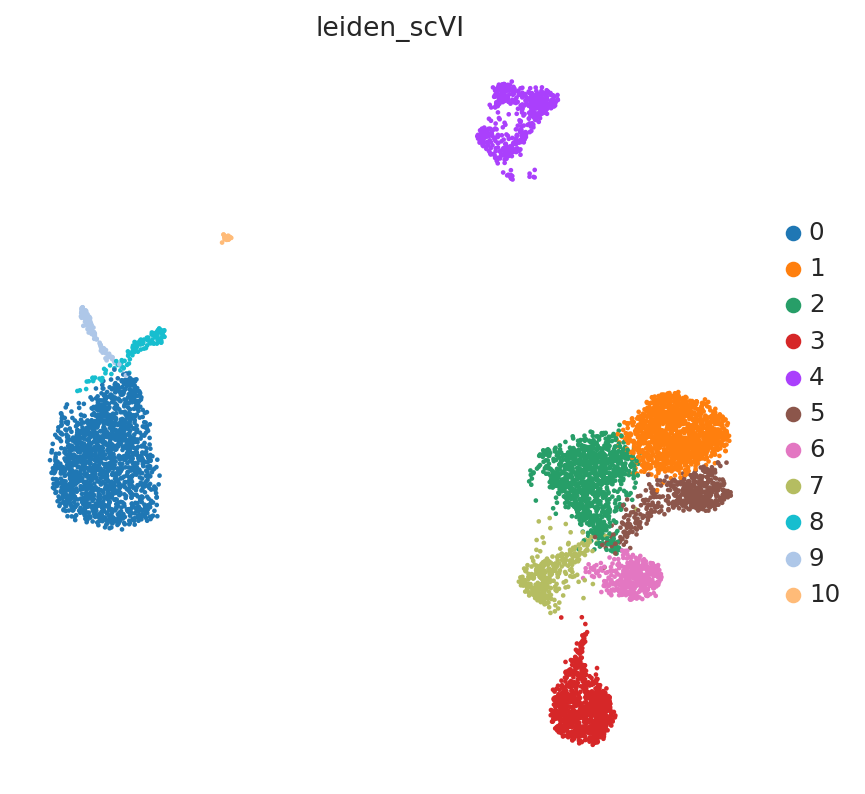

In [11]:
sc.pl.embedding(adata, "raw_counts_umap", color=["leiden_scVI"], frameon=False)

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

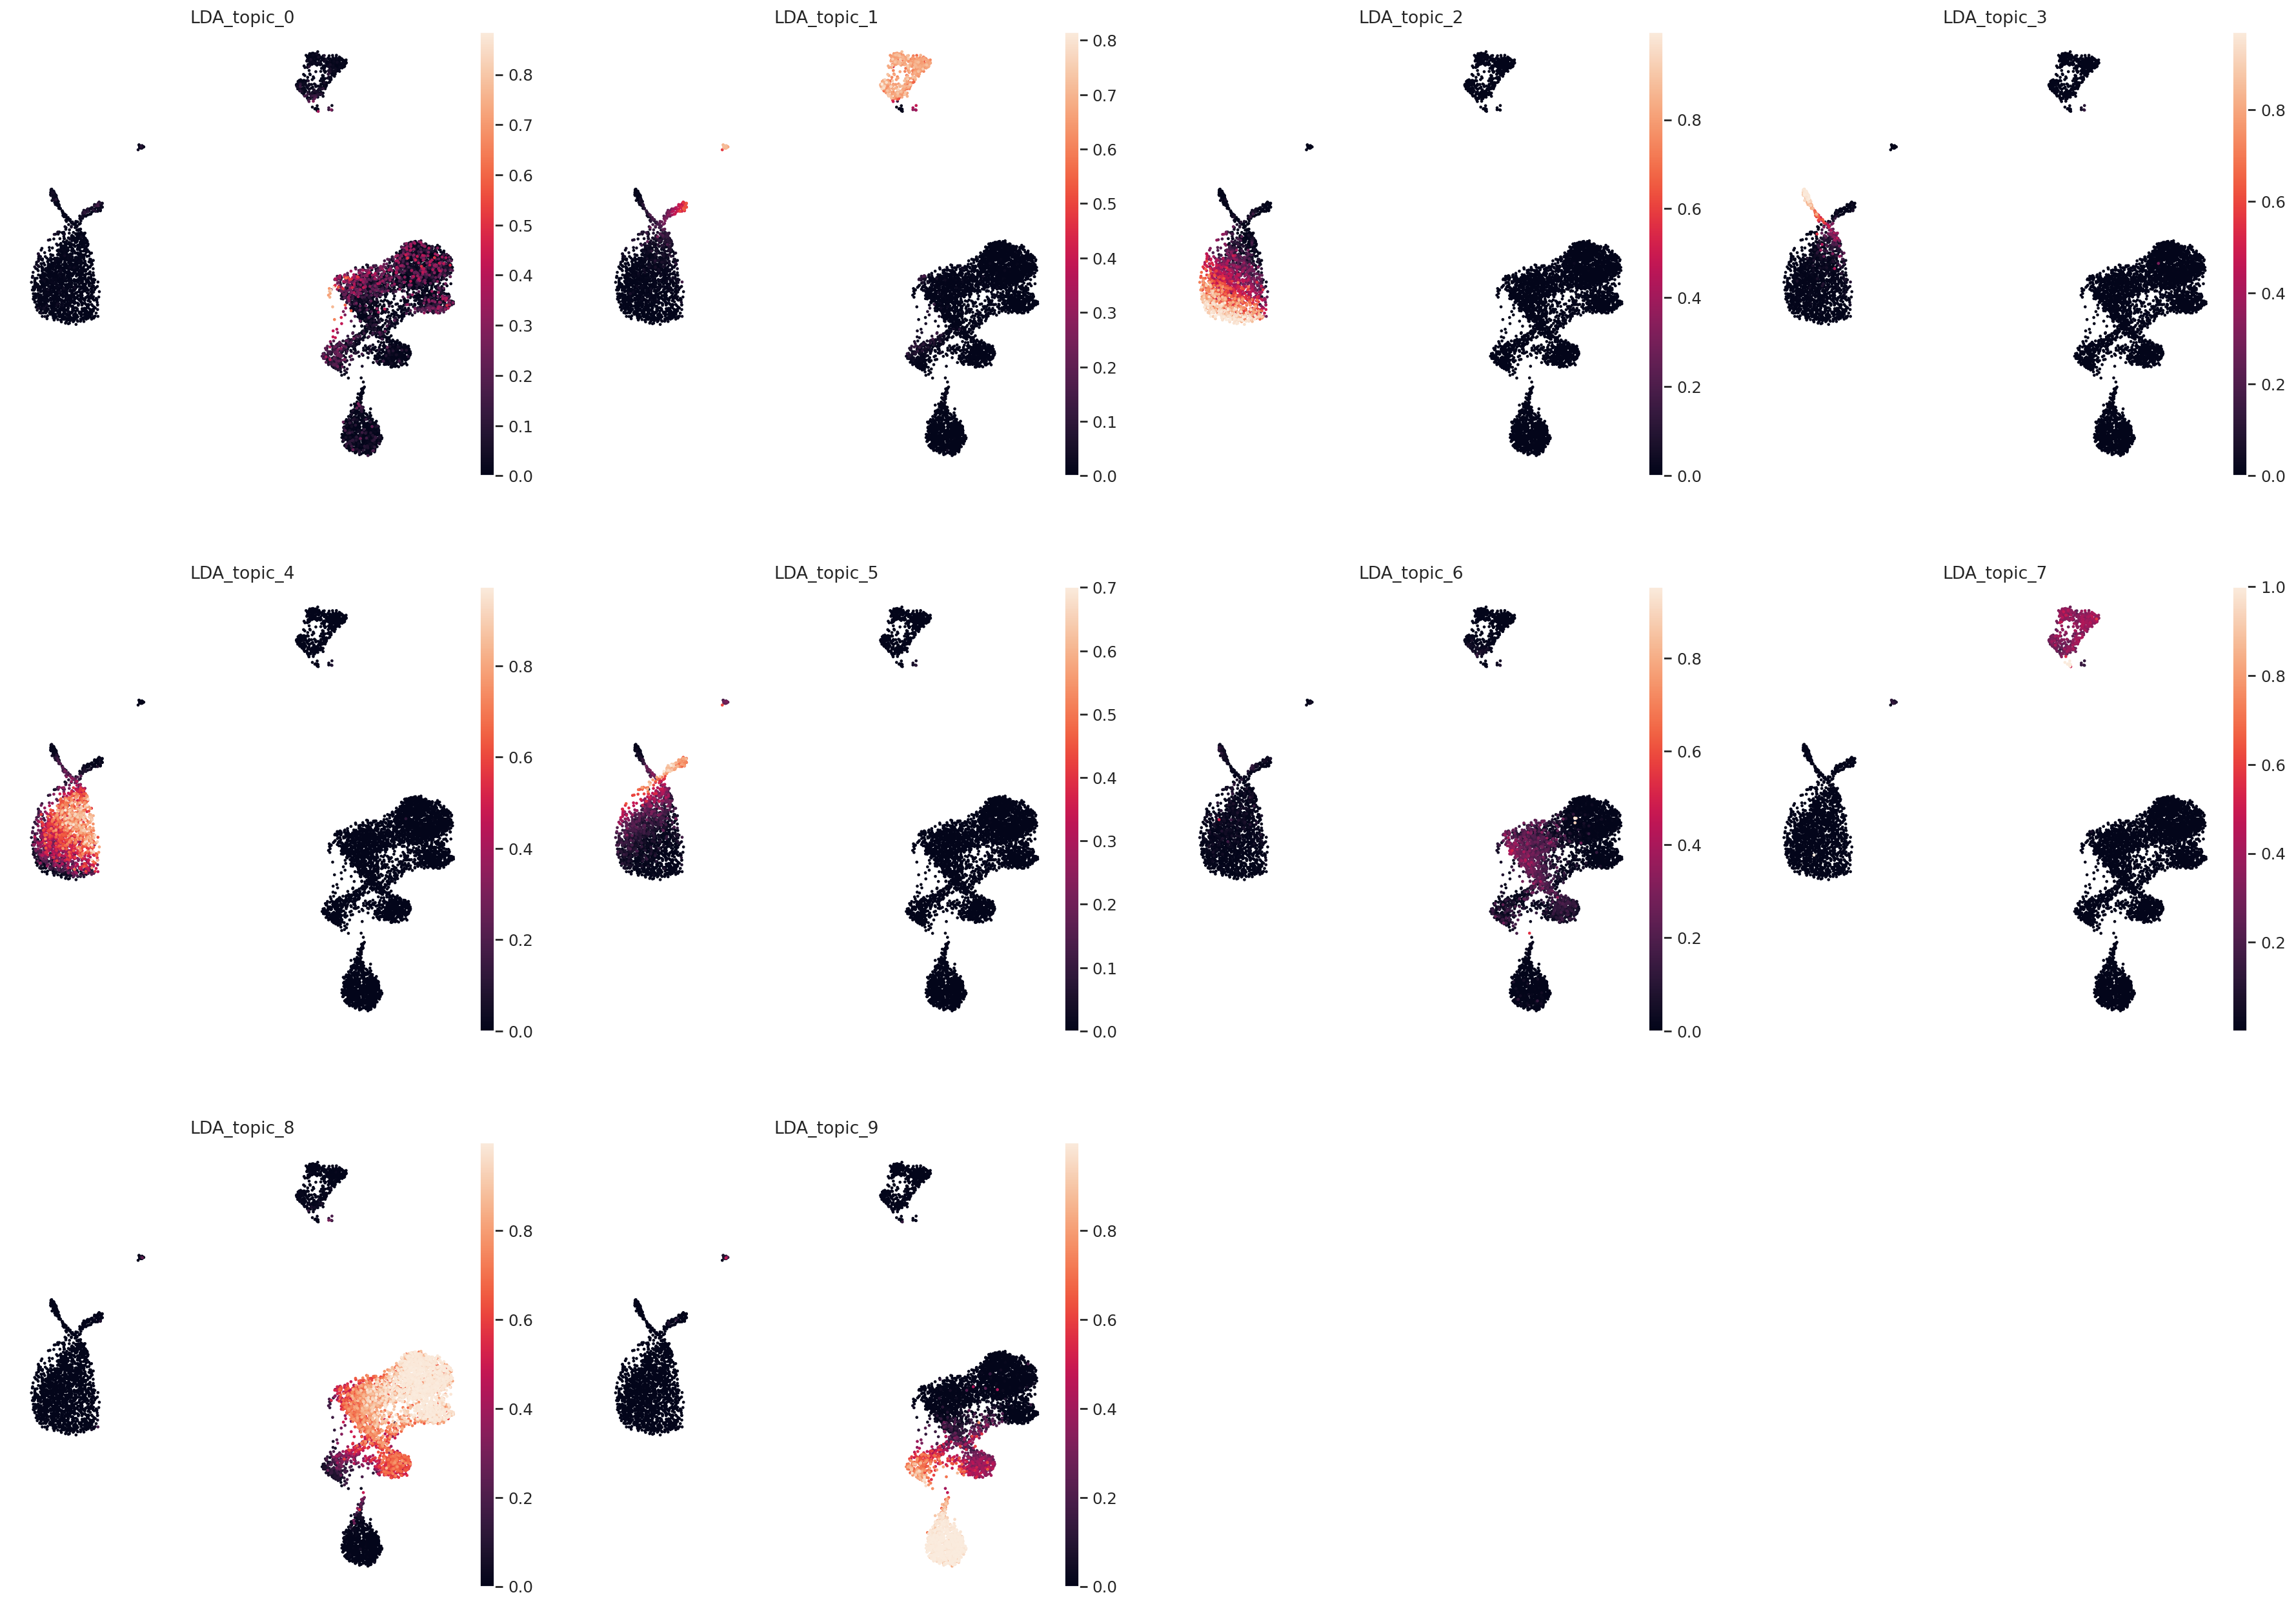

In [12]:
sc.pl.embedding(
    adata,
    "raw_counts_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Plot UMAP in topic space

In [13]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors=20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

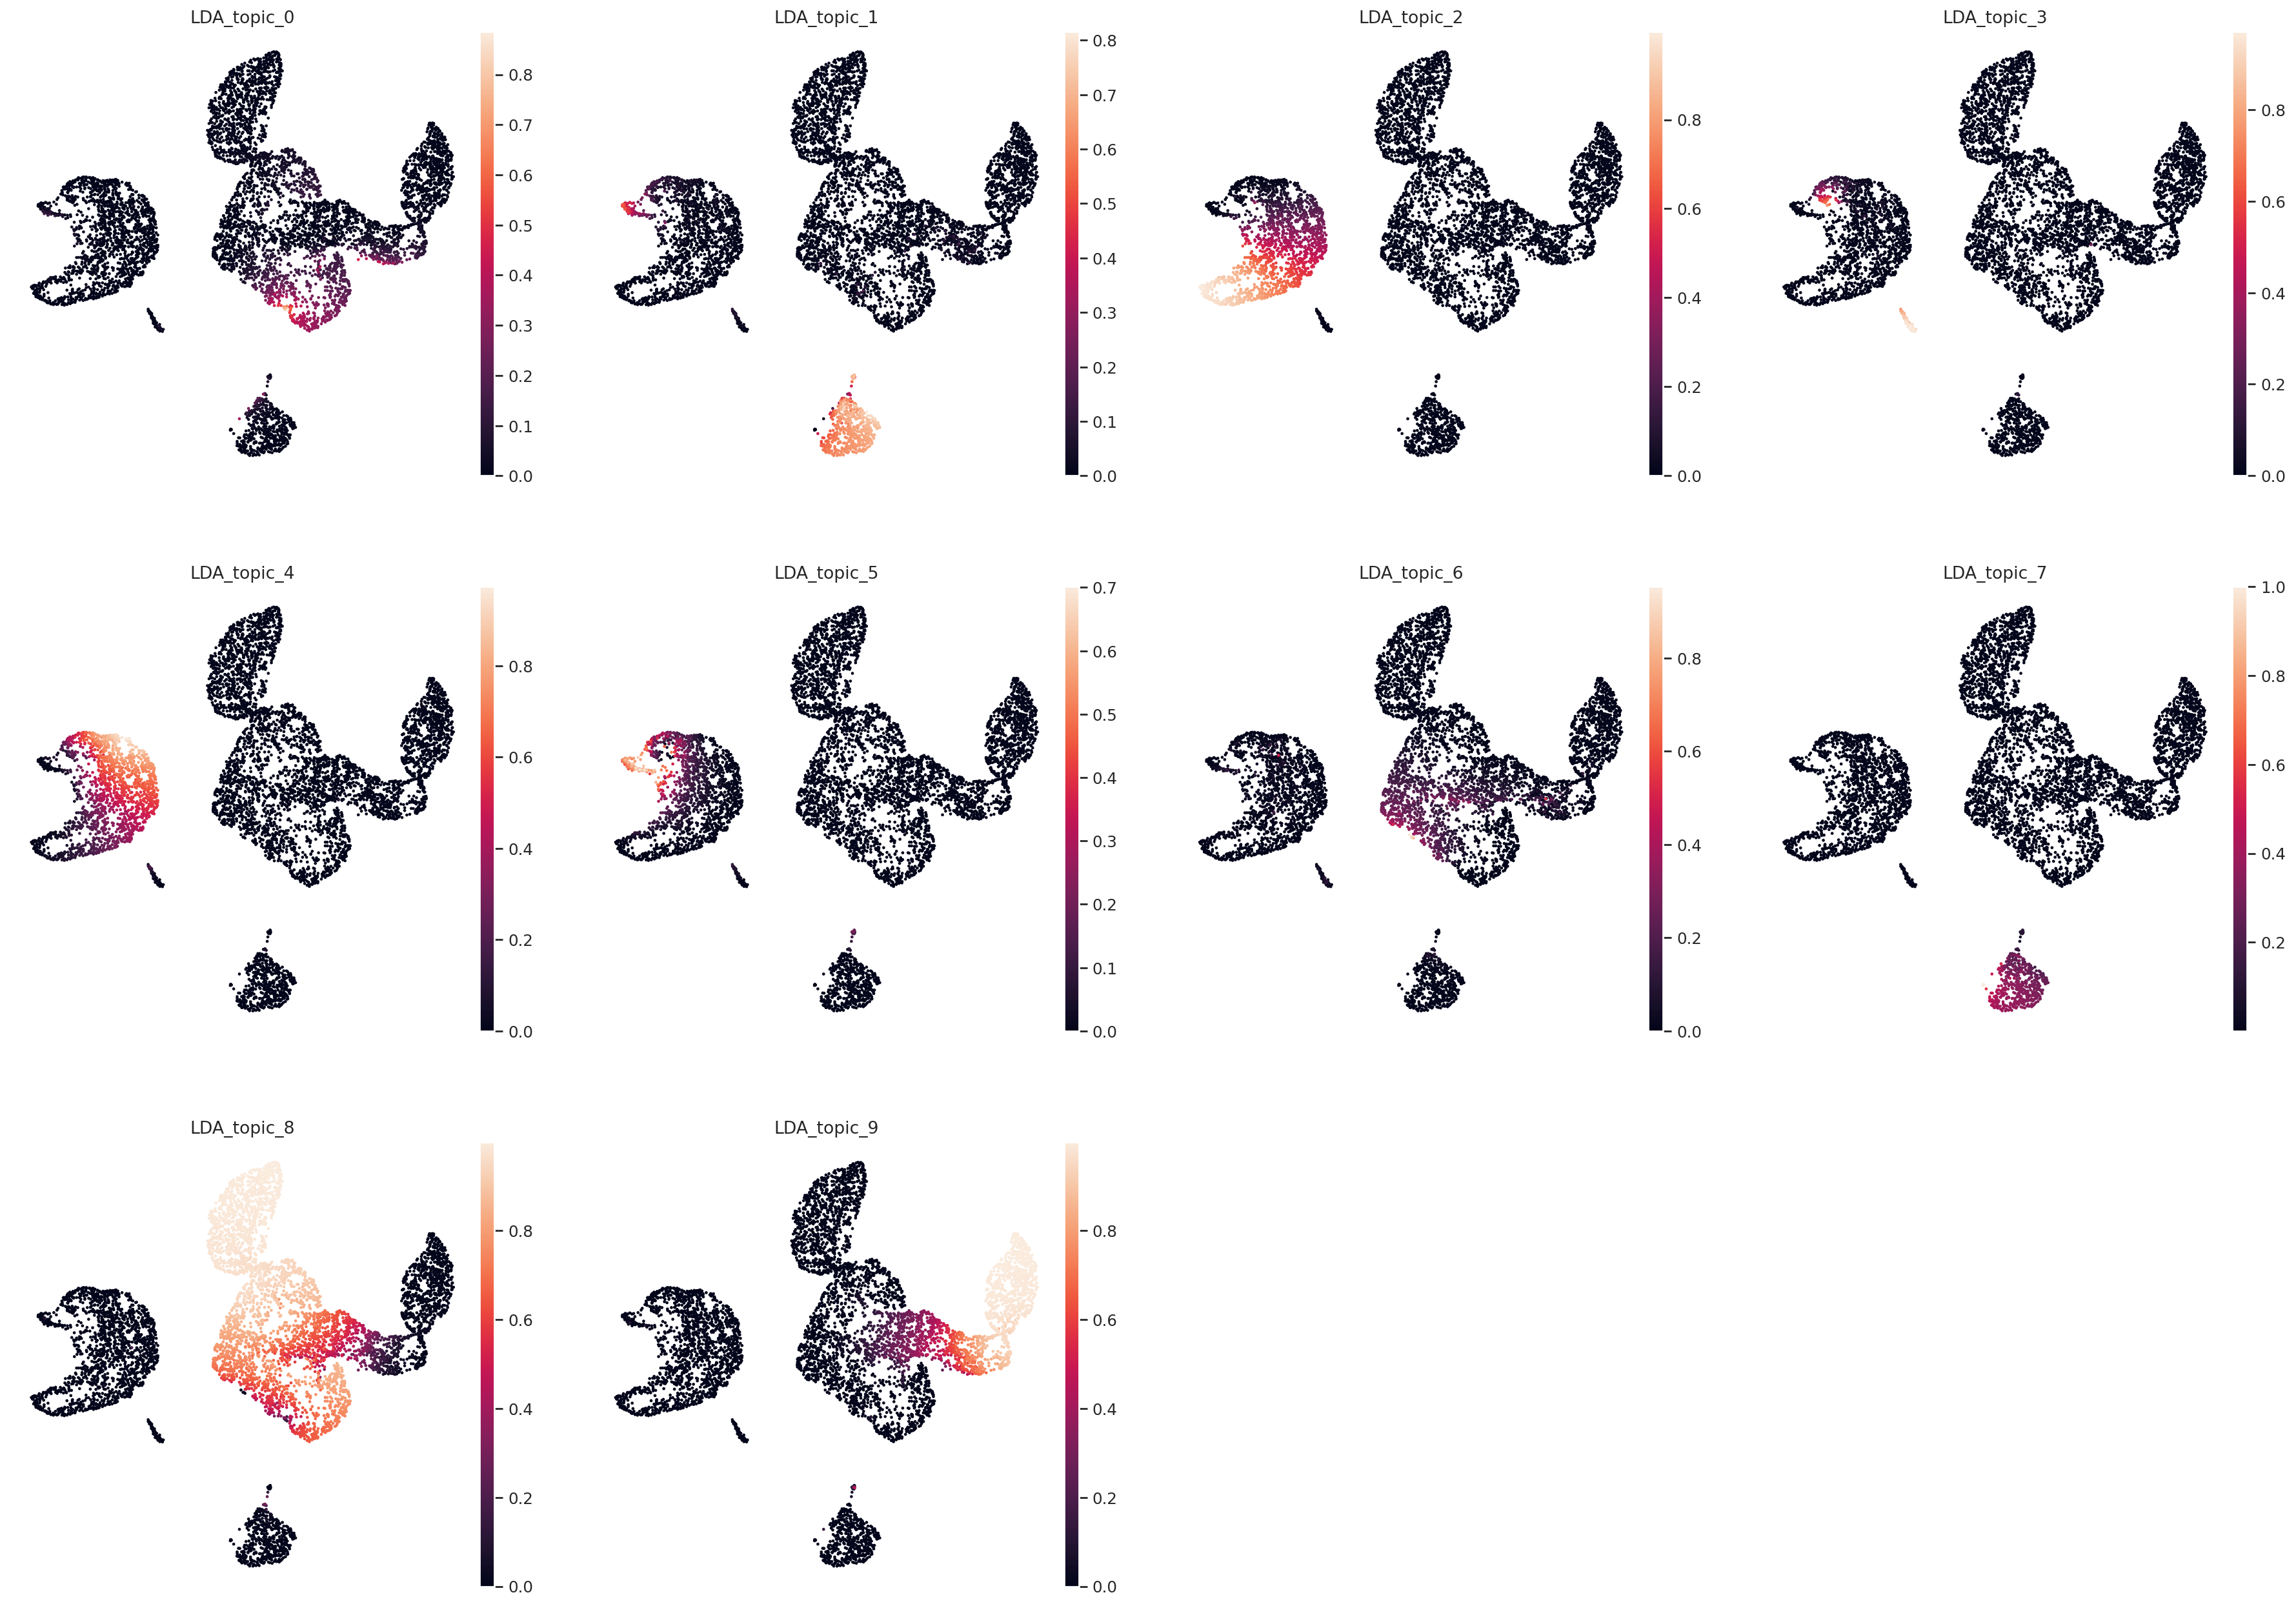

In [14]:
sc.pl.embedding(
    adata,
    "topic_space_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [15]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

topic_0   topic_1       topic_2   topic_3   topic_4   topic_5  \
index                                                                        
AL645608.8  0.000006  0.000003  3.027680e-06  0.000034  0.000001  0.000002   
HES4        0.000008  0.000011  8.718006e-06  0.000709  0.000006  0.000010   
ISG15       0.001584  0.000601  2.445053e-04  0.000691  0.000517  0.000033   
TNFRSF18    0.000038  0.000006  7.943196e-07  0.000003  0.000001  0.000002   
TNFRSF4     0.000033  0.000005  1.389031e-06  0.000004  0.000001  0.000004   

             topic_6   topic_7   topic_8   topic_9  
index                                               
AL645608.8  0.000007  0.000005  0.000001  0.000002  
HES4        0.000010  0.000009  0.000007  0.000006  
ISG15       0.000722  0.000200  0.001182  0.001377  
TNFRSF18    0.000180  0.000038  0.000403  0.000133  
TNFRSF4     0.000242  0.000008  0.000869  0.000057

In [16]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [17]:
rank_by_topic.head()

topic_0  topic_0_prop   topic_1  topic_1_prop topic_2  topic_2_prop topic_3  \
0    ACTB      0.305104      CD74      0.155522  S100A9      0.150716     FTL   
1  TMSB4X      0.151037   HLA-DRA      0.095580  S100A8      0.104741    ACTB   
2  TMSB10      0.108730    TMSB4X      0.062553     LYZ      0.058034    FTH1   
3   ACTG1      0.098599  HLA-DRB1      0.055460     FTL      0.043069  TMSB4X   
4   GAPDH      0.031823    TMSB10      0.042600    ACTB      0.038379  S100A4   

   topic_3_prop topic_4  topic_4_prop   topic_5  topic_5_prop   topic_6  \
0      0.116765    FTH1      0.062567       LYZ      0.072431    S100A4   
1      0.067006     FTL      0.059633      ACTB      0.069452       VIM   
2      0.059872     LYZ      0.052926   HLA-DRA      0.050705  SH3BGRL3   
3      0.059606  TMSB4X      0.036079      CST3      0.047043   S100A10   
4      0.026248    ACTB      0.031729  HLA-DRB1      0.030375    S100A6   

   topic_6_prop topic_7  topic_7_prop topic_8  topic_8_prop topic_9  \
0      0.177341    IGKC      0.235671  TMSB4X      0.133637  TMSB4X   
1      0.052818   IGLC2      0.128583  TMSB10      0.091962    ACTB   
2      0.047343   IGHA1      0.083414    ACTB      0.077558    GNLY   
3      0.043081    IGHM      0.057858    JUNB      0.038246    NKG7   
4      0.042836   IGLC3      0.038808     FTL      0.030914    CCL5   

   topic_9_prop  
0      0.087130  
1      0.085563  
2      0.070730  
3      0.053820  
4      0.041400